In [1]:
import pandas as pd 
import math
import json
import csv
import sys
import os
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import seaborn
import re
import numpy as np
from queue import PriorityQueue
import umap
import copy
import string
import time
import functools
import statistics
import matplotlib.lines as mlines
import matplotlib.patheffects as patheffects
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
# import umap.plot
from sklearn.preprocessing import StandardScaler
import itertools
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests
from os import path
import scipy
import networkx as nx
import pickle
from networkx.drawing.nx_agraph import graphviz_layout
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import metrics
from fitter import Fitter, get_common_distributions, get_distributions
reload_data = False

maxInt = sys.maxsize
while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
def is_list(l):
    if isinstance(l,(list,pd.core.series.Series,np.ndarray)):
        return True
    else:
        return False
    return False
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return list(zip(a, b))

In [2]:
maxShort = 32767
specialstring = "[!@#$%^&*()[]{};:,./<>?\|`~-=_+ ]"
USERPATH = ""
DATAPATH = ""

# Load Network Data

In [3]:
# Load Data Files
with open(DATAPATH + "data/elements.json") as json_file:
    NODES = json.load(json_file)
with open(DATAPATH + "data/interactions.json") as json_file:
    EDGES = json.load(json_file)
    
# The Modifiers files includes inforamtions on catalyzed reactions and their enzymes
with open(DATAPATH + "data/PhenotypePaths.json") as json_file:
    MODIFIERS = json.load(json_file)["modifiers"]

    
NODE_IDS = list(NODES.keys())     

NODE_NAME_ID_MAPPING = dict()
LPM_CLASSES = []

# Add additional information to the Node Dictionary
for _id, node in NODES.items():
    node["name"] = node["name"].replace("Thromboxan Synthesis", "Thromboxane Synthesis")
    node["lowercase"] = ''.join(node["name"].split()).lower()
    node["in_dataset"] = {}
    NODE_NAME_ID_MAPPING[node["lowercase"]] = _id
    # Read Count Values
    node["read_counts"] = {}
    node["norm_read_counts"] = {}
    
    node["name"] = node["name"].replace("_cytosol", "")
    # Phenotypes nodes represent the downstream lipid mediator classes
    if node["subtype"] == "PHENOTYPE":
        LPM_CLASSES.append(_id)


MOUSE_HUMAN_MAPPING = pd.read_csv(USERPATH + "OneDrive/SBI/Manuscripts/ImmuneCellSecretome/mouse_human_diff.txt", sep='\t')
MOUSE_HUMAN_MAPPING = pd.Series(MOUSE_HUMAN_MAPPING.mouse.values,index=MOUSE_HUMAN_MAPPING.human).to_dict()
ID_GENESYMBOL_MAPPING = {node_id: (MOUSE_HUMAN_MAPPING[NODES[node_id]["name"].lower()] if NODES[node_id]["name"].lower() in MOUSE_HUMAN_MAPPING else NODES[node_id]["name"].lower()) for node_id in NODES}

In [4]:
def get_node_from_name(name, return_id = True, secreted = False):
    name = ''.join(name.split()).lower()
    if name in NODES:
        return name if return_id else NODES[name]
    if name in NODE_NAME_ID_MAPPING:
        if return_id:
            return NODE_NAME_ID_MAPPING[name]
        else:
            return NODES[NODE_NAME_ID_MAPPING[name]]
    return False

def print_progress_bar (iteration, total, prefix = 'Progress', suffix = 'Complete', decimals = 1, length = 50, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    if iteration == total: 
        print()

def is_expressed(node, cell, dataset, filtering = "none", threshold = 0):
    if NODES[node]["in_dataset"][dataset] == True:
        if NODES[node]["norm_read_counts"][dataset][cell] > threshold:
            return True
        else:
            return False
    else:
        if filtering == "none":
            return True
        elif filtering == "not genes":
            return False if "HGNC" in NODES[node]["ids"] else True
        elif filtering == "all":
            return False
        else:
            return True

# Shortest Path Calculation (BFS)

In [5]:
def cell_bfs(dataset, cells = [], starting_nodes = [], threshold = 0, only_expressed_starting_nodes = False, 
             filtering = "none", reverse = False, progress_bar = True, only_submap = False):
    
    cells = cells if len(cells) > 0 else DATA_SAMPLES[dataset]
    starting_nodes = (starting_nodes if starting_nodes and len(starting_nodes) > 0 else NODE_IDS)
    
    # cell specific dict of SP information
    cell_sp_dict = dict()

    # Dict template which is deep-copied for each cell
    sp_dict_template = {
        "sp_length": {_id: {} for _id in starting_nodes},
        "sp_count": {_id: {} for _id in starting_nodes},
        "sp_type": {_id: {} for _id in starting_nodes},
        "paths": {_id: {} for _id in starting_nodes},
        "degree": {_id: 0 for _id in NODES},
    }
        
    for i,cell in enumerate(cells):

        if progress_bar:
            print_progress_bar(i, len(cells))
        
        cell_sp_dict[cell] = copy.deepcopy(sp_dict_template)
        
        # full set of nodes included in the calculation
        nodes = set() if only_expressed_starting_nodes else set(starting_nodes)
        # submaps included  the biosynthesis pathway without the transcritional regulatory network
        # this restriction speeds up the calculation of enzyme scores
        if cell == "total":
            nodes = nodes.union(set([node for node in NODE_IDS if (only_submap == False or NODES[node]["submap"])]))
        else:
            nodes = nodes.union(set([node for node in NODE_IDS if (is_expressed(node, cell, dataset, threshold = threshold, filtering = filtering) 
                                                                   and (only_submap == False or NODES[node]["submap"]))]))

        # dictionary of edges
        edges = {node: {} for node in nodes}  
        for target, source, edge_type, edge_subtype, from_submap in [(edge["target"], edge["source"], edge["type"], edge["subtype"], edge["submap"]) for edge in EDGES]:
            if not only_submap or from_submap:
                if set([target, source]) < nodes:
                    edge_string = source + "_" + target
                    #only include catalyzed reactions as edges in the BFS if a catylzing enzyme is expressed in the cell 
                    enzymes_for_reaction = [enzyme for enzyme,reaction_list in MODIFIERS.items() if edge_string in reaction_list]
                    if edge_string == "m8_m10":
                        print(enzymes_for_reaction)
                    if len(enzymes_for_reaction) == 0 or any([enzyme in nodes for enzyme in enzymes_for_reaction]):
                        if reverse:
                            edges[target][source] = edge_type
                        else:
                            edges[source][target] = edge_type
                        cell_sp_dict[cell]["degree"][target] += 1
                        cell_sp_dict[cell]["degree"][source] += 1
        
        # BFS Algorithm
        for starting_node in starting_nodes:
            
            visited_nodes = [starting_node] 
            node_queue = [starting_node] 
            sp_length = {starting_node:0};
            sp_count = {starting_node:0}
            sp_type = {starting_node:1}
            paths = {starting_node:[[(starting_node,1)]]}
            
            while len(node_queue) > 0:
                current_node = node_queue.pop(0);                
                for next_node, edge_type in edges[current_node].items():
                    if next_node not in visited_nodes:
                        visited_nodes.append(next_node)
                        sp_length[next_node] = sp_length[current_node] + 1
                        paths[next_node] = [path + [(next_node,edge_type)] for path in paths[current_node]]
                        sp_count[next_node] = 1
                        sp_type[next_node] = sp_type[current_node] * edge_type
                        node_queue.append(next_node)
                    elif sp_length[next_node] == sp_length[current_node] + 1:
                        sp_count[next_node] += 1
                        paths[next_node] += [path + [(next_node,edge_type)] for path in paths[current_node]]
                        sp_type[next_node] = (sp_type[current_node] * edge_type) if (sp_type[next_node] != -1) else sp_type[next_node]
                        
            cell_sp_dict[cell]["sp_length"][starting_node] = sp_length
            cell_sp_dict[cell]["sp_count"][starting_node] = sp_count
            cell_sp_dict[cell]["sp_type"][starting_node] = sp_type
            cell_sp_dict[cell]["paths"][starting_node] = {node:[path[::-1] for path in path_list] for node,path_list in paths.items()} if reverse else paths

    if progress_bar:
        print_progress_bar(1, 1)
        
    return cell_sp_dict       

# LPM Specific Enzyme Scores

In [6]:
# enzyme scores represent a weighting factor for enzymes in the biosynthesis pathway of LPMs
# e.g. isoenzymes each have lower scores than enzymes catalyzing key reactions
def generate_enzyme_scores():
    enzyme_scores = {}   
    edges = {node:{} for node in NODES}
    for edge in EDGES:
        if edge["submap"] and edge["type"] != 0:
            edges[edge["target"]][edge["source"]] = edge["type"]
            
    def recursive_path(path):
        node = path[0][-1]
        if len(edges[node]) == 0:
            return [path]
        paths = []
        for next_node,edge_type in edges[node].items():
            if next_node not in path[0]:
                paths += [[path[0] + [next_node], path[1]*edge_type]]
                paths += recursive_path([path[0] + [next_node], path[1]*edge_type])
        return paths if paths else [path]
    
    for i,lpm_class in enumerate(LPM_CLASSES):
        print_progress_bar(i, len(LPM_CLASSES))

        # all paths leading backwards from from the lpm class node
        paths = recursive_path([[lpm_class],1])
        nodes_on_paths = list(set(sum([path[0] for path in paths], [])))
        # get enzyme score based on their inclusion in the paths and direction
        scores = {}
        for node in [node for node in NODES if NODES[node]["submap"]]:
            if NODES[node]["type"] == "PROTEIN" and node != lpm_class:
                paths_through_node = [path for path in paths if node in path[0]]
                catalyzed_paths = [path for path in paths if (node in MODIFIERS and any([catalyzed_reactions in "_".join(reversed(path[0])) for catalyzed_reactions in MODIFIERS[node]]))]
                paths_starting_from_node = [[path[0][path[0].index(node):], path[1]] for path in paths_through_node if node in path[0]]
                
                if len(catalyzed_paths)  > 0:
                    minlength = min([len(path[0]) for path in catalyzed_paths])
                    sp_type = min([path[1] for path in catalyzed_paths if len(path[0]) == minlength], default = 1)
                else:
                    sp_type = min([path[1] for path in paths_starting_from_node], default = 1)
                    
                nodes_on_paths_starting_from_node = list(set(sum([path[0] for path in paths_starting_from_node], [])))
                scores[node] = (sp_type * (((len(paths_through_node) + len(catalyzed_paths)) / len(paths)) + (len(nodes_on_paths_starting_from_node)/len(nodes_on_paths))))
        
        max_score = max([abs(score) for score in scores.values()])
        enzyme_scores[lpm_class] = {node:(score/max_score) for node,score in scores.items() if score != 0}
        
        print_progress_bar(i+1, len(LPM_CLASSES))    

    return enzyme_scores

ENZYME_SCORES = generate_enzyme_scores()

Progress |██████████████████████████████████████████████████| 100.0% Complete


# Load Data

In [7]:
def load_data(dataset, threshold = 10, percent = 0.01, max_threshold = 100):
    data = pd.read_csv(DATAPATH + "data/" + dataset + "_Normalized_Gene_count_table.csv", index_col = 0, sep=',')
    data.columns = [x.replace("#", ".") for x in data.columns.values]
    
    def filter_low_expressed_genes(row):
        max_value = max(row)
        for i, val in enumerate(row):
            if max_value < max_threshold or val < threshold or val/max_value <= percent:
                row[i] = 0
        return row

    if dataset == "GSE110549" or dataset == "GSE75194":
        data = data.set_index("GeneSymbol")
        data = data.groupby(level=0)
        data = data.agg('mean')
    data.index = data.index.map(str)
    data.index = data.index.str.lower()    
    data = data.apply(lambda row : filter_low_expressed_genes(row), axis = 1)
    data = data.loc[(data!=0).any(axis=1)] 
    data = data.loc[:, (data != 0).any(axis=0)] 
    
    nodes_in_data = {node_name:node_id for node_id,node_name in ID_GENESYMBOL_MAPPING.items() if node_name in data.index}                 
    data = data.loc[list(set(nodes_in_data.keys()))] 
    
    data = data.rename(index={index:nodes_in_data[index] for index in data.index})
    
    for node_id,node in NODES.items():
        node["read_counts"][dataset] = {} 
        if node_id in data.index:
            for cell in data.columns:
                node["read_counts"][dataset][cell] = data.loc[node_id,cell]
            node["in_dataset"][dataset] = True
        else:
            node["read_counts"][dataset] = {cell:0 for cell in data.columns}
            node["in_dataset"][dataset] = False

    return data

def normalize(row):
    max_value = max(row)
    if max_value != 0:
        for i, val in enumerate(row):
            row[i] /= max_value
    return row

def normalize_data(dataset):
    data = copy.deepcopy(EXPRESSION_DATA[dataset]).apply(lambda row : normalize(row), axis = 1)
    
    for node_id,node in NODES.items():
        node["norm_read_counts"][dataset] = {} 
        if node_id in data.index:
            for cell in data.columns:
                node["norm_read_counts"][dataset][cell] = data.loc[node_id,cell]
        else:
            node["norm_read_counts"][dataset] = {cell:0 for cell in data.columns}
            
    return data

GSE_DATASETS = ["GSE122108", "GSE109125"]#, "GSE110549", "GSE75194"]
EXPRESSION_DATA = {dataset:load_data(dataset, threshold = 10, percent = 0) for dataset in GSE_DATASETS}
NORM_EXPRESSION_DATA = {dataset:normalize_data(dataset) for dataset in GSE_DATASETS}
DATA_SAMPLES = {dataset:list(EXPRESSION_DATA[dataset].columns) for dataset in GSE_DATASETS}                    

## Get Samples with Stimulus

In [8]:
def get_stim_cells(dataset, include_control = False, sample_list = False):
    
    samples = DATA_SAMPLES[dataset]
    
    def removeTimeAndStim(label, _stimulus, _time, sep = "."):
        if _stimulus:
            label = sep.join(label.split(_stimulus))
        if _time:
            label = sep.join(label.split(_time))        
        return label
    
    stimulus_times = {
        "LPS": ["3hr", "18hr", "3d", "d3", "d6"],
        "Calb": ["8h", "48h"],
        "inj": ["d2", "d4"],
        "APAP": ["12h", "36h"],
        "Thio": ["3hr", "4h", "8h", "18hr", "24h", "72h", "3d"],
        "pIC": [""],
        "IFNa": ["2hr"],
        "IFNg": ["2hr"],
        "IFN": ["0U", "01U","1U", "10U", "100U", "1000U"]
    }
    
    stim_sample_dict = {s:{} for s in stimulus_times}
    for stimulus, times in stimulus_times.items():
        stim_samples = [sample for sample in samples if "." + stimulus + "." in sample]
        control_samples = {}
        
        for sample in stim_samples:
            control = sample.rsplit('.', 1)[0]
            for time in times:
                control = control.replace("." + stimulus + "." + time, "")
            if control not in control_samples:
                control_samples[control] = []
            control_samples[control].append(sample)   
        
        for control,stim_samples in control_samples.items():
            stim_sample_dict[stimulus][control] = [
                [control_sample for control_sample in [sample for sample in samples if control in sample] if all([time not in control_sample for time in times])]
            ]
            for time in times:
                if not time and len(times) == 1:
                    stim_sample_dict[stimulus][control].append([sample for sample in stim_samples if stimulus in sample.split(".")])
                else:
                    stim_sample_dict[stimulus][control].append([sample for sample in stim_samples if time in sample.split(".")])
 
    for stimulus, control_samples in stim_sample_dict.items():
        for control in control_samples.keys():
            stim_samples = [sample for sample in control_samples[control] if len(sample) > 0]
            # try:
            #     control_samples[control] = sorted(stim_samples, key = lambda sample: float(re.sub('\D', '', sample[0].split(stimulus)[1].split(".")[1])) if stimulus in sample[0] else 0)
            # except:
            #     # pass
            control_samples[control] = stim_samples
    if sample_list:
        return sum(sum([sum(list(x.values()), []) for x in stim_sample_dict.values()], []), [])
    else:
        return stim_sample_dict

STIMULATED_SAMPLES = {dataset: get_stim_cells(dataset) for dataset in GSE_DATASETS}

# Basic Functions

In [9]:
def lpm_class_genes(lpm_class, dataset = "", only_positive = True):
    return [node_id for node_id, node in NODES.items() if node["submap"] and (node["in_dataset"][dataset] if dataset else any([node["in_dataset"][dataset] for dataset in GSE_DATASETS])) and node_id in ENZYME_SCORES[lpm_class] and (only_positive == False or ENZYME_SCORES[lpm_class][node_id] > 0)]

# UMAP

## Basic UMAP Functions

In [10]:
def run_umap(data, method = "umap", n_neighbors=30, min_dist=0.1, n_components=2, metric="canberra"):
    
    # the highlight attribute is either a list of samples (shown as red star shapes with increased size) or a dictionary with samples as keys and ["size", "marker", "color"] values
    data = data.copy()
    data = data.loc[(data!=0).any(axis=1)]
    
    if method == "umap":
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric,
            random_state=42
        )
        scaled_data = StandardScaler().fit_transform(data.T)
        embedding = reducer.fit_transform(scaled_data)
        
    elif method == "pca":
        scaled_data = preprocessing.scale(data.T)
        pca = PCA()
        pca.fit(scaled_data)
        embedding = np.array([[comp[0], comp[1]] for comp in pca.transform(scaled_data)])
#         pca_df = pd.DataFrame(pca_data, index=[*wt], columns=labels)
        
    # print(embedding)
        
    return embedding

def print_umap(samples, embedding, labeled_sample_clusters, legend_fontsize = 12, title = "UMAP", highlight = [], fig_size = (30,15), marker_size = 100, n_markers = 5, 
               ax = None, cmap = "gist_rainbow", legend = "upper right", sorted_legend = False, font_size = 15, file_name = "", plt_style = 'seaborn-white'):

    marker_symbols = [ "o", "^", "d", "+"]
    markers = marker_symbols[:n_markers] if n_markers < len(marker_symbols) else marker_symbols
    lable_marker_dict = {}
    sample_label_dict = {}
    cluster_labels = list(labeled_sample_clusters.keys())
    cluster_list = []

    for i,label in enumerate(cluster_labels):
        lable_marker_dict[label] = markers[i%len(markers)]
        for sample in labeled_sample_clusters[label]:
            sample_label_dict[sample] = label

    hsv = plt.get_cmap(cmap)
    handles = []
    
    # the cmap_split_fac is required to split the cmap colors based on the number of required colors get the maximum distinction between them
    # e.g. if two colors are required (e.g. in case of 6 samples and 3 markers) then colors should be chosen from each end of the cmap spectrum
    cmap_split_fac = ((len(labeled_sample_clusters)-1)//len(markers))+1 if len(labeled_sample_clusters) > len(markers) else 2
    cluster_color_dict = {}
    for i,label in enumerate(cluster_labels):
        c = hsv((i//len(markers))/cmap_split_fac)
        handles.append(mlines.Line2D([], [], color=c, marker=lable_marker_dict[label], linestyle='none',
                      markersize=8, label=label))
        cluster_color_dict[i] = c
        cluster_list.append(labeled_sample_clusters[label])
    if sorted_legend:
        handles = sorted(handles, key = lambda handle: handle.get_label())
    
    newfigure = True if not ax else False
    if newfigure:    
        plt.clf()
        fig = plt.figure(figsize = fig_size)
        ax = fig.gca()

    # show each sample as a point with a specific shape and color, either highlighted or depending on the cluster 
    for i,sample in enumerate(samples):
        ax.scatter(
            embedding[:, 0][i],
            embedding[:, 1][i],
            color = (highlight[sample]["color"] if type(highlight) is dict and "color" in highlight[sample] else (1, 0, 0)) if sample in highlight else (hsv((cluster_labels.index(sample_label_dict[sample])//len(markers))/cmap_split_fac) if sample in sample_label_dict else "#c8c8c8"),
            s = (marker_size * (highlight[sample]["size"] if type(highlight) is dict and "size" in highlight[sample] else 2)) if sample in highlight else marker_size,
            marker= (highlight[sample]["marker"] if type(highlight) is dict and "marker" in highlight[sample] else "*") if sample in highlight else (lable_marker_dict[sample_label_dict[sample]] if sample in sample_label_dict else "o"), 
            zorder= (highlight[sample]["z"] if type(highlight) is dict and "z" in highlight[sample] else 2) if sample in highlight else 1
        )
    ax.set_title(title, fontsize=24)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
          
    
    if legend:
        if legend == "outside":
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            legend = ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = legend_fontsize)
        elif legend == "below":
            box = ax.get_position()
            ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
            legend = ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize = legend_fontsize)
        else:
            legend = ax.legend(handles=handles, loc = legend, fontsize = legend_fontsize)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('white')
    ax.set_facecolor((1, 1, 1))
    if file_name:
        plt.savefig(file_name + ".png", dpi=300, bbox_inches='tight', transparent=True)
    
    if newfigure:
        plt.show()
    
    return (cluster_list,cluster_color_dict)  

## Run UMAP on Full Data

In [11]:
UMAP_EMBEDDING = {dataset:run_umap(EXPRESSION_DATA[dataset], method = "umap") for dataset in GSE_DATASETS[:2]}   

## Print Cell-Type Clustered UMAP

<Figure size 640x480 with 0 Axes>

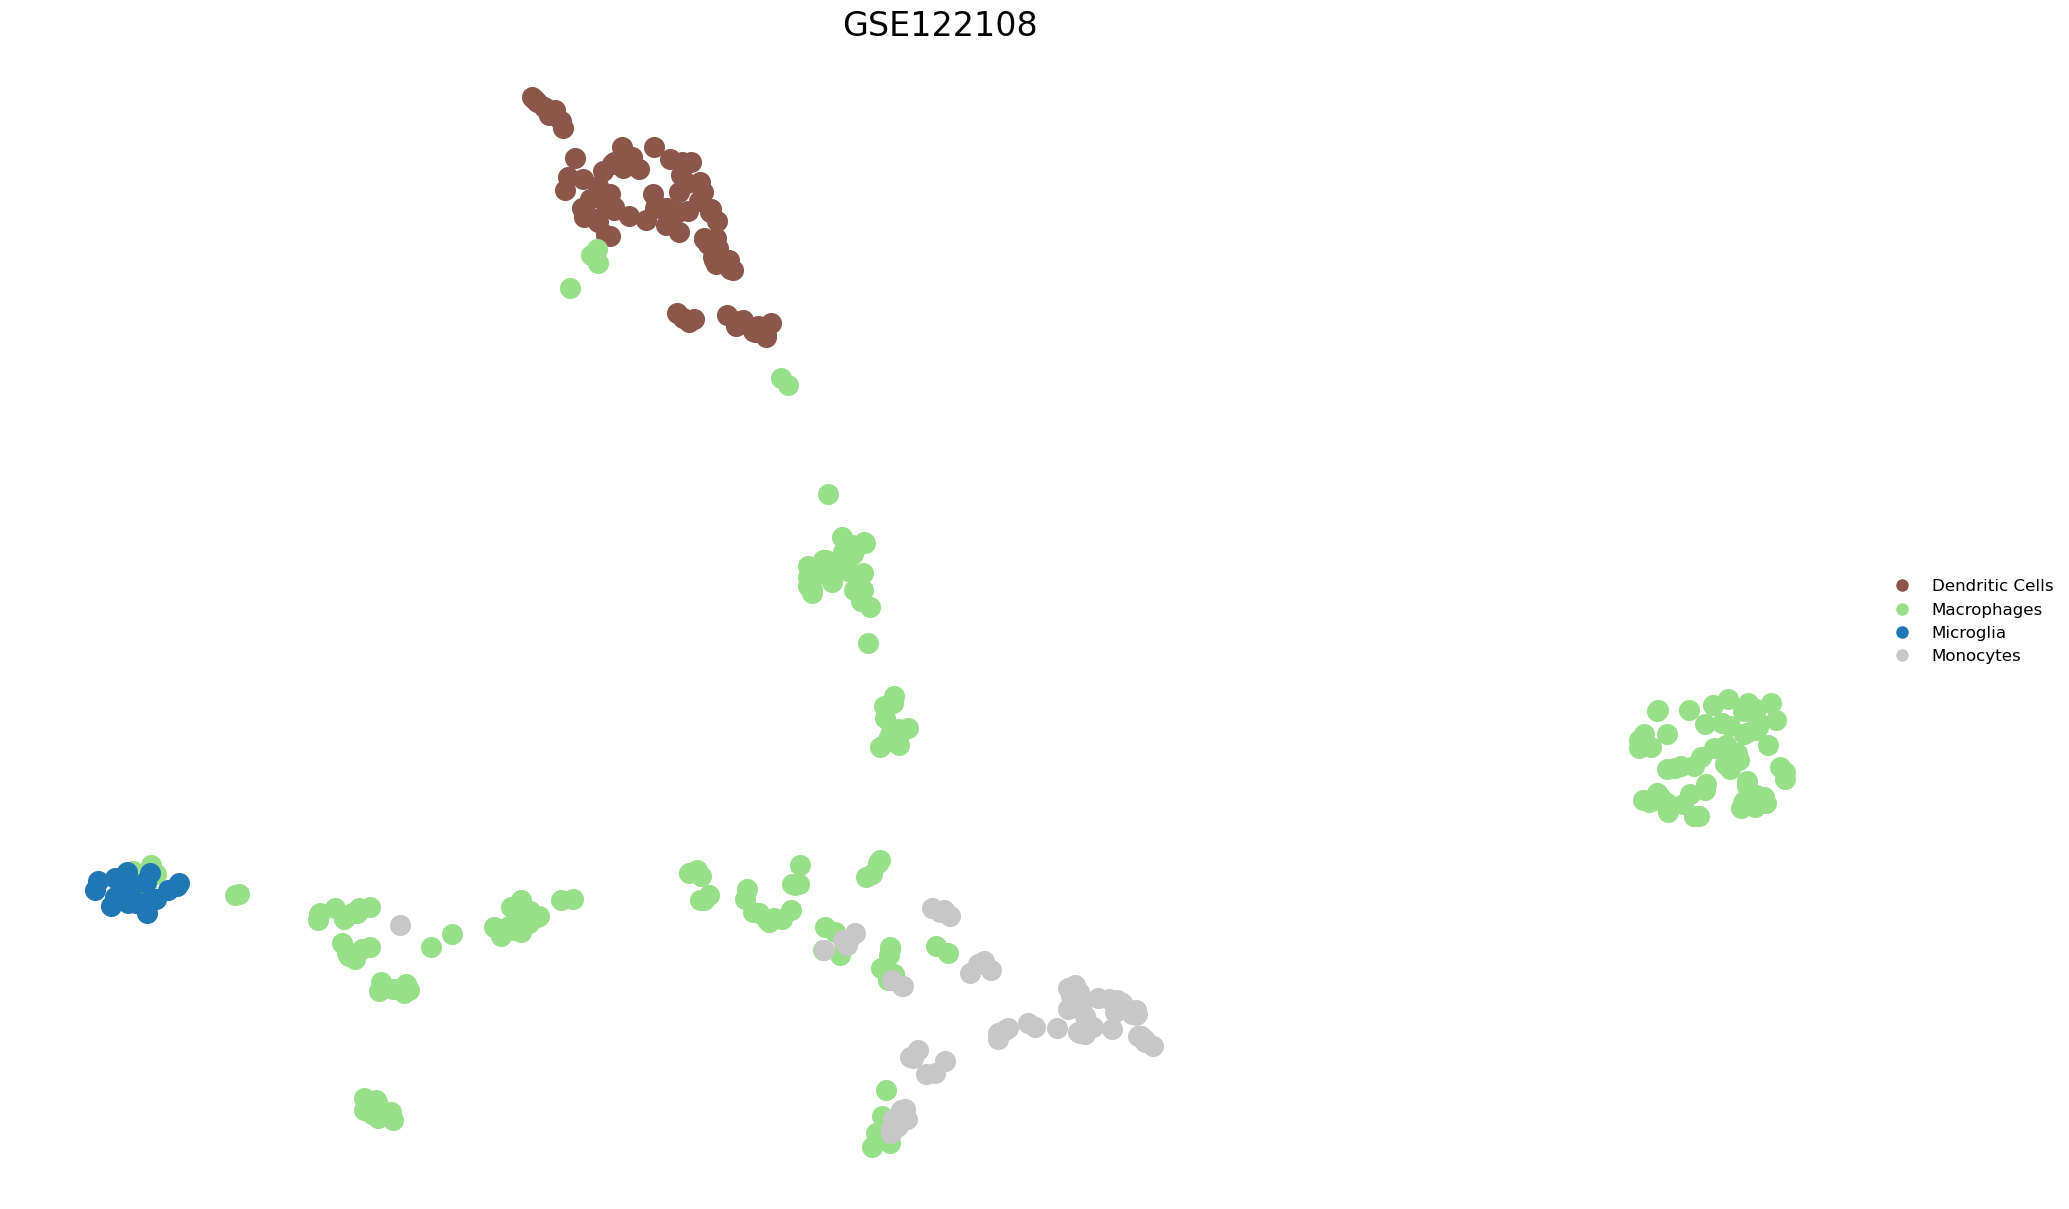

<Figure size 640x480 with 0 Axes>

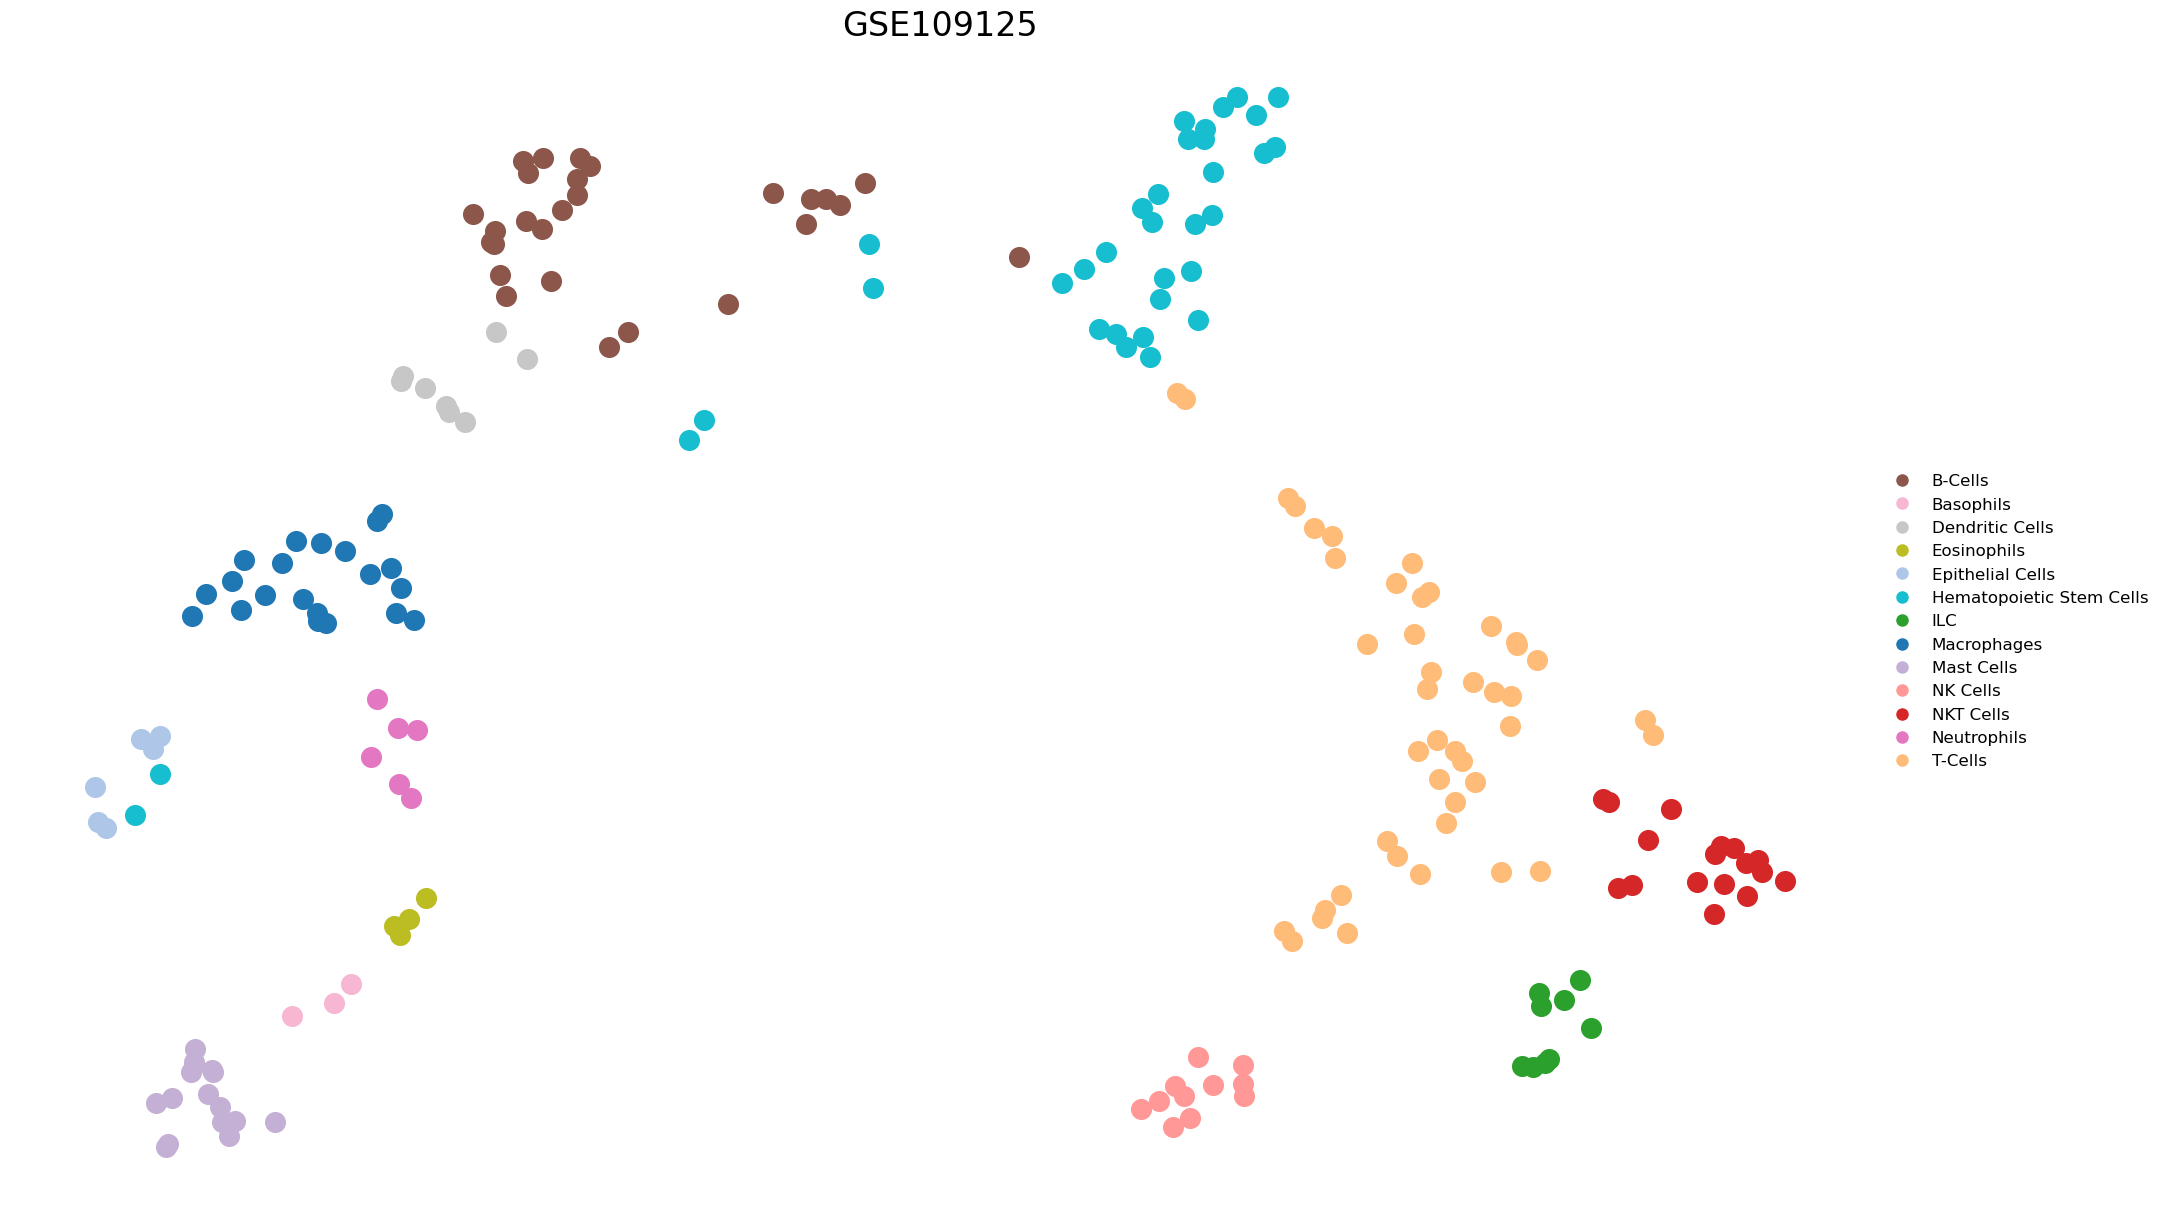

In [12]:
def print_umap_with_cell_clusters(samples, embedding, dataset, highlight = [], ax = None, font_size = 16, fig_size = (30,15), n_markers = 3, sorted_legend = False,  legend = "upper right", cmap = "gist_rainbow", file_name = "", marker_size = 100):

    if dataset == "GSE109125":
        cluster_labeling_filter = {
            "Macrophages": ["MF.", "Mo."],
            "Epithelial Cells": ["BEC", "FRC"],
            "T-Cells": ["T.4", "T.8", "T.DP", "T8.", "Tgd", "Tre"],
            "ILC": ["ILC"],
            "NKT Cells": ["NKT."],
            "NK Cells": ["NK."],
            "Mast Cells": ["MC."],
            "B-Cells": ["B.", "B1b."],
            "Neutrophils": ["GN"],
            "Basophils": ["Ba."],
            "Dendritic Cells": ["DC."],
            "Eosinophils": ["Eo."],
        }
        others = "Hematopoietic Stem Cells"
    elif dataset == "GSE122108":
        cluster_labeling_filter = {
            "Microglia": ["MG.", "MF.microglia"],
            "Macrophages": ["MF."],
            "Dendritic Cells": ["DC."],
            "Monocytes": ["Mo."],
        }
        others = "others"
    else:
        cluster_labeling_filter = {}
        others = "others"

    cell_cluster_labels = {k:[] for k in cluster_labeling_filter}
    cell_cluster_labels[others] = []

    for sample in samples:
        label_found = False
        for label, filter_list in cluster_labeling_filter.items():
            if any([sample.startswith(filter_string) for filter_string in filter_list]):
                cell_cluster_labels[label].append(sample)
                label_found = True
                break
        if not label_found:
            cell_cluster_labels[others].append(sample) 
    
    cell_cluster_labels = {k:v for k,v in cell_cluster_labels.items() if len(v) > 0}
    cell_cluster_list,cell_cluster_colors = print_umap(samples, embedding, cell_cluster_labels, title = dataset, fig_size = fig_size, highlight = highlight, ax = ax, n_markers = n_markers, legend=legend,sorted_legend = sorted_legend, font_size = font_size, cmap = cmap, file_name = file_name, marker_size = marker_size)
    
    return (cell_cluster_labels, cell_cluster_list, cell_cluster_colors)

# UMAP_DATA_CELL_CLUSTERS is a dictionary containing a 3-item tuple for each dataset:
# (1) Dictionary with cluster label and the list of associated samples
# (2) A list of samples lists for each cluster (the same as list((1).values()))
# a dictionary containing the colors for each cluster-index
UMAP_DATA_CELL_CLUSTERS = {dataset:print_umap_with_cell_clusters(EXPRESSION_DATA[dataset].columns, UMAP_EMBEDDING[dataset], dataset, n_markers=1, marker_size = 200, cmap = "tab20", legend = "outside", sorted_legend = True, file_name = "UMAP_celltype_clusters_" + dataset) for dataset in GSE_DATASETS[:2]}

## Print K-Mean Clustered UMAP

In [13]:
def optimize_kmean_clusters(samples, embedding, max_n = 20, plot = False, factor = 2):
    if(plot):
        plt.clf()
    results = {}
    for n in range(3,max_n):
        kmeans_labels = KMeans(n_clusters=n).fit_predict(embedding)
        kmean_cluster_samples = {}   
        for i,cluster_index in enumerate(kmeans_labels):
            if cluster_index not in kmean_cluster_samples:
                kmean_cluster_samples[cluster_index] = []
            kmean_cluster_samples[cluster_index].append(samples[i])  
        cluster_densities = []
        for cluster, cluster_samples in kmean_cluster_samples.items():
            cluster_density = 0
            sample_comb = list(combinations(cluster_samples, 2))
            for sample1,sample2 in sample_comb:
                cluster_density += np.linalg.norm(np.array(embedding[samples.index(sample1)])-np.array(embedding[samples.index(sample2)]))
            cluster_densities.append((cluster_density/len(sample_comb)) if len(sample_comb) > 0 else 0)
        results[n] = [statistics.mean(cluster_densities),statistics.stdev(cluster_densities)]
    max_mean = max([x[0] for x in results.values()])
    max_dev = max([x[1] for x in results.values()])
    results = {items[0]:(2-items[1][0]/max_mean - items[1][1]/max_dev)/math.pow(items[0], 1/factor) for items in results.items()}
    if(plot):
        plt.plot(results.keys(), results.values())
    return max(results.items(), key = lambda items: items[1])[0]
# [optimize_kmean_clusters(DATA_SAMPLES[dataset], UMAP_EMBEDDING[dataset], max_n = 20, plot = False) for dataset in GSE_DATASETS]

<Figure size 640x480 with 0 Axes>

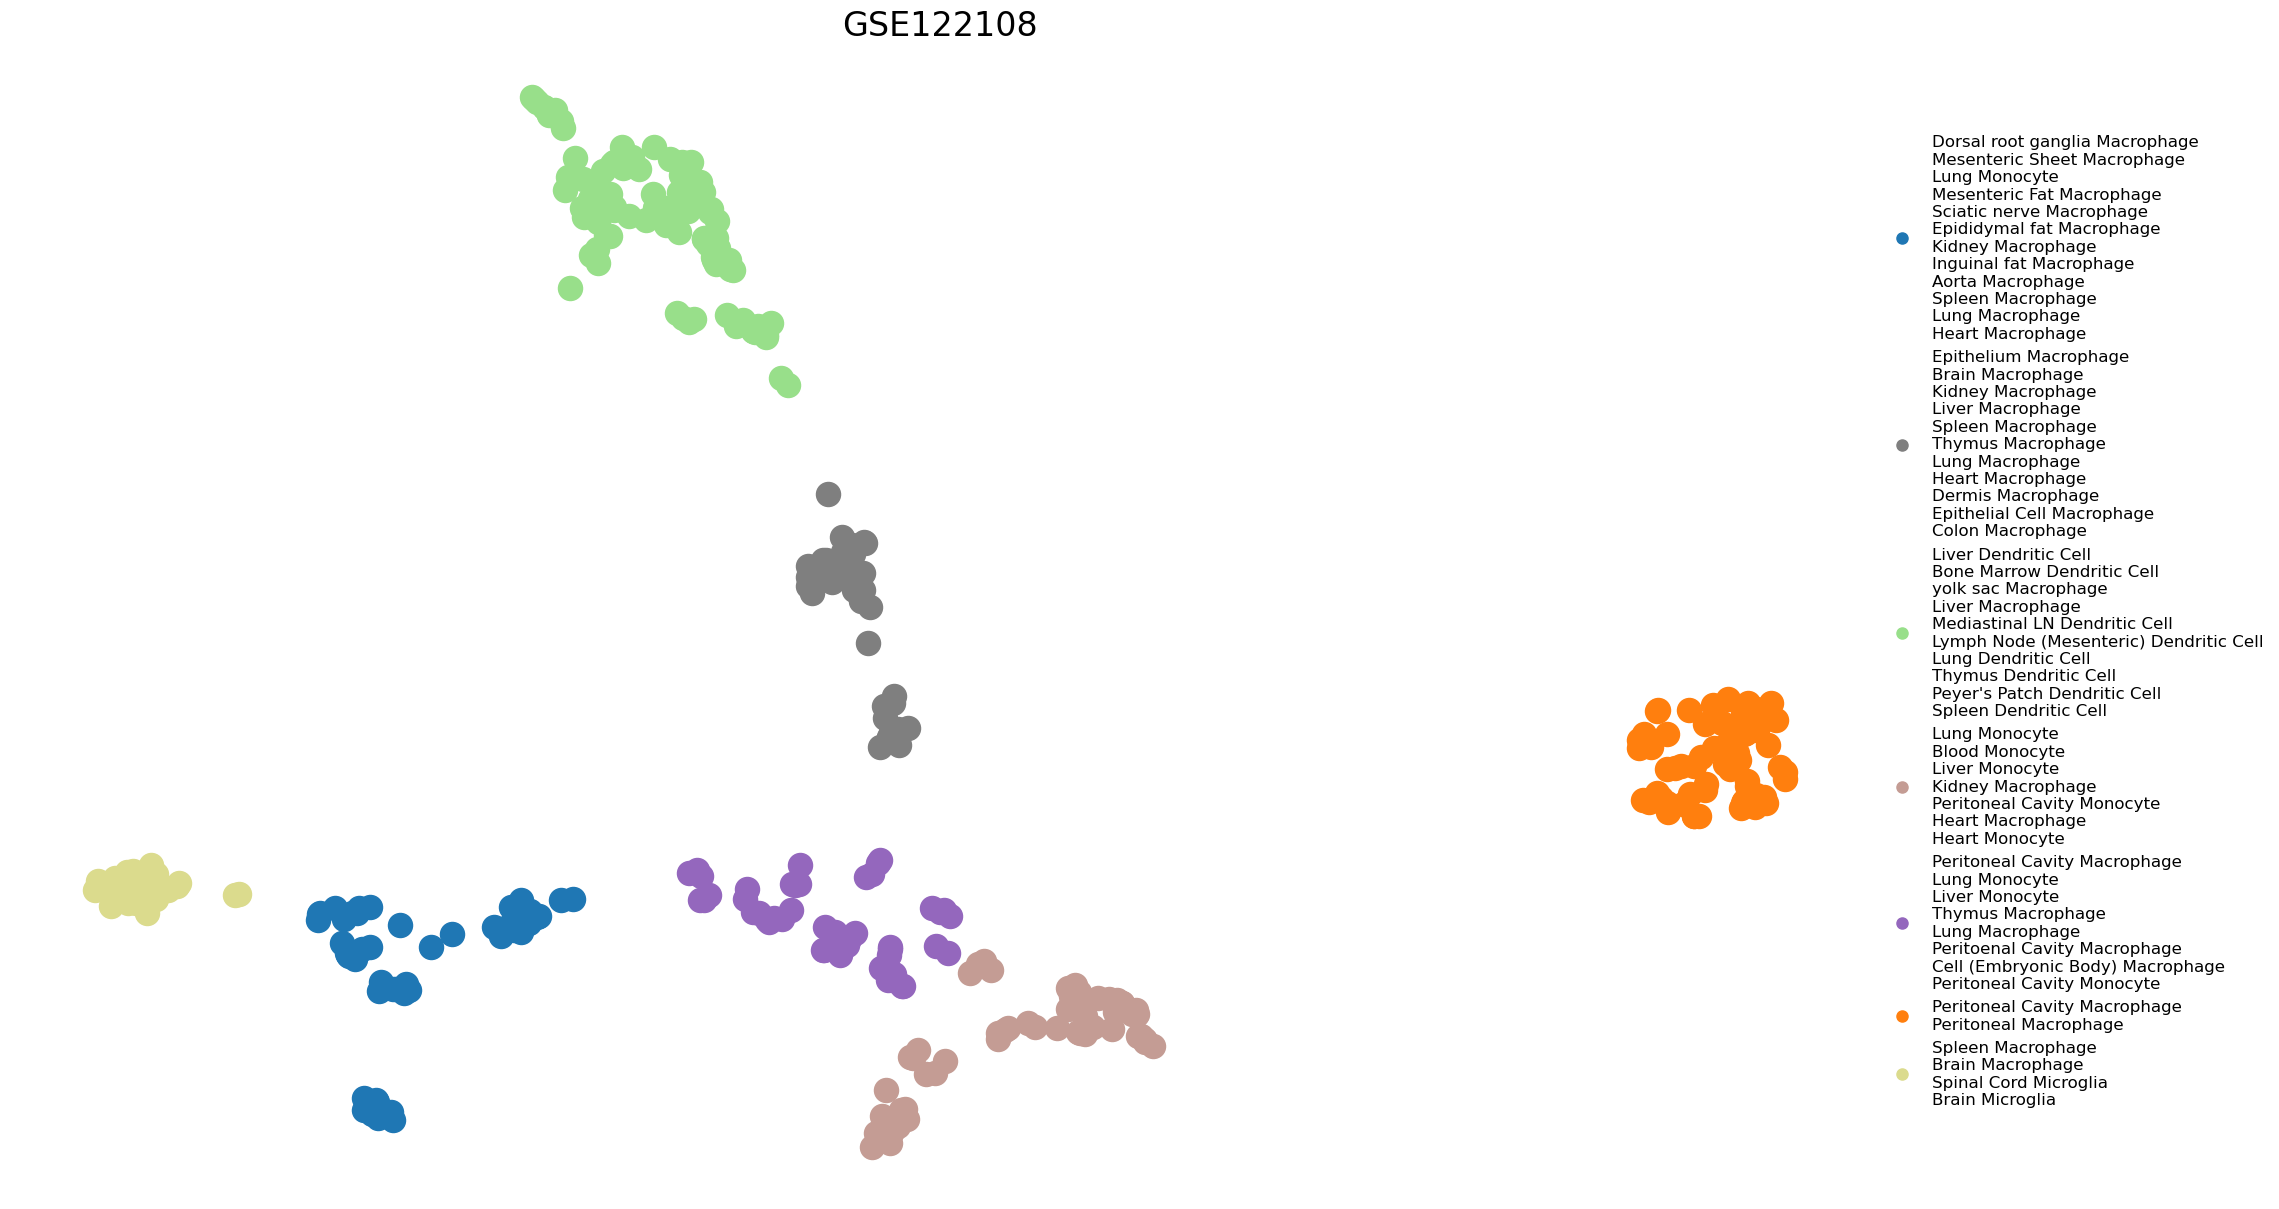

<Figure size 640x480 with 0 Axes>

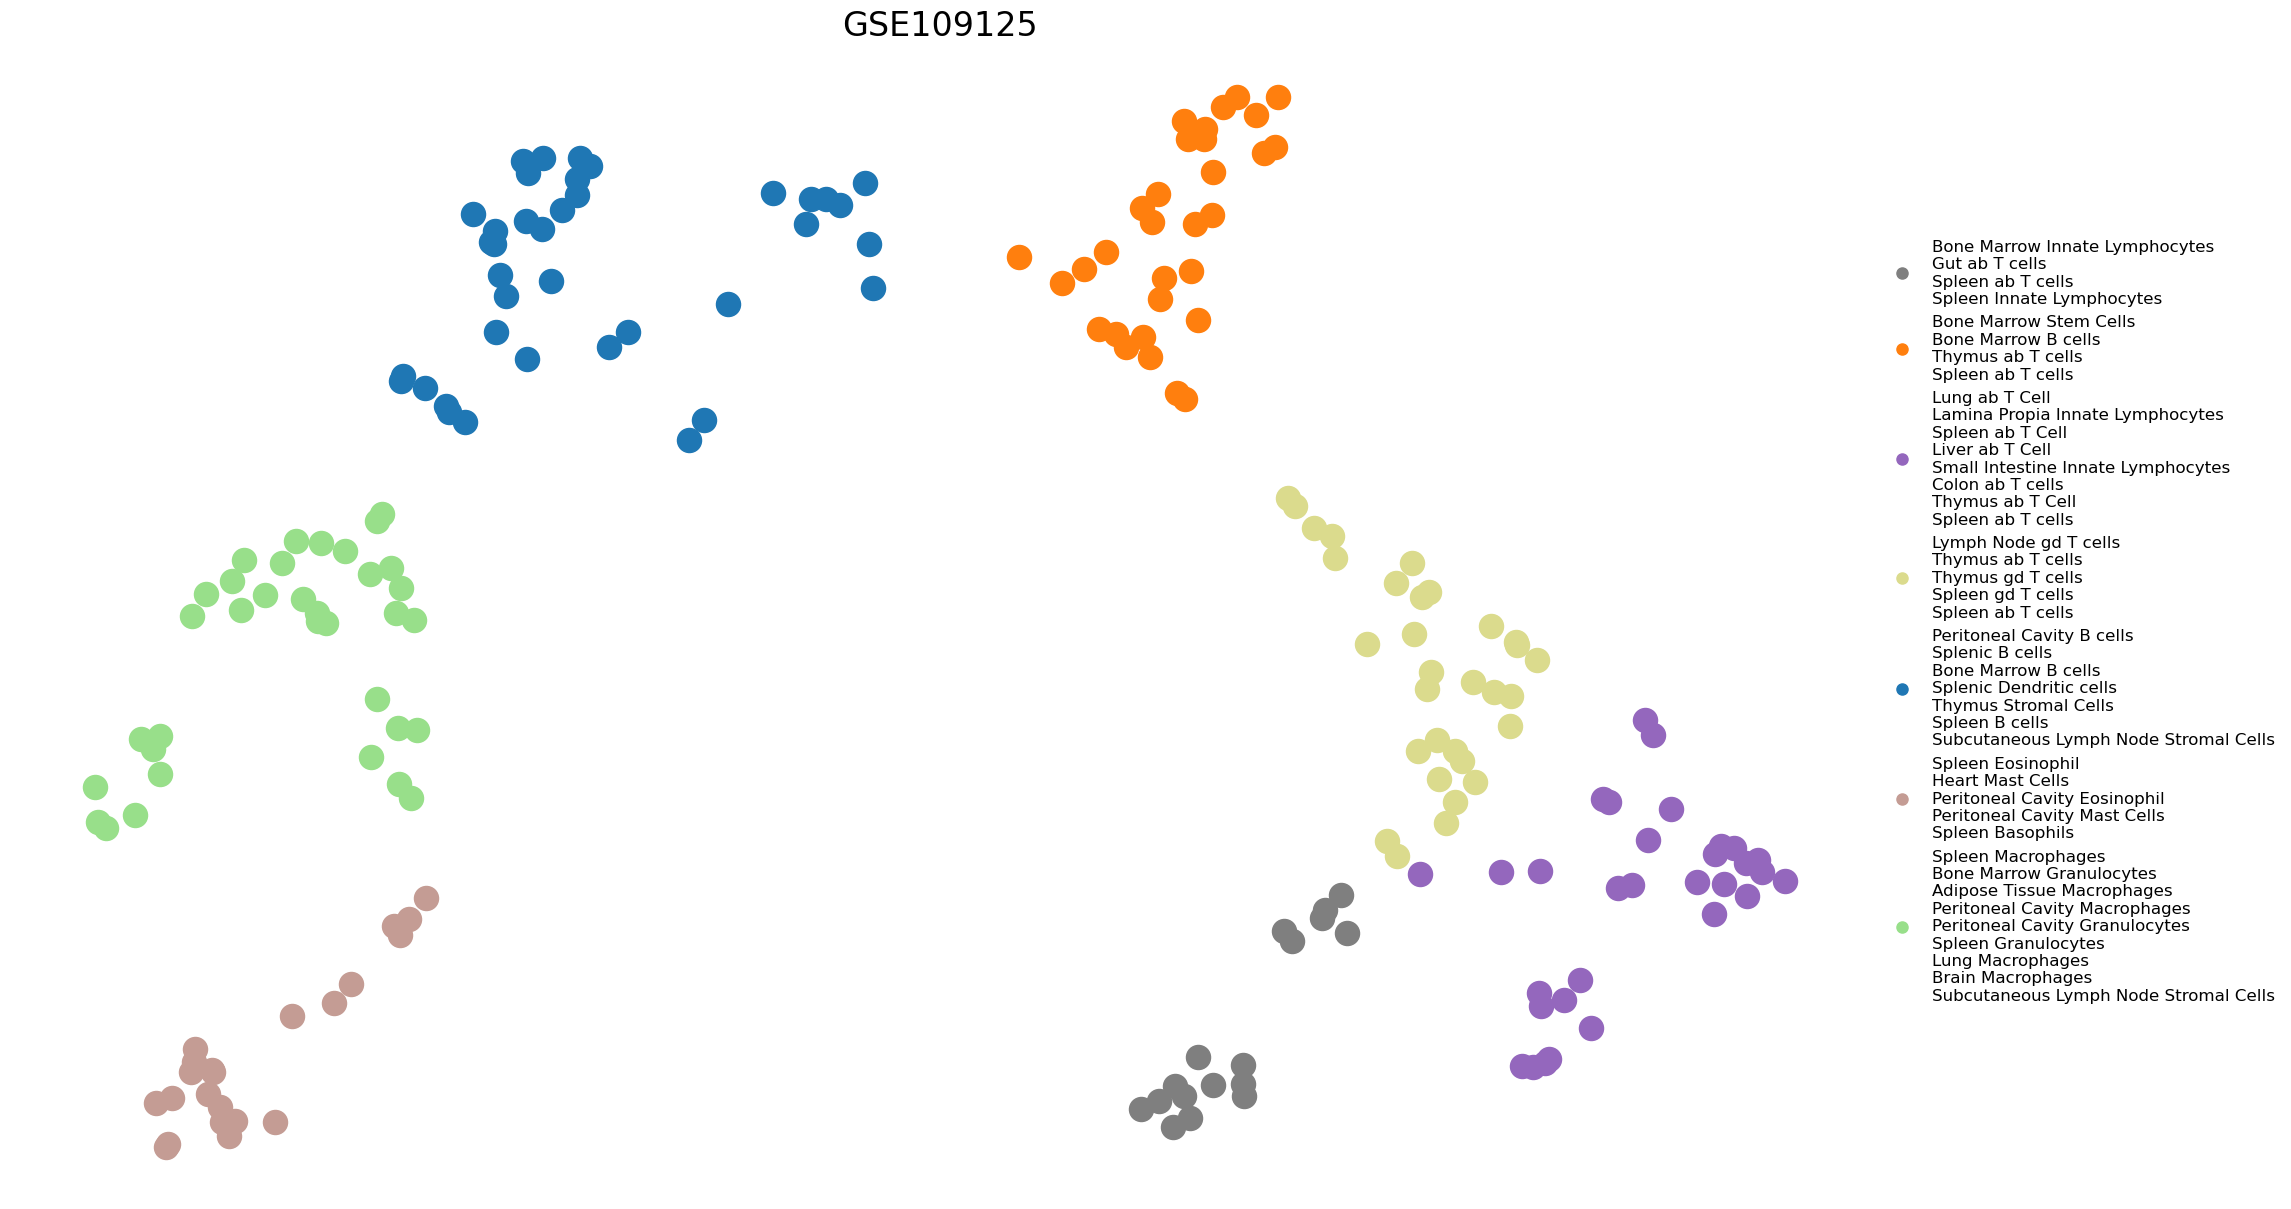

In [14]:
def print_umap_with_kmean_clusters(samples, embedding, dataset, n_clusters = False, cmap='tab10', samples_in_legend = True,  sorted_legend = True, 
                                   marker_size = 100, legend = "upper right", legend_fontsize = 12, factor = 2, ax = None, file_name = "", 
                                   title = "", legend_labels = "cell_types", label_separator = "\n", n_markers=1, min_namelength = 3):
    
    kmeans_labels = KMeans(n_clusters= n_clusters if n_clusters else optimize_kmean_clusters(samples, embedding, factor = factor), random_state = 42).fit_predict(embedding)
 
    kmean_cluster_samples = {}
    
    # Output from KMeans function is a list of the cluster indexes in the same dimension as the input
    # Here we assign the cluster index back to the samples
    for i,cluster_index in enumerate(kmeans_labels):
        if cluster_index not in kmean_cluster_samples:
            kmean_cluster_samples[cluster_index] = []
        kmean_cluster_samples[cluster_index].append(samples[i])



        
    if samples_in_legend:
        kmean_cluster_labels = {}
        
        if legend_labels != "sample_names":
            sampledata = pd.read_csv(DATAPATH + "data/" + dataset + "_Samples.txt", index_col = 0, header = 0, sep='\t')
            kmean_cluster_labels = {}
            for cluster in kmean_cluster_samples.values():
                kmean_cluster_label = label_separator.join(set([((sampledata.loc["!Sample_source_name_ch1",sample] + " ") if legend_labels == "long_cell_types" else "") + sampledata.loc["!Sample_characteristics_ch5",sample] for sample in cluster if sample in sampledata.columns]))
                unique_kmean_cluster_label = kmean_cluster_label
                n = 2
                while unique_kmean_cluster_label in kmean_cluster_labels:
                    unique_kmean_cluster_label = kmean_cluster_label + " " + str(n)
                    n += 1
                kmean_cluster_labels[unique_kmean_cluster_label] = cluster
        else:
            # Attempt to find the shortest names of the samples in a cluster to the point where each cluster still has a unique name
            # E.g.: Clusters ["MF.1", "MF.2", ...] and ["Mo.1", "Mo.2", ...] will get the labels "MF" and "Mo"
            n = min_namelength
            while len(kmean_cluster_labels) != len(kmean_cluster_samples):
                kmean_cluster_labels = {label_separator.join(set([x[0:n] for x in v])):v for v in kmean_cluster_samples.values()} 
                n += 1
    else:
        kmean_cluster_labels = {str(i):cluster_samples for i,cluster_samples in enumerate(kmean_cluster_samples.values())}
        
    kmean_cluster_list,kmean_cluster_colors = print_umap(samples, embedding, kmean_cluster_labels, legend_fontsize = legend_fontsize, title = title, 
                                                         marker_size = marker_size, sorted_legend = sorted_legend, legend = legend, cmap=cmap, ax = ax, n_markers=n_markers, file_name = file_name)
    
    return (kmean_cluster_labels,kmean_cluster_list,kmean_cluster_colors)

# UMAP_DATA_CELL_CLUSTERS is a dictionary containing a 3-item tuple for each dataset:
# (1) Dictionary with cluster label and the list of associated samples
# (2) A list of samples lists for each cluster (the same as list((1).values())) 
    # --> the index of the clusters in the list corresponds to the legend text in the figure
# a dictionary containing the colors for each cluster-index
UMAP_DATA_KMEAN_CLUSTERS = {dataset:print_umap_with_kmean_clusters(list(EXPRESSION_DATA[dataset].columns), UMAP_EMBEDDING[dataset], dataset, legend_labels = "long_cell_types", title = dataset, n_clusters = 7, n_markers=1, samples_in_legend = True, marker_size = 300, cmap = "tab20", legend = "outside", file_name = "UMAP_kmean_clusters_" + dataset) for dataset in GSE_DATASETS[:2]}

# Topological Network Analysis

## Find LPM Synthesis Paths

In [15]:
def random_walks(dataset, samples = False, n = 100, stim_duration = 20):

    random_walk_scores = {lpm_class:{} for lpm_class in LPM_CLASSES}
    samples = samples if samples else DATA_SAMPLES[dataset]
    
    outdegree = {node: len([edge for edge in EDGES if edge["source"] == node]) for node in NODE_IDS}
    indegree = {node: len([edge for edge in EDGES if edge["target"] == node]) for node in NODE_IDS}
    
    for i,sample in enumerate(samples):

        print_progress_bar(i, len(samples))
        
        nodes = set([node for node in NODE_IDS if (is_expressed(node, sample, dataset, filtering = "all"))])
        extended_nodes = nodes.union(LPM_GENES)

        # dictionary of edges
        edges = {node: {} for node in extended_nodes}  
        for target, source, from_submap in [(edge["target"], edge["source"], edge["submap"]) for edge in EDGES]:
            if not from_submap:
                if set([target, source]) < nodes or (target in LPM_GENES and source in nodes):
                    edges[target][source] = NODES[source]["norm_read_counts"][dataset][sample]

        for lpm_class in LPM_CLASSES:
            
            enzymes = {enzyme:ENZYME_SCORES[lpm_class][enzyme] for enzyme in lpm_class_genes(lpm_class)}
            current_activity = enzymes     
            
            node_activities =  {node:[current_activity[node] if node in current_activity else 0] for node in nodes}
            
            for t in range(n):
                new_activity = {}
                
                for node,node_activity in current_activity.items():
                    for source,read_count in edges[node].items():
                        if source not in new_activity:
                            new_activity[source] = 0
                        new_activity[source] += current_activity[node] * read_count / (math.sqrt(outdegree[source])*math.sqrt(indegree[node]))                       
                                
                current_activity = new_activity   

                for enzyme, score in enzymes.items():
                    current_activity[enzyme] = score if stim_duration > t else 0
                
                for node in nodes:
                    node_activities[node].append(current_activity[node] if node in current_activity else 0)                
                
            random_walk_scores[lpm_class][sample] = {node: metrics.auc(range(n+1),node_activities[node]) if node not in enzymes else 0 for node in nodes}            

        print_progress_bar(i+1, len(samples)) 
        
    return random_walk_scores

In [16]:
# Cell-specific de novo LPM bioynthesis paths based on the expression of enzymes (only submaps)
LPM_SYNTHESIS_PATHS = {dataset:cell_bfs(dataset, starting_nodes = LPM_CLASSES, reverse= True, filtering = "not genes",
                                        only_expressed_starting_nodes = False, only_submap = True) for dataset in GSE_DATASETS}
LPM_SYNTHESIS_PATHS_001 = {dataset:cell_bfs(dataset, threshold = 0.001, starting_nodes = LPM_CLASSES, reverse= True, filtering = "not genes",
                                            only_expressed_starting_nodes = False, only_submap = True) for dataset in GSE_DATASETS}

PIM_CLASSES = [lpm_class for lpm_class in LPM_CLASSES if any([pim_label in NODES[lpm_class]["name"].lower() for pim_label in ["prostaglandin", "thromboxan", "leukotrien"]])]
SPM_CLASSES = [lpm_class for lpm_class in LPM_CLASSES if any([spm_label in NODES[lpm_class]["name"].lower() for spm_label in ["resolvin", "lipoxin", "maresin", "protectin"]])]

PIM_GENES = list(set(sum([lpm_class_genes(lpm_class) for lpm_class in PIM_CLASSES], [])))
SPM_GENES = list(set(sum([lpm_class_genes(lpm_class) for lpm_class in SPM_CLASSES], [])))
LPM_GENES = list(set(PIM_GENES + SPM_GENES))

PIM_UNIQUE_GENES = [gene for gene in PIM_GENES if gene not in SPM_GENES]
SPM_UNIQUE_GENES = [gene for gene in SPM_GENES if gene not in PIM_GENES]

# Cell-specific paths regulating enzymes in LPM biosynthesis (whole network)
# # TF_PATHS_TO_ENZYMES = {dataset:cell_bfs(dataset, starting_nodes = LPM_GENES, reverse= True, only_expressed_starting_nodes = False, only_submap = False) for data in EXPRESSION_DATA for dataset in GSE_DATASETS}

if reload_data:
    TF_RANDOM_WALK_SCORES = {dataset:random_walks(dataset) for dataset in GSE_DATASETS}
    with open('TF_RANDOM_WALK_SCORES.pkl', 'wb') as f:
        pickle.dump(TF_RANDOM_WALK_SCORES, f)
else:
    with open('TF_RANDOM_WALK_SCORES.pkl', 'rb') as f:
        TF_RANDOM_WALK_SCORES = pickle.load(f)

Progress |██████████████████████████████████████████████████| 100.0% Complete
Progress |██████████████████████████████████████████████████| 100.0% Complete
Progress |██████████████████████████████████████████████████| 100.0% Complete
Progress |██████████████████████████████████████████████████| 100.0% Complete


In [17]:
# Find cells that allow the synthesis of a specified LPM class
def samples_with_lpm_path(lpm_class, dataset):
    return [sample for sample in DATA_SAMPLES[dataset] 
                if any([node in LPM_SYNTHESIS_PATHS_001[dataset][sample]["sp_length"][lpm_class] and LPM_SYNTHESIS_PATHS_001[dataset][sample]["sp_length"][lpm_class][node] > 0 
                        for node in [get_node_from_name(name) for name in ["AA", "DHA", "EPA"]]])]

### Cell-Specific Path Heatmap

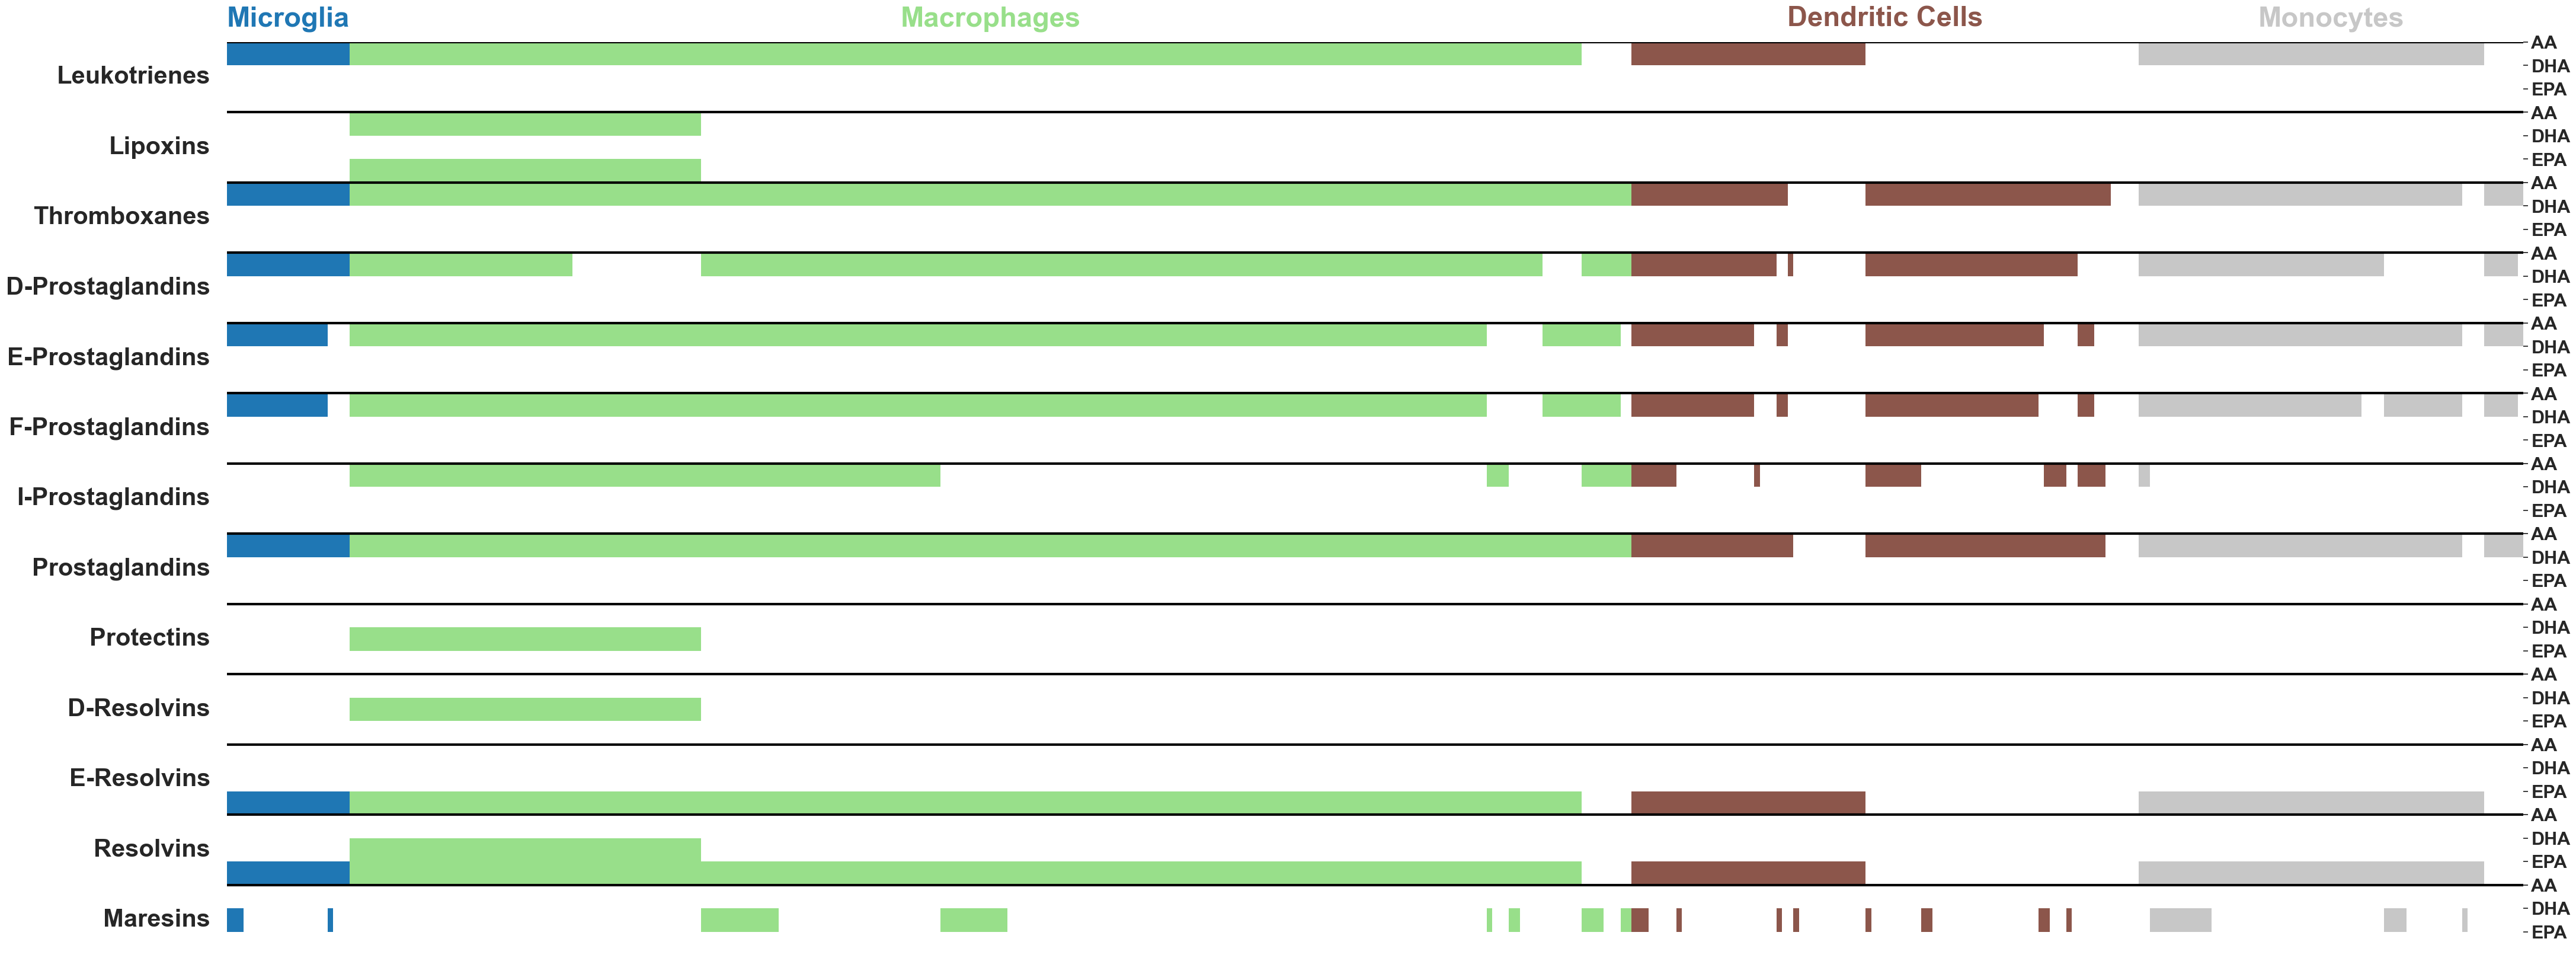

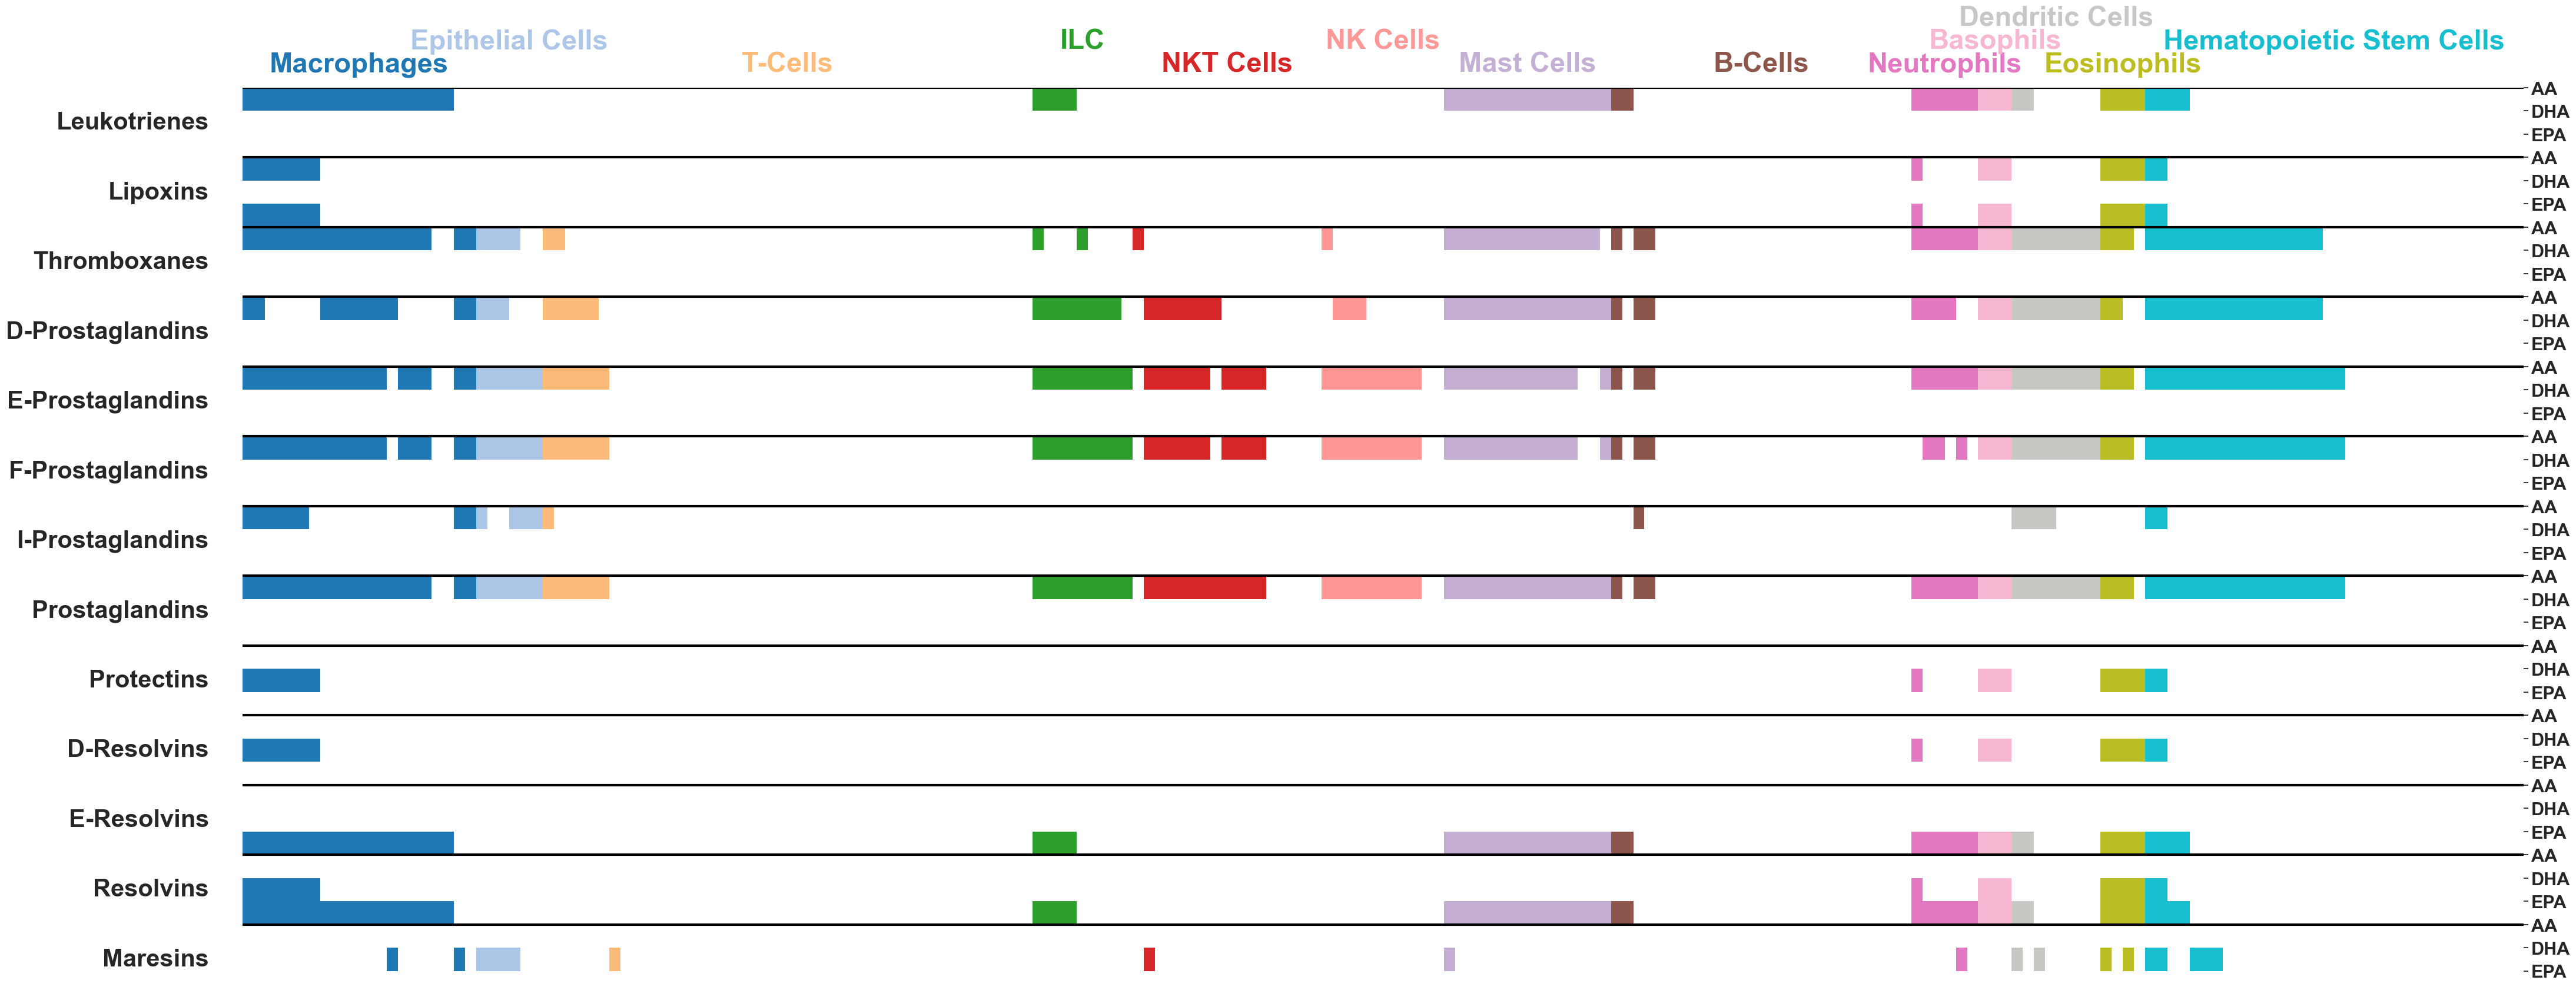

In [18]:
def lpm_path_plot(dataset, file_name = '', adjust = False, position = {}):
    
    plt.close()
    
    substrates = ["AA", "DHA", "EPA"]
    lm_order = ["leukotriene", "lipoxin", "thromboxan", "prostaglandin", "protectin", "resolvin", "maresin"]
    substrate_index = {
        "AA": 1,
        "DHA": 2,
        "EPA": 3,
    }

    plt.rcParams["figure.figsize"] = (50,20)
    cmap = plt.get_cmap("tab20").copy()
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', list(UMAP_DATA_CELL_CLUSTERS[dataset][2].values()))
    cmap.set_bad(color='white', alpha=1)
    data = {}

    node_list = []
    selected_cell_types = set()
    
    sorted_lpm_classes = sorted(LPM_CLASSES, key = lambda lpm_class: NODES[lpm_class]["name"])
    sorted_lpm_classes = sorted(sorted_lpm_classes, key = lambda lpm_class: [i for i,label in enumerate(lm_order) if label in NODES[lpm_class]["name"].lower()][0])
    lpm_class_names = [NODES[lpm_class]["name"] for lpm_class in sorted_lpm_classes]

    clustered_sample_list = sum(UMAP_DATA_CELL_CLUSTERS[dataset][1], [])
    samples_sorting_string = {sample: "" for sample in clustered_sample_list}
    
    results = {}
    
    for lpm_class in sorted_lpm_classes:
        for substrate in substrates:
            substrate_node_id = get_node_from_name(substrate)
            data[lpm_class + "_" + substrate] = []
            for sample in clustered_sample_list:
                cluster_position = math.nan
                for cluster_id,samples_in_cluster in enumerate(UMAP_DATA_CELL_CLUSTERS[dataset][1]):
                    if sample in samples_in_cluster:
                        cluster_position = cluster_id
                        break

                if samples_sorting_string[sample] == "":
                    samples_sorting_string[sample] += string.ascii_letters[cluster_position]
                
                if substrate_node_id in LPM_SYNTHESIS_PATHS_001[dataset][sample]["sp_length"][lpm_class] and LPM_SYNTHESIS_PATHS_001[dataset][sample]["sp_length"][lpm_class][substrate_node_id] > 0:
                    data[lpm_class + "_" + substrate].append(cluster_position)
                    if sample not in results:
                        results[sample] = []
                    results[sample].append(lpm_class + "_" + substrate)
                    samples_sorting_string[sample] += "0"
                else:
                    data[lpm_class + "_" + substrate].append(math.nan)
                    samples_sorting_string[sample] += "1"

    data = pd.DataFrame(data, columns = data.keys() , index=clustered_sample_list)
    samples_sorting_string = sorted(samples_sorting_string.items(), key = lambda x: x[1])
    sorted_samples = [k for k,v in samples_sorting_string]
    samples_with_same_string = {}
    for k,v in samples_sorting_string:
        if v not in samples_with_same_string:
            samples_with_same_string[v] = []
        samples_with_same_string[v].append(k)
    data = data.reindex(sorted_samples)
    font = {
            'weight' : 'bold',
            'size'   : 20}
    plt.rc('font', **font)
    seaborn.set(font_scale = 2)
    sns_plot = seaborn.heatmap(data.T, cmap=cmap, linecolor="grey", linewidth=0, square = False, cbar = False)
    seaborn.axes_style('white')
    # horizontal line seperating the LPM classes
    for y in [index * 3 for index in range(0, len(LPM_CLASSES))]:
        plt.axhline(y=y, color='black', linewidth=3)
    x_position = 0
    for i, (label, samples) in enumerate(UMAP_DATA_CELL_CLUSTERS[dataset][0].items()):
        plt.text(x_position + len(samples)/2, (-1 if i%2 == 0 or adjust == False else -2) if i not in position else position[i], label, va='center', horizontalalignment='center', fontweight = "bold", fontsize=34, color = UMAP_DATA_CELL_CLUSTERS[dataset][2][i])
        x_position += len(samples)
        
    for i, lpm_class in enumerate(sorted_lpm_classes):
        plt.text(-3, 1.5 + (i * 3), ("-".join([x.capitalize() for x in NODES[lpm_class]["name"].replace(" synthesis", "").split()[::-1]]) + "s").replace("Thromboxans", "Thromboxanes"), va='center', horizontalalignment='right', fontsize=30)
    
    sns_plot.set_xticklabels([]) #(df.index, rotation=60, ha="right", fontsize = 15, rotation_mode='anchor')

    sns_plot.yaxis.tick_right()

    sns_plot.set_yticks(range(0,len(data.columns))) 
    sns_plot.set_yticklabels([re.sub(r'^.*?_', '', x) for x in data.columns], rotation = 0) 
    sns_plot.grid(False)
    sns_plot.yaxis.set_label_position("right")

    if file_name:
        plt.savefig(file_name + ".png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

SAMPLE_LPM_CLASSES = {dataset: lpm_path_plot(dataset, file_name = dataset + "_path_plot", adjust = True if i == 1 else False, position = {7:-1, 10:-3,11: -1, 12:-2} if i == 1 else {}) for i,dataset in enumerate(GSE_DATASETS[:2])}

### Cell-Specific Paths in Immune Cell Stimulation

In [ ]:
def eval_stim_features(dataset):
    output = {}
    stim_sample_dict = STIMULATED_SAMPLES[dataset]
    for k,(stimulus, sample_clusters) in enumerate(stim_sample_dict.items()):
        output[stimulus] = {}
        print_progress_bar(k, len(stim_sample_dict))
        for j,(label, stim_sample_list) in enumerate(sample_clusters.items()):    
            output[stimulus][label] = {i:{lpm_class:pvalue_of_features(dataset, lpm_class, samples, adjusted = True) for lpm_class in LPM_CLASSES} for i,samples in enumerate(stim_sample_list)}
        print_progress_bar(k+1, len(stim_sample_dict))
    return output

if True:
    STIM_CLUSTER_FEATURES = {dataset: eval_stim_features(dataset) for dataset in GSE_DATASETS}
    with open('STIM_CLUSTER_FEATURES.pkl', 'wb') as f:
        pickle.dump(STIM_CLUSTER_FEATURES, f)
else:
    with open('STIM_CLUSTER_FEATURES.pkl', 'rb') as f:
        STIM_CLUSTER_FEATURES = pickle.load(f)

Progress |██████████████████████████████████████████████████| 100.0% Complete


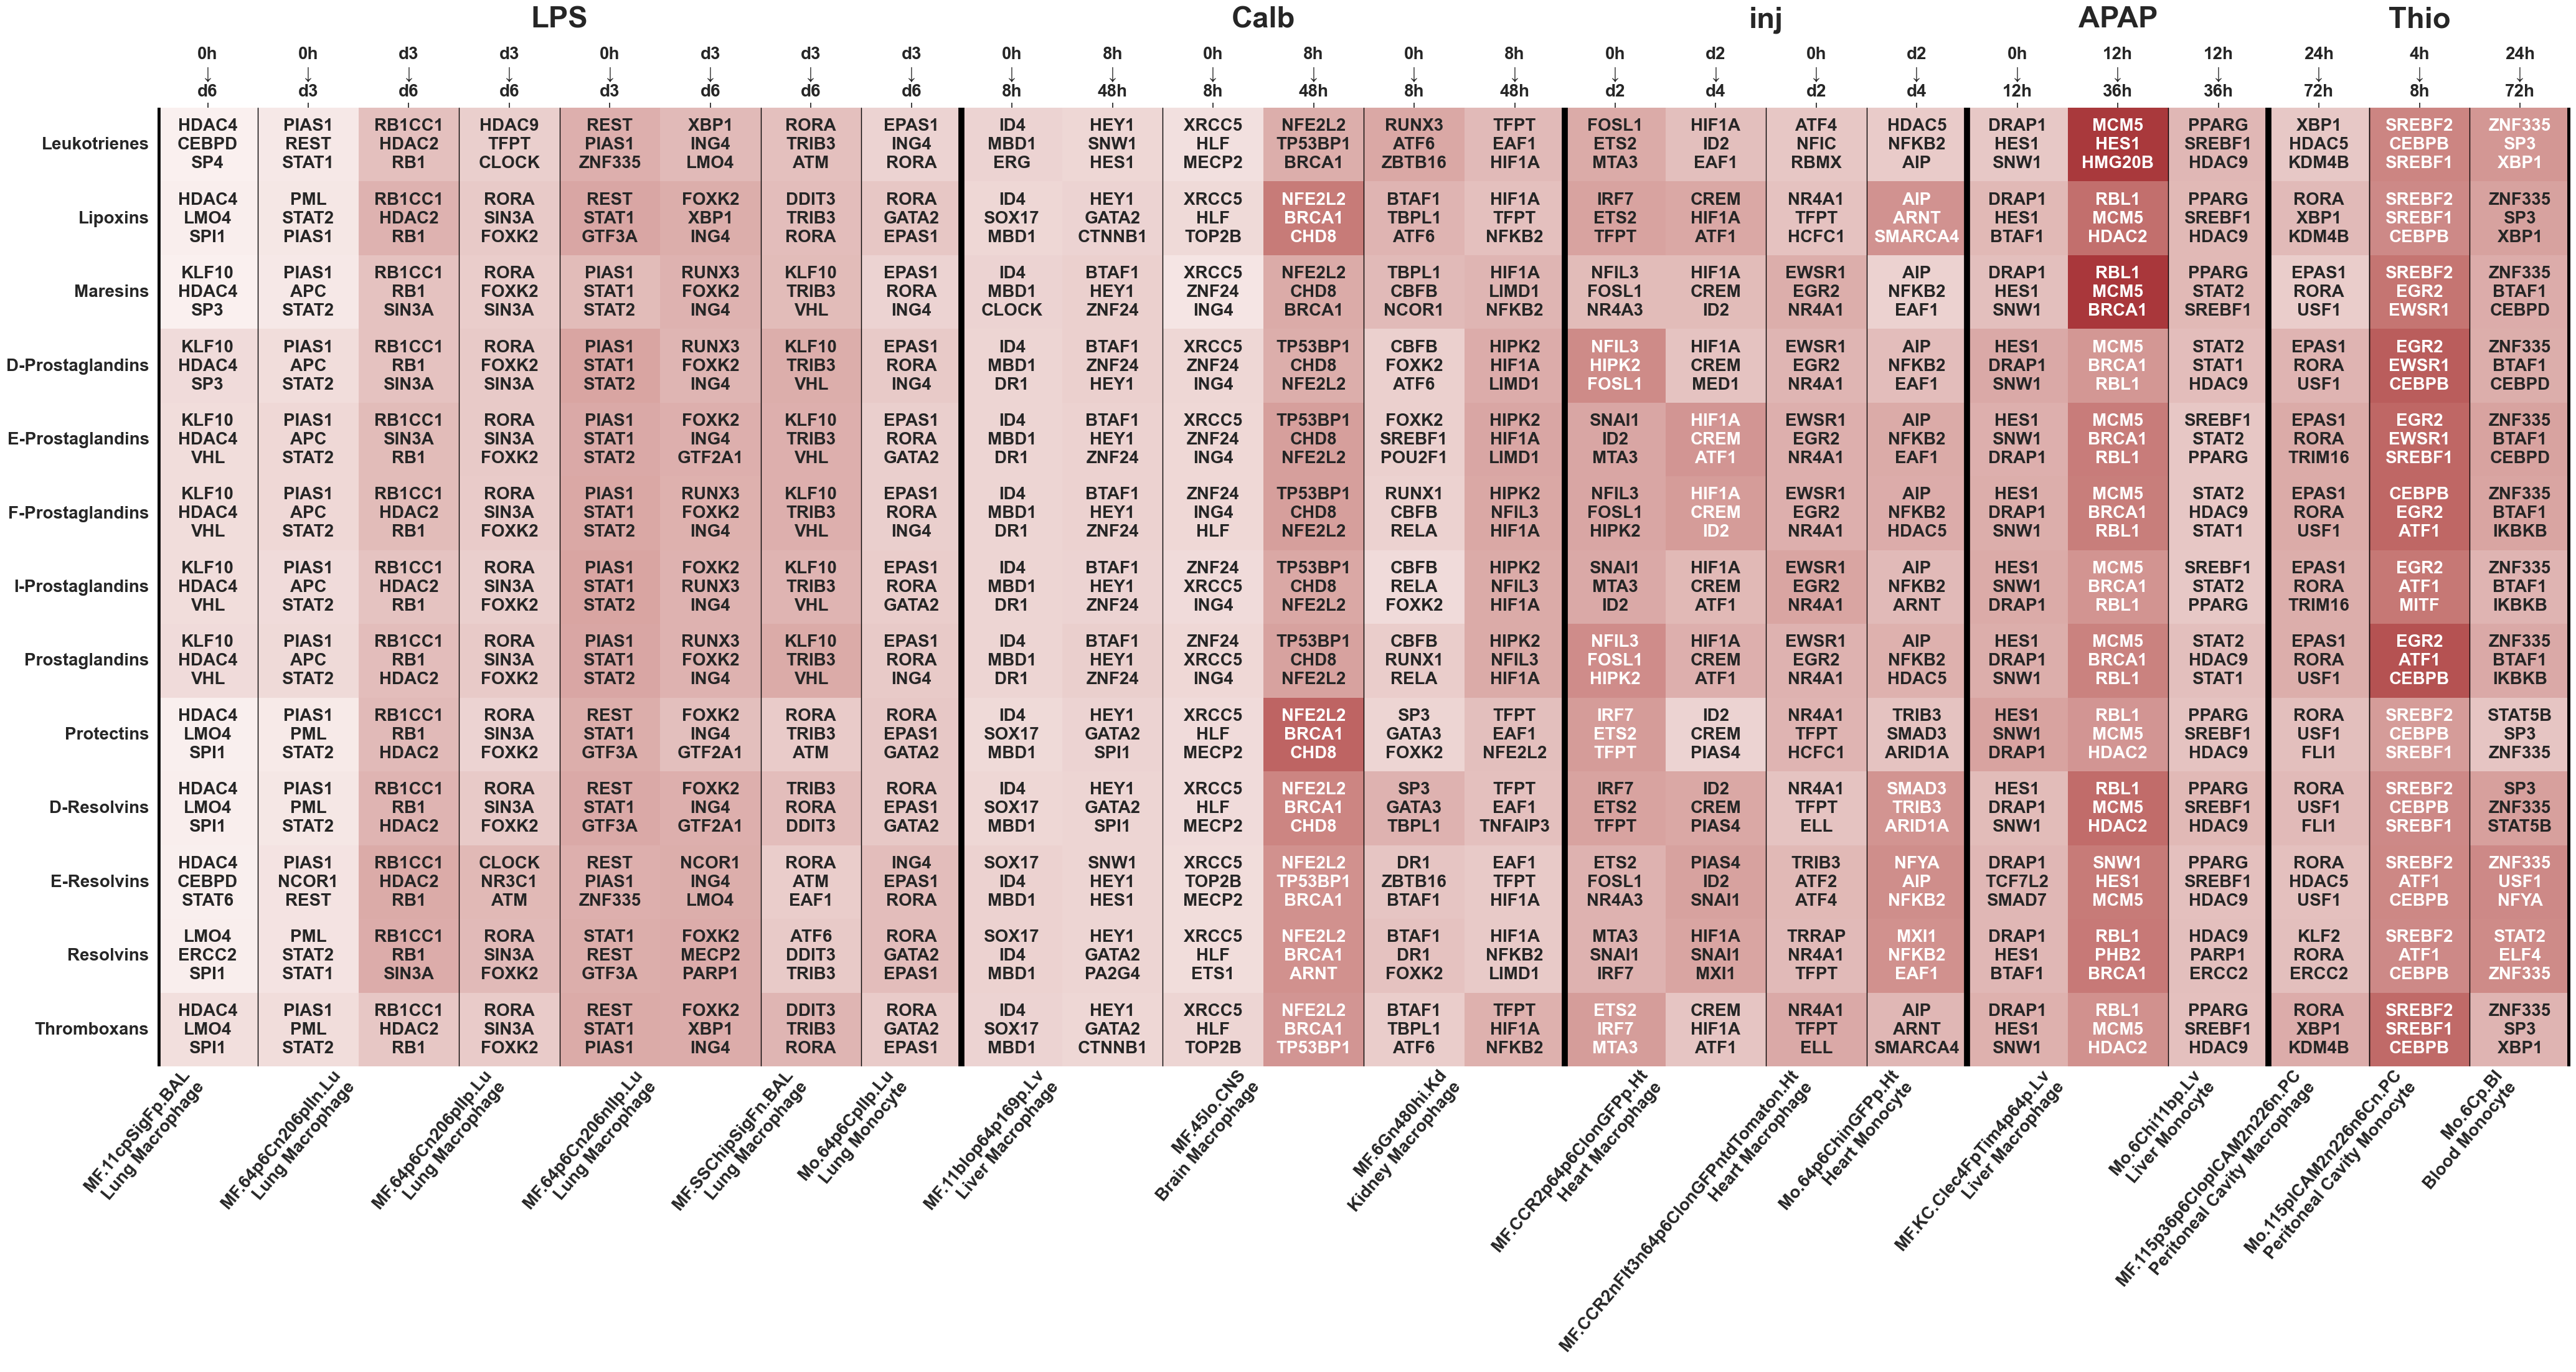

Progress |██████████████████████████████████████████████████| 100.0% Complete


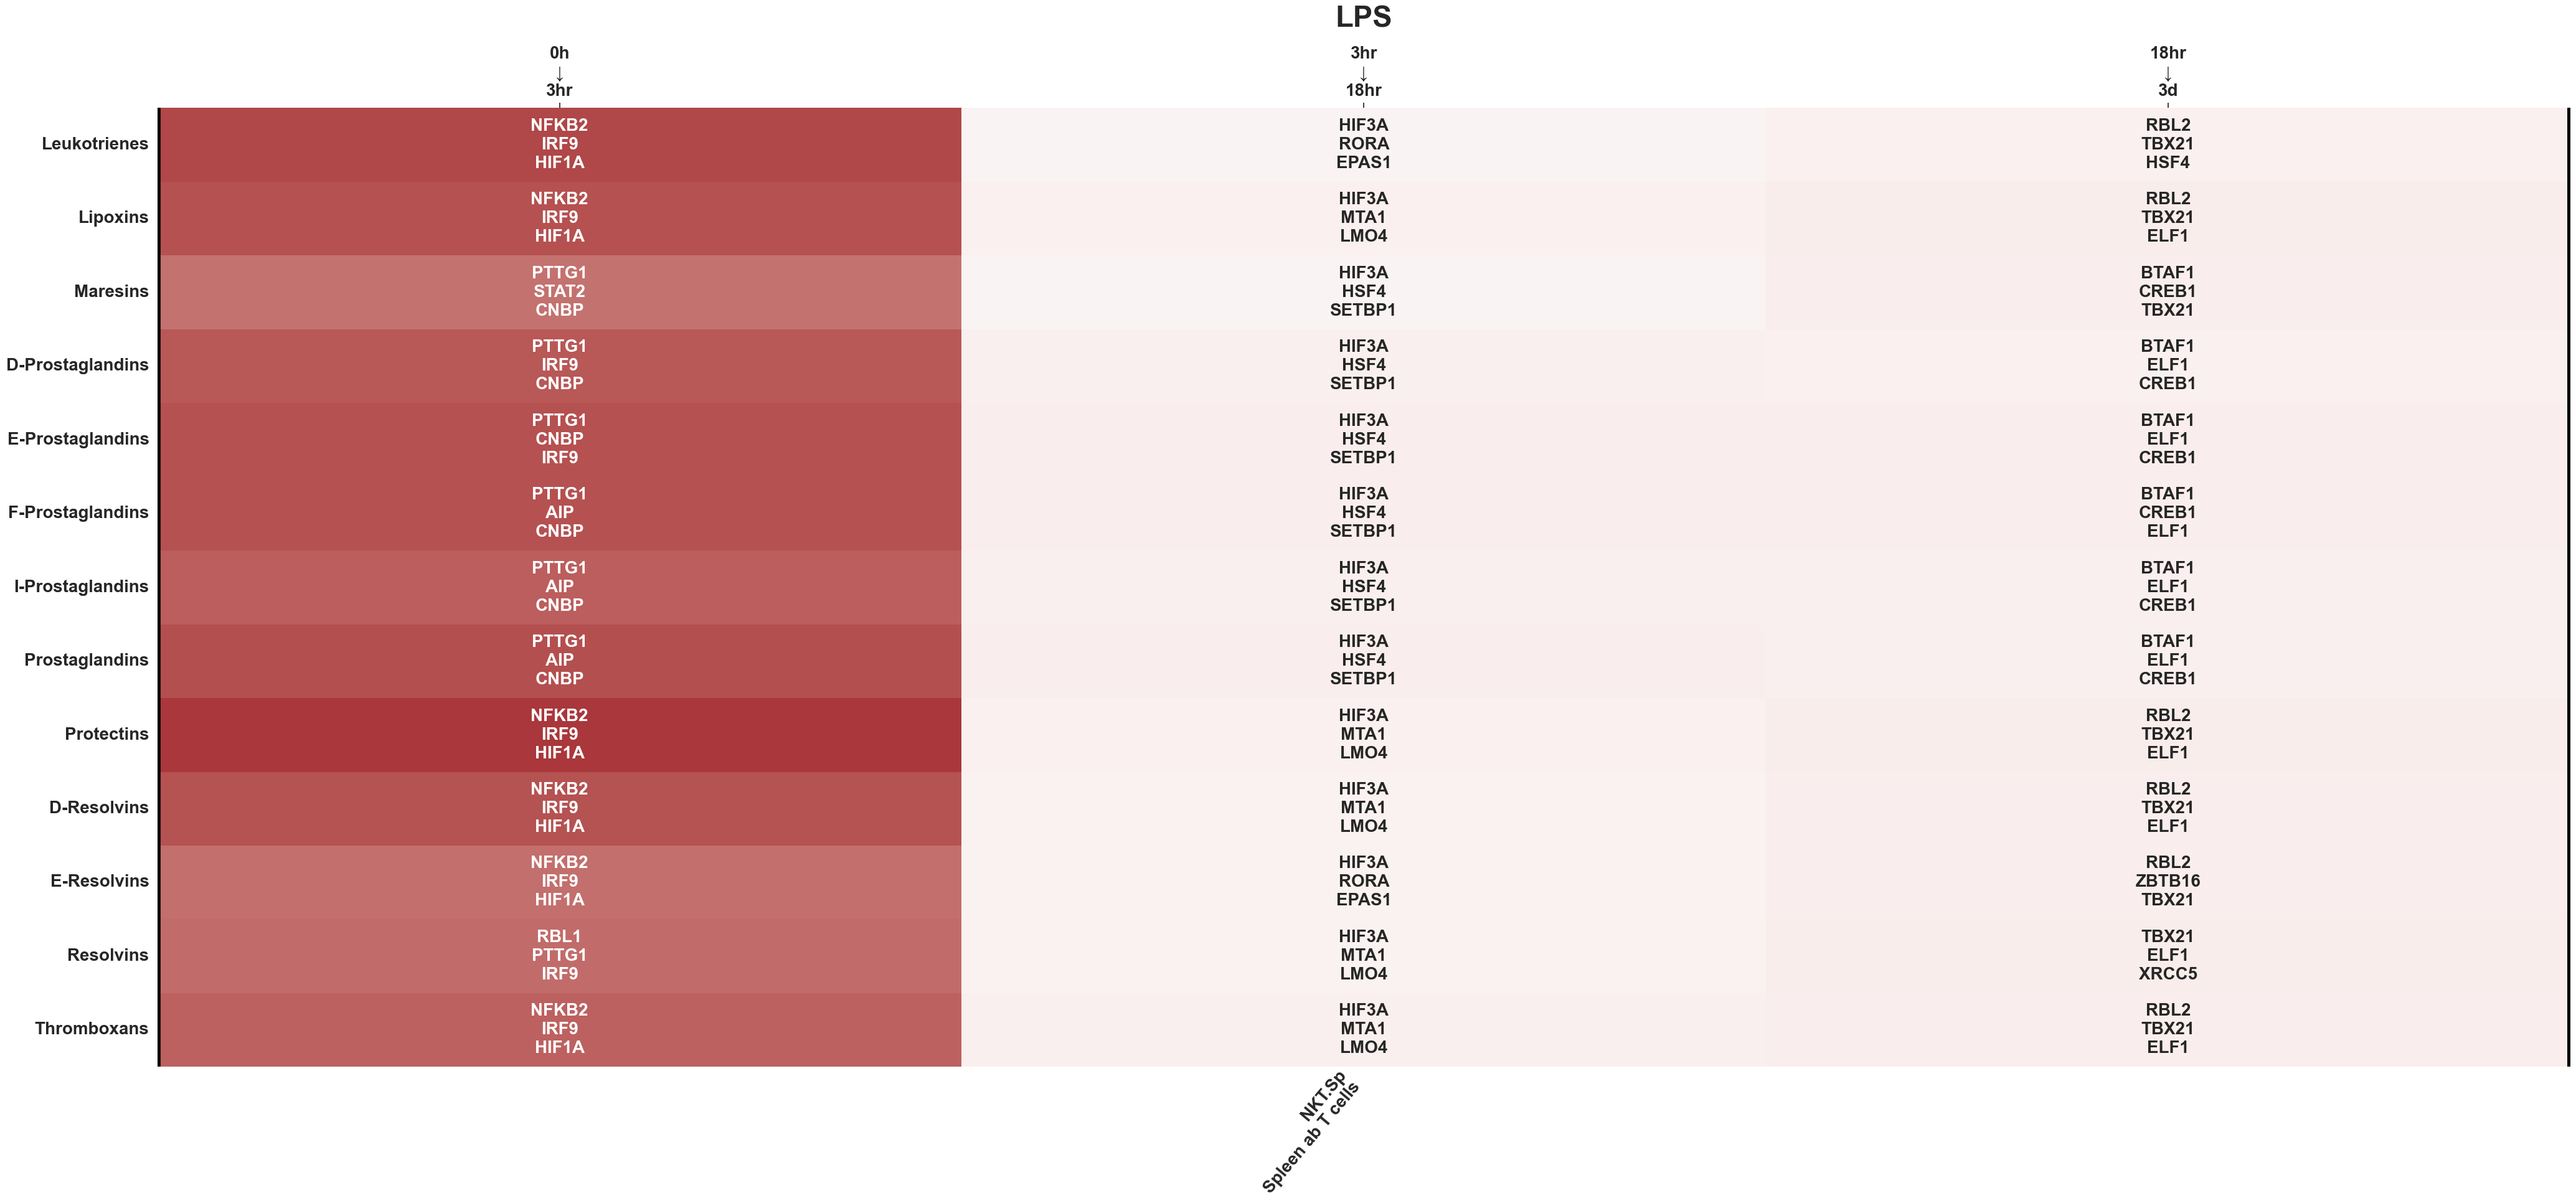

[None, None]

In [71]:
def lpm_stim_path_plot(dataset, file_name = ''):    
    plt.close()
    
    lpm_gene_activation = {enzyme: {"pos":[], "neg":[]} for enzyme in LPM_GENES}
    
    stim_sample_dict = STIMULATED_SAMPLES[dataset]
    
    plt.rcParams["figure.figsize"] = (50,20)
    cmap = plt.get_cmap("vlag").copy()
    cmap.set_bad(color='white', alpha=1)
    _data = {}
    xlabels = []
    ylabels = []

    lpm_samples = {lpm_class: samples_with_lpm_path(lpm_class, dataset) for lpm_class in LPM_CLASSES}
    lpm_labels = {lpm_class: "-".join([name_str.capitalize() for name_str in NODES[lpm_class]["name"].replace(" synthesis", "").split()[::-1]]) + "s" for lpm_class in sorted(LPM_CLASSES, key = lambda lpm_class: NODES[lpm_class]["name"])}
    lpm_genes = {lpm_class: lpm_class_genes(lpm_class) for lpm_class in LPM_CLASSES}
    
    data = {lpm_label: [] for lpm_label in lpm_labels.values()}
    
    xlabels = []
    annotation_labels = [[] for i in range(len(LPM_CLASSES))]

    times = ["6 days", "48h", "day 2", "72h", "8h", "36h"]
    counter = 0

    sampledata = pd.read_csv(DATAPATH + "data/" + dataset + "_Samples.txt", index_col = 0, header = 0, sep='\t')

    normalized_lpm_faetures = NORMALIZED_LPM_FEATURES[dataset]
    for k,(stimulus, sample_clusters) in enumerate(stim_sample_dict.items()):
        
        print_progress_bar(k, len(stim_sample_dict))
        
        plt.axvline(x=counter, color='black', linewidth=7)
        stim_counter = counter
        for label, stim_sample_list in sample_clusters.items():
            cell_counter = counter
            plt.axvline(x=counter, color='black', linewidth=1)
            
            for i,samples in enumerate(stim_sample_list):
                if i < len(stim_sample_list) - 1:  
                    for j,lpm_class in enumerate(LPM_CLASSES):

                        
#                         control_features = STIM_CLUSTER_FEATURES[dataset][stimulus][label][i][lpm_class]
#                         stim_features = STIM_CLUSTER_FEATURES[dataset][stimulus][label][i+1][lpm_class]
                        
#                         feature_diff = {node:(stim_features[node][1] if node in stim_features and stim_features[node][0] < 0.05 else 0) - 
#                                              (control_features[node][1] if node in control_features and control_features[node][0] < 0.05 else 0) 
#                                         for node in NODE_IDS}
                        
                        feature_diff = (normalized_lpm_faetures[lpm_class][stim_sample_list[i+1]].mean(axis=1)
                                        .subtract(normalized_lpm_faetures[lpm_class][samples].mean(axis=1)))
                
                        feature_diff = feature_diff[feature_diff > 0].to_dict()

                        # data[lpm_labels[lpm_class]].append(sum([x for x in feature_diff.values() if np.isnan(x) == False and x > 0]))
                        
                        data[lpm_labels[lpm_class]].append(sum(feature_diff.values()))
                        feature_diff = sorted(feature_diff.items(), key = lambda x: x[1], reverse = True)[:3]
                        annotation_labels[j].append("\n".join([NODES[node[0]]["name"] for node in feature_diff]))                            
                        
                    xlabels.append("\n↓\n".join([sample.split(stimulus)[1].split(".")[1] if stimulus in sample else "0h" for sample in [samples[0], stim_sample_list[i+1][0]]]))#"→"
                    counter += 1
            
            cluster_label = label + "\n" + " & ".join(set([ sampledata.loc["!Sample_source_name_ch1",sample] + " " + sampledata.loc["!Sample_characteristics_ch5",sample] for sample in stim_sample_list[0]]))
            
            try:
                cluster_label = cluster_label.replace(stimulus + ".", "")
                cluster_label = cluster_label.replace("." + cluster_label.split(stimulus)[1].split(".")[1], "")
            except:
                pass
            
            # if len(cluster_label) > 13:
            #     cluster_label = cluster_label[:13] + "..."
                
            if cell_counter != counter:
                plt.text(cell_counter + (counter - cell_counter)/2, len(LPM_CLASSES), cluster_label, va='top', horizontalalignment='right', rotation = 50, fontweight = "bold", fontsize=20)
            
        print_progress_bar(k+1, len(stim_sample_dict))
        
        if stim_counter != counter:
            plt.text(stim_counter + (counter - stim_counter)/2, -1.2, stimulus, va='center', horizontalalignment='center', fontweight = "bold", fontsize=34)
        
    df = pd.DataFrame(data, columns = data.keys() , index=xlabels)

    font = {
            'weight' : 'bold',
            'size'   : 20}
    plt.rc('font', **font)
    seaborn.set(font_scale = 2)
    sns_plot = seaborn.heatmap(df.T, annot=annotation_labels, fmt = '', cmap=cmap, annot_kws={"fontsize":20}, center=0, linecolor="grey", linewidth=0, square = False, cbar = False)
    seaborn.axes_style('white')
    sns_plot.set_xticklabels(df.index, rotation = 0, fontsize = 20) 
    sns_plot.xaxis.tick_top()
    sns_plot.set_yticklabels(df.columns, rotation = 0, fontsize = 20) 
    
    sns_plot.grid(False)
    
    if file_name:
        plt.savefig(file_name + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()   
    # return activated_enzymes               

[lpm_stim_path_plot(dataset, file_name = dataset + "_stim_features") for dataset in GSE_DATASETS[:2]]

# Clustered Heatmap of Enzyme Expression 

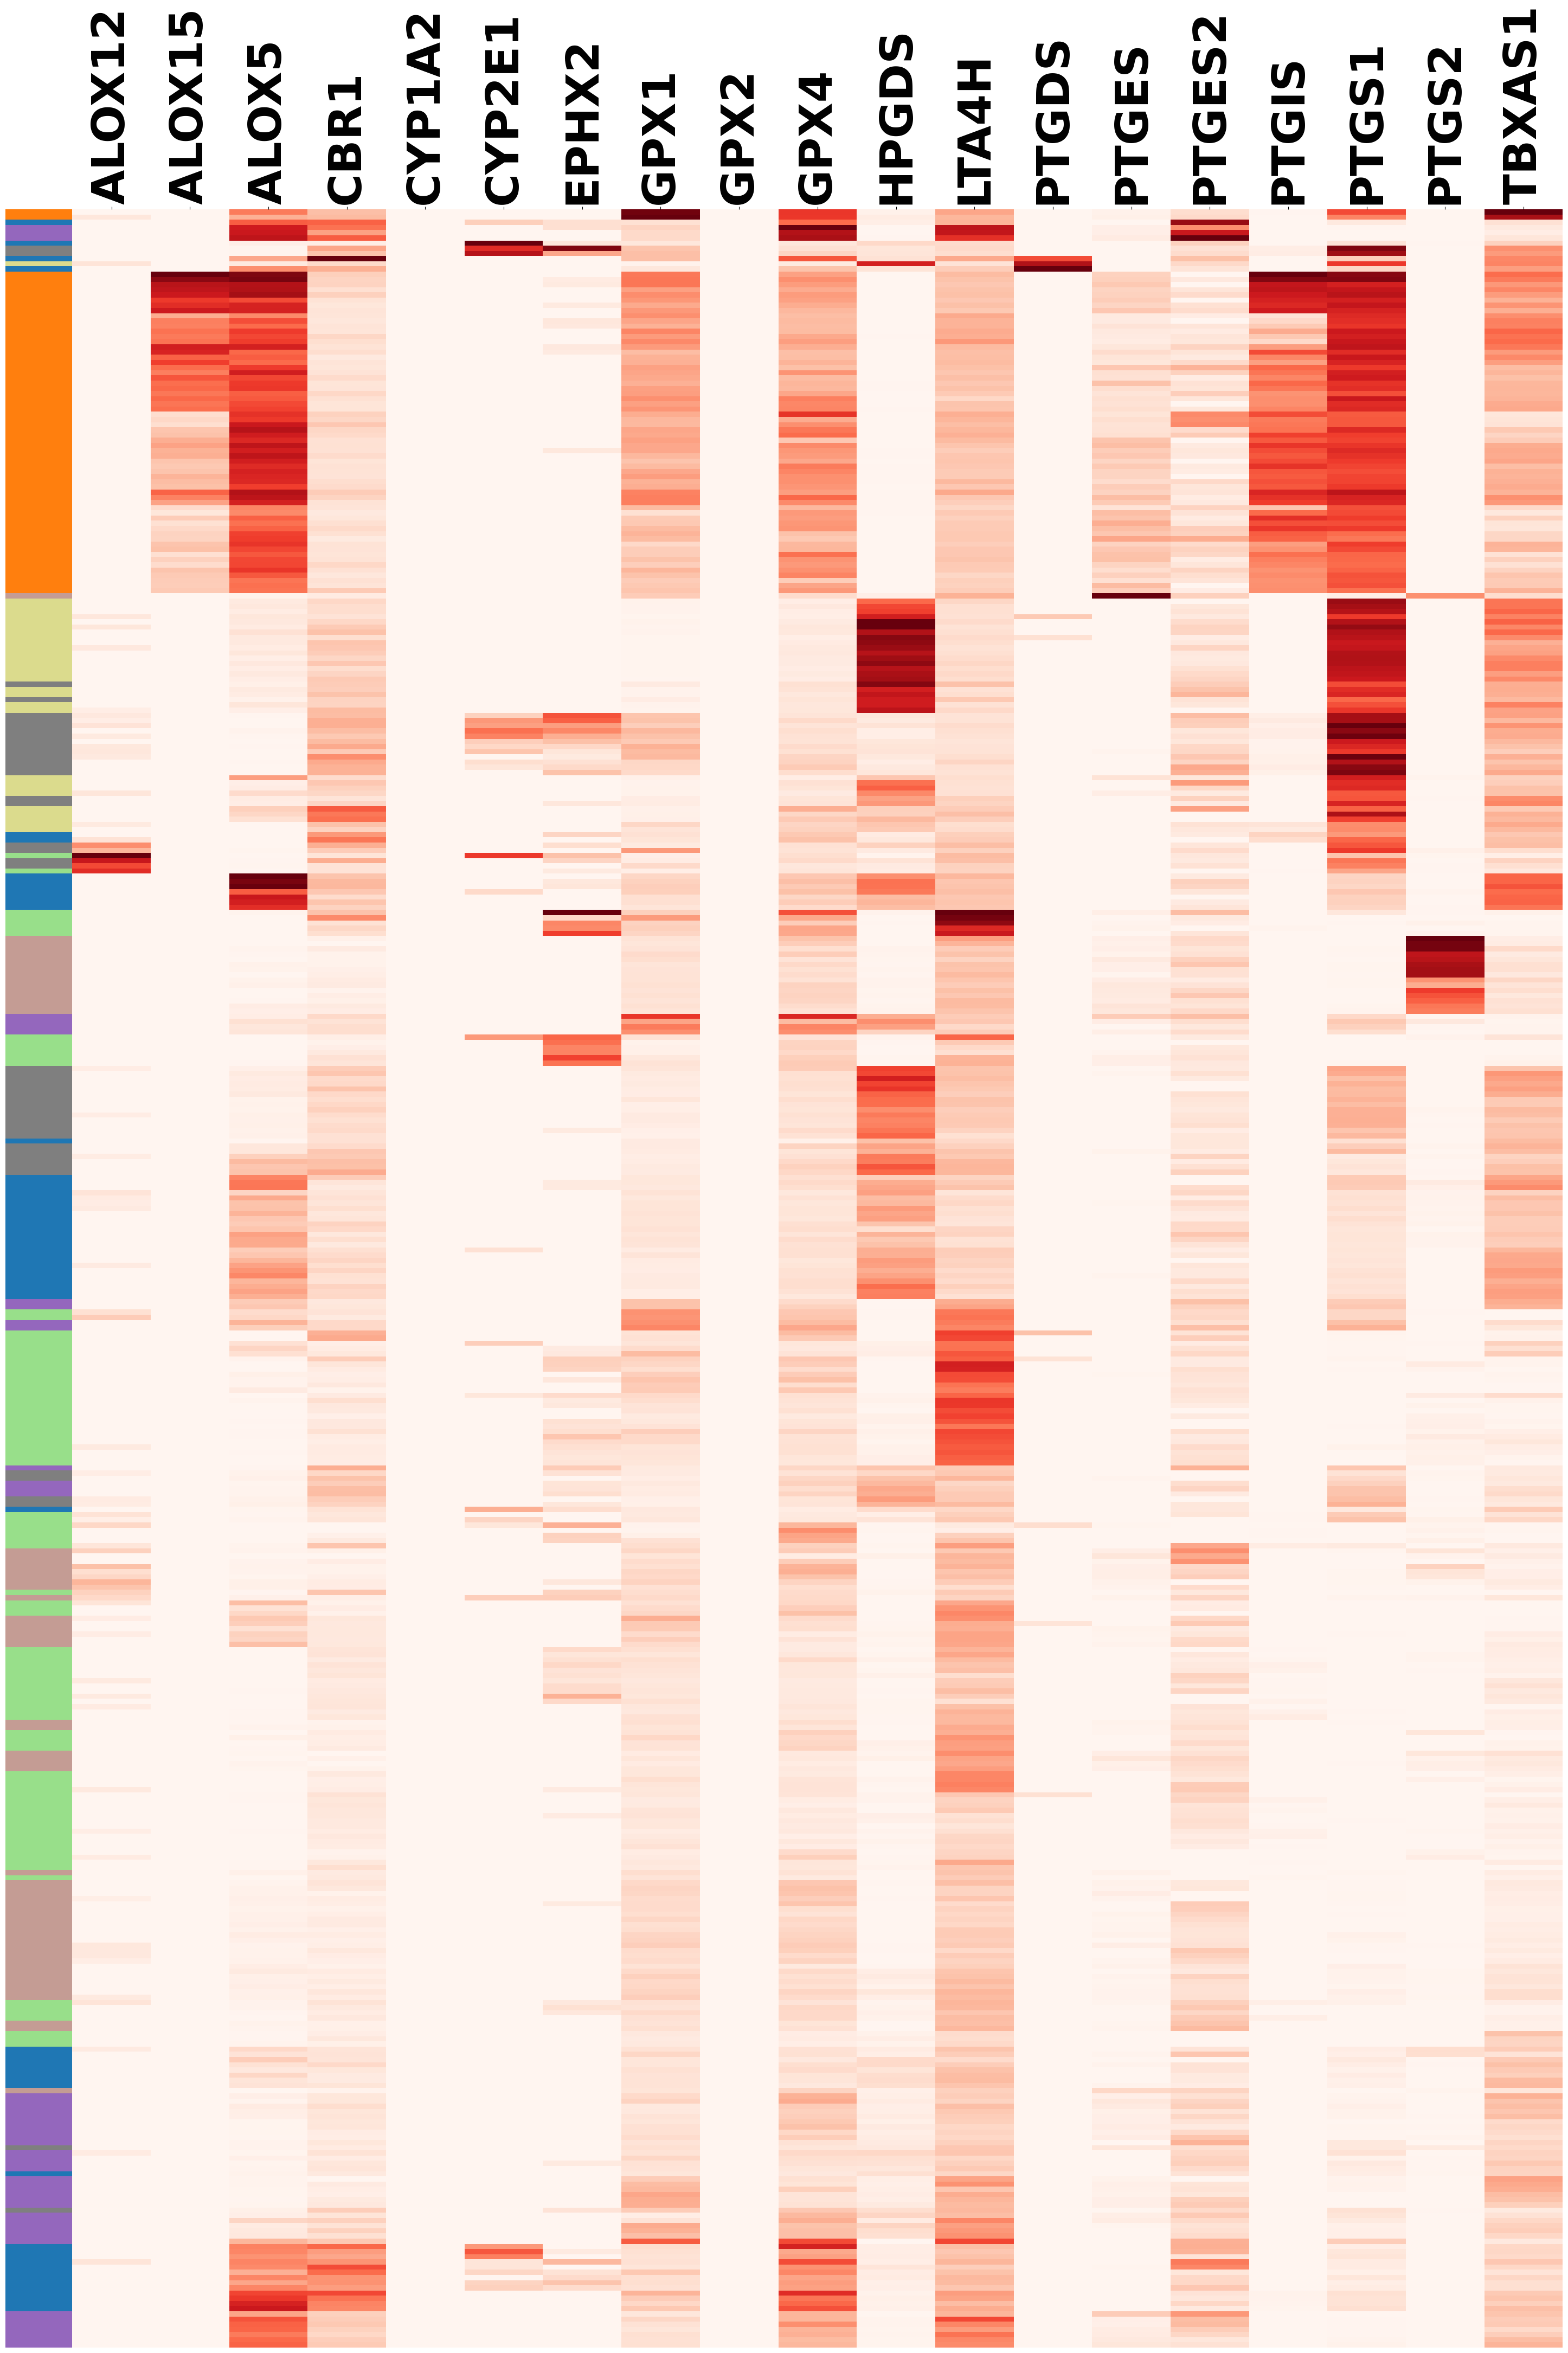

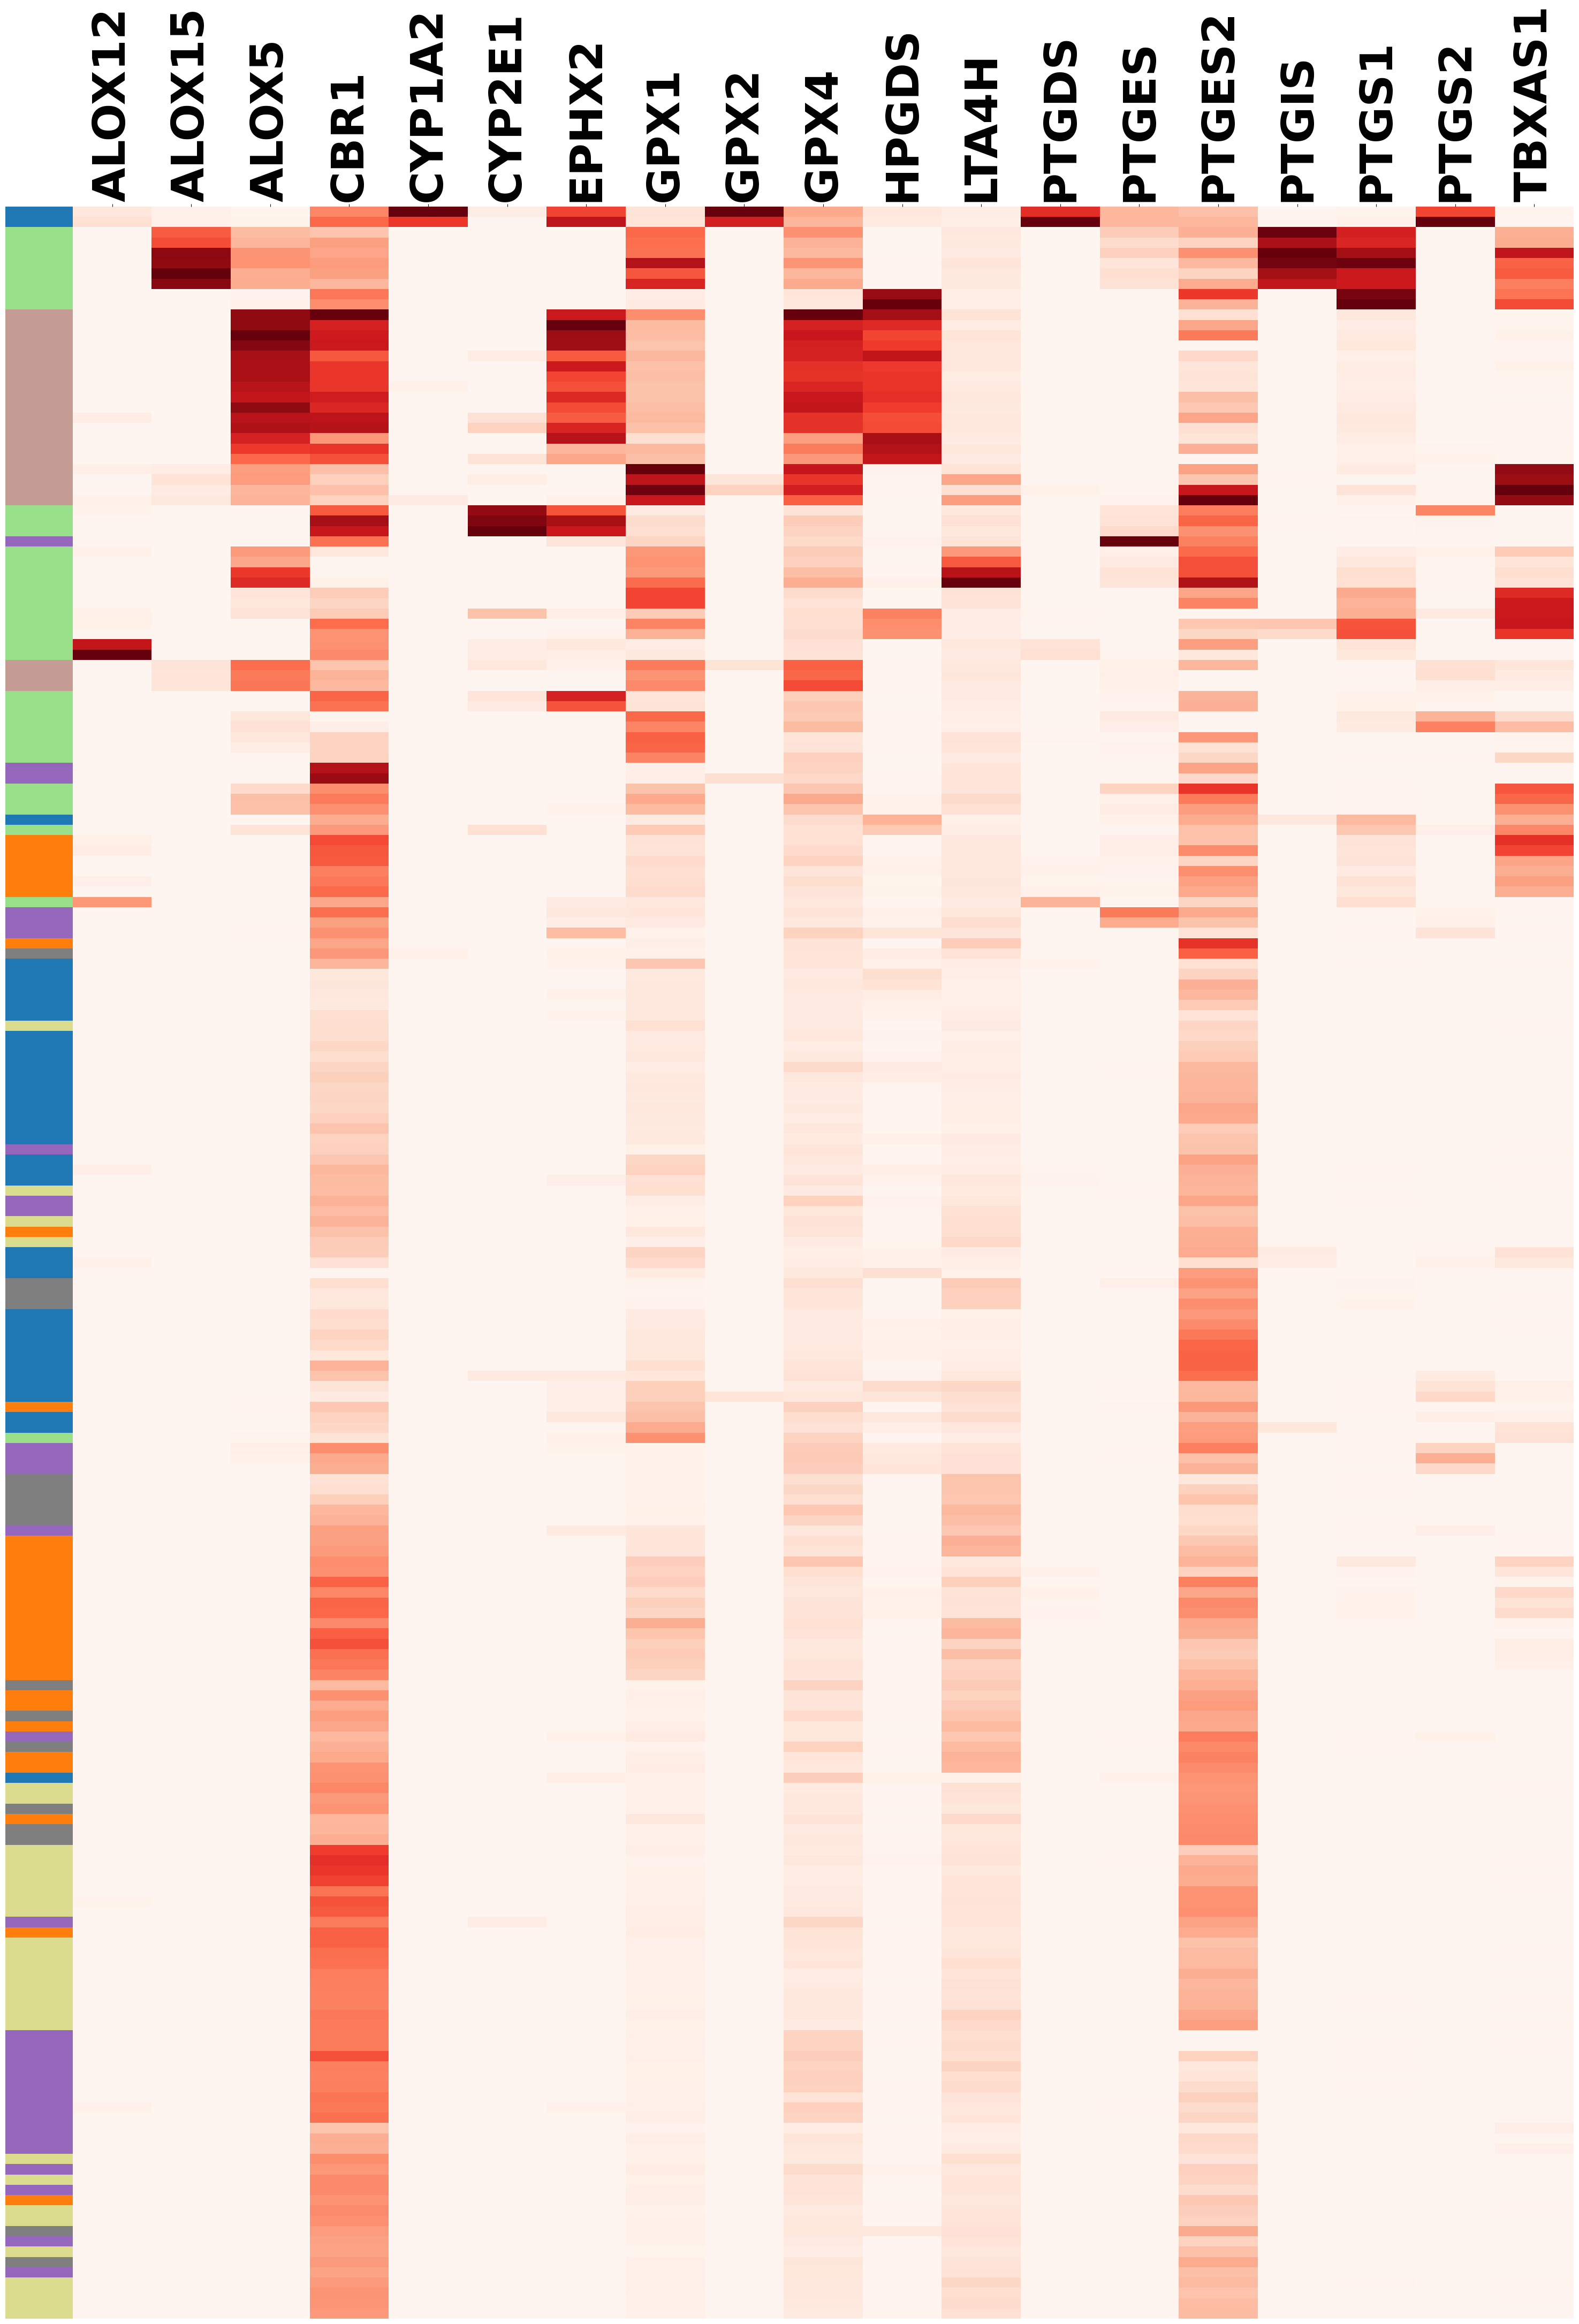

In [19]:
def show_lpm_clustermap(lpm_classes, dataset, datasets_umap, samples = [], only_with_path = False, figsize = (45,40), show_ylabel = False, show_plot = True, fontsize = 40, file_name = "", ax = None):
    
    if show_plot:
        plt.close()
    
    samples = DATA_SAMPLES[dataset] if len(samples) == 0 else samples

    lpm_classes = [lpm_classes] if type(lpm_classes) is not list else lpm_classes
        
    plt.rcParams.update(plt.rcParamsDefault)
    seaborn.reset_orig()
    matplotlib.rc_file_defaults()
    plt.rcParams["figure.figsize"] = figsize
    
    
    color_ids  = [x for x in range(len(datasets_umap[2])*2)]
    color_values = [j for i in zip([(1,1,1)]*len(datasets_umap[2]), [colors[:-1] for colors in list(datasets_umap[2].values())]) for j in i]
    color_ids_norm = plt.Normalize(min(color_ids),max(color_ids))
    color_tuples = list(zip(map(color_ids_norm,color_values), color_values))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_tuples)

    labels = ["A", "B", "C", "D", "E", "F", "G"]
    _data = {}
    substrate_names = ["AA", "DHA", "EPA"]
    substrate_ids = [get_node_from_name(name) for name in substrate_names]

    lpm_genes = sorted(list(set(sum([lpm_class_genes(lpm_class) for lpm_class in lpm_classes], []))), key = lambda gene: NODES[gene]["name"])
    lpm_gene_names = [NODES[gene]["name"] for gene in lpm_genes]
    
    max_read_counts = {gene:max([NODES[gene]["read_counts"][dataset][sample] for sample in samples]) for gene in lpm_genes}

    samples_with_paths = list(set(sum([samples_with_lpm_path(lpm_class, dataset) for lpm_class in lpm_classes], []))) if only_with_path else samples
    samples = []

    s = []
    c = []
    color_list = []
    
    data = {}
    for node, node_name in zip(lpm_genes,lpm_gene_names):
        data[node_name] = []
        for i,sample in enumerate(samples_with_paths): 
            for cluster_id,sample_cluster in enumerate(datasets_umap[1]):
                if sample in sample_cluster:
                    color_list.append(list(datasets_umap[2].values())[cluster_id])
            data[node_name].append(NODES[node]["norm_read_counts"][dataset][sample])
    
    # sampledata = pd.read_csv(datapath + "data/" + dataset + "_Samples.txt", index_col = 0, header = 0, sep='\t')
    # ylabels = [sampledata.loc["!Sample_description",c] if c in sampledata.columns else c for c in cellswithpaths]#[c[:15] + "..." if len(c) > 15 else c for c in _cell_types]
    ylabels = samples_with_paths
    bdf = pd.DataFrame(data, columns = list(data.keys()), index=ylabels)
    
    xlabels = lpm_gene_names

    g = seaborn.clustermap(bdf, row_colors = color_list, dendrogram_ratio=(0.3,0), vmin = 0, vmax = 1, figsize = figsize, row_cluster=True, col_cluster=False, yticklabels=1, cmap = "Reds")
    g.ax_cbar.remove()
    ax = g.ax_heatmap
    g.ax_row_dendrogram.set_visible(False)
    ax.set_xticklabels(xlabels, fontsize = fontsize, fontweight = "bold", ha = "center", rotation = 90)
    plt.setp(ax.get_yticklabels(), fontsize = 7) 
    ax.tick_params(labelright=show_ylabel, labelleft = show_ylabel, left = False, bottom = False, labelbottom = False, right = show_ylabel, top = True, labeltop = True)
    
    if file_name:
        plt.savefig(file_name + '.png', dpi=300, bbox_inches='tight')
        
        
    if show_plot:
        plt.show()
    
    return g

_ = [show_lpm_clustermap(LPM_CLASSES, dataset, UMAP_DATA_KMEAN_CLUSTERS[dataset], fontsize = 60, file_name = dataset + "_enzyme_heatmap") for dataset in GSE_DATASETS[:2]]

# Loop-weighted Feature-Set

In [20]:
def boxcox(s) -> np.array:
    posdata = s[s > 0]
    if all([_s == posdata[0] for _s in posdata]):
        return s
    else:
        bcdata, lam = scipy.stats.boxcox(posdata)
        x = np.empty_like(s)
        if abs(lam) < 5:   
            x[s > 0] = bcdata
            x[s == 0] = -1/lam
            return x
        else:
            x.fill(0)
            return x

def loop_feature_data(dataset, lpm_class = None, genes = None, samples = [], normalized = False, progress = True, max_sp_length = math.inf):
    
    if lpm_class == None and genes == None:
        raise ValueError("Either a LPM class or a list of genes must be supplied.")
    samples = DATA_SAMPLES[dataset] if len(samples) == 0 else samples
    genes = lpm_class_genes(lpm_class) if genes == None or len(genes) == 0 else genes

    numeric_feature_data = {}

    for i,node in enumerate(NODE_IDS):
        numeric_feature_data[node] = []
        for sample in samples:
            numeric_feature_data[node].append(TF_RANDOM_WALK_SCORES[dataset][lpm_class][sample][node] if node in TF_RANDOM_WALK_SCORES[dataset][lpm_class][sample] else 0)
    numeric_feature_data = pd.DataFrame.from_dict(numeric_feature_data, orient='index', columns=samples)#.apply(lambda row : normalize(row), axis = 1)#.transform(boxcox,axis=1)

    return numeric_feature_data

def compare_features(data, first_samples, second_samples, export_with_values = True, calculate_pvalue = True, statistical_test = "mannwhitneyu"):
    
    results = []
    
    # data = data.transform(boxcox,axis=1)
    for i, row in data.iterrows():
        
        pvalue = 1
        if calculate_pvalue and any(row != 0):
            if statistical_test == "difference":
                combination_pvalues = []
                for samples1,samples2 in [(first_samples, second_samples), (second_samples, first_samples)]:
                    for samples1 in samples1:
                        mean1 = row[sample1]
                        diff_distribution = [abs(mean1 - row[sample]) for sample in DATA_SAMPLES[dataset]]    
                        diff_distribution = [-diff for diff in diff_distribution] + diff_distribution
                        mu_m, std_m = scipy.stats.norm.fit(diff_distribution)
                        for second_sample in second:
                            mean2 = row[_c2]
                            diff_score = abs(mean1 - mean2)
                            temp_pvalue = (scipy.stats.norm.sf(abs((diff_score - mu_m) / std_m))*2) if std_m != 0 else 1
                            combination_pvalues.append(1 if math.isnan(temp_pvalue) else temp_pvalue)
                pvalue = min(combination_pvalues, default = 1)
            elif statistical_test == "anova":
                pvalue = scipy.stats.f_oneway([row[sample] for sample in first_samples], [row[sample] for sample in second_samples])[1]
                pvalue = 1 if math.isnan(pvalue) else pvalue
            elif statistical_test == "kruskal":
                pvalue = scipy.stats.kruskal(*clusters)[1]
            elif statistical_test == "mannwhitneyu":
                pvalue = scipy.stats.mannwhitneyu([row[sample] for sample in first_samples], [row[sample] for sample in second_samples])[1]
        diff_score = statistics.mean([row[sample] for sample in first_samples]) - statistics.mean([row[sample] for sample in second_samples])
        results.append([i, diff_score, pvalue])

    if calculate_pvalue and len(results) > 0:
        adj_pvalues = multipletests([x[2] for x in results])[1]
        results = [[results[i][0], results[i][1], results[i][2], y] for i,y in enumerate(adj_pvalues)]
    else:
        results = [[results[i][0], results[i][1], results[i][2], 1] for i,_ in enumerate(results)]
    # print(results)  
    return [(x if export_with_values else x[0]) for x in results]


scipyfunctions = {
 'lognorm': scipy.stats.lognorm,
 'cauchy': scipy.stats.cauchy,
 'chi2': scipy.stats.chi2,
 'expon': scipy.stats.expon,
 'exponpow': scipy.stats.exponpow,
 'gamma': scipy.stats.gamma,
 'lognorm': scipy.stats.lognorm,
 'norm': scipy.stats.norm,
 'powerlaw': scipy.stats.powerlaw,
 'rayleigh': scipy.stats.rayleigh,
 'uniform': scipy.stats.uniform
}
def distance_from_slope(point,coef):
    return (point[1] - (coef[0]*point[0] + coef[1]))
    # return abs((coef[0]*point[0])-point[1]+coef[1])/math.sqrt((coef[0]*coef[0])+1)

def pvalue_of_features(dataset, lpm_class, samples, custom_data = None, expression_weighted = False, adjusted = True, samples_vs = []):
    
    data = custom_data if isinstance(custom_data, pd.DataFrame) else NORMALIZED_LPM_FEATURES[dataset][lpm_class]
    feature_results = []
    
    for node, row in NORM_EXPRESSION_DATA[dataset].iterrows():
        if any(data.loc[node,:] != 0):
#             feature_results.append([node,sum([row[sample] + (expr_data.loc[node,sample] if expression_weighted else 0) for sample in samples])])
            try:

                sample_x = np.array([row[sample] for sample in DATA_SAMPLES[dataset] if sample in samples])
                sample_y = np.array([data.loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample in samples])

                if any(sample_y != 0):
                    x = np.array([row[sample] for sample in DATA_SAMPLES[dataset] if sample not in samples])
                    y = np.array([data.loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample not in samples])
                    # x = x[y != 0]
                    # y = y[y != 0]
                    

                    if np.count_nonzero(y) > len(samples):
                        coef = np.polyfit(x, y, 1)
                        distances = [distance_from_slope(point, coef) for point in zip(x, y)]
                        distance = statistics.mean([distance_from_slope(point, coef) for point in zip(sample_x, sample_y)])                        
                        mu, std = scipy.stats.halfnorm.fit([abs(dist) for dist in distances]) 
                        p_value = 1 - scipy.stats.halfnorm.cdf(abs(distance), mu, std)   
                    else:
                        p_value = 1
                        distance = 0

                else:
                    p_value = 1
                    distance = 0

                feature_results.append([node, p_value if p_value else 1, distance])

            except:
                pass
      
    if adjusted and len(feature_results) > 1:
        adj_pvalues = multipletests([x[1] for x in feature_results])[1]
        feature_results = [[feature_results[i][0], y, feature_results[i][2]] for i,y in enumerate(adj_pvalues)]
    
    return {node: (pvalue,distance) for node,pvalue,distance in feature_results}

## LPM Class-Specific Loop Features

In [21]:
if reload_data:
    LOOP_FEATURES_LPM = {dataset:{lpm_class: loop_feature_data(dataset, lpm_class = lpm_class, max_sp_length = math.inf, progress = False) for lpm_class in LPM_CLASSES} for i,dataset in enumerate(GSE_DATASETS)}
    with open('LOOP_FEATURES_LPM.pkl', 'wb') as f:
        pickle.dump(LOOP_FEATURES_LPM, f)
else:
    with open('LOOP_FEATURES_LPM.pkl', 'rb') as f:
        LOOP_FEATURES_LPM = pickle.load(f)
        
    
NORMALIZED_LPM_FEATURES = {dataset:{lpm_class: copy.deepcopy(LOOP_FEATURES_LPM[dataset][lpm_class]).apply(lambda row : normalize(row), axis = 1) for lpm_class in LPM_CLASSES} for dataset in GSE_DATASETS}

## Fit Distribution of Features

In [22]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
def fit_feature_distributions(dataset):
    fitted_feature_distributions = {}   
    n_nodes = len(NODE_IDS)
    n_total = len(LPM_CLASSES) * n_nodes
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i,lpm_class in enumerate(LPM_CLASSES):
            data = LOOP_FEATURES_LPM[dataset][lpm_class]
            fitted_feature_distributions[lpm_class] = {}  
            for j,(index,row) in enumerate(data.iterrows()):
                print_progress_bar(i * n_nodes + j, n_total)
                if any(row != 0):
                    f = Fitter([x for x in row.values if x != 0], distributions= get_common_distributions())
                    f.fit()
                    fitted_feature_distributions[lpm_class][index] = list(f.get_best(method = 'sumsquare_error').items())[0]
    return fitted_feature_distributions

# if reload_data:
#     FEATURE_DISTRIBUTIONS = {dataset:fit_feature_distributions(dataset) for dataset in GSE_DATASETS}
#     with open('FEATURE_DISTRIBUTIONS.pkl', 'wb') as f:
#         pickle.dump(FEATURE_DISTRIBUTIONS, f)
# else:
#     with open('FEATURE_DISTRIBUTIONS.pkl', 'rb') as f:
#         FEATURE_DISTRIBUTIONS = pickle.load(f)

In [23]:
def fit_expression_distributions(dataset):
    fitted_feature_distributions = {}   
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = NORM_EXPRESSION_DATA[dataset]
        n_nodes = len(data)
        for j,(index,row) in enumerate(data.iterrows()):
            print_progress_bar(j, n_nodes)
            if any(row != 0):
                f = Fitter([x for x in row.values], distributions= get_common_distributions())
                f.fit()
                fitted_feature_distributions[index] = list(f.get_best(method = 'sumsquare_error').items())[0]
    return fitted_feature_distributions

# if reload_data:
#     EXPRESSION_DISTRIBUTIONS = {dataset:fit_expression_distributions(dataset) for dataset in GSE_DATASETS}
#     with open('EXPRESSION_DISTRIBUTIONS.pkl', 'wb') as f:
#         pickle.dump(EXPRESSION_DISTRIBUTIONS, f)
# else:
#     with open('EXPRESSION_DISTRIBUTIONS.pkl', 'rb') as f:
#         EXPRESSION_DISTRIBUTIONS = pickle.load(f)

# Build CRNs

In [24]:
# Building a CRN from supplied list of edges for each cluster of sample 
def construct_crn(edges, sample_clusters, dataset, submap_nodes = [], show_ax_titles = False, directed = False, subplots_to_show = [], color_edges = True, show_plot = True, 
                  max_variance = 0.1, coloring = "expression", show_variance = False, n_columns = 2, fig_size = (30,20), file_name = ""):
    
    plt.clf()

    n_plots = (len(sample_clusters) if len(subplots_to_show) == 0 else len(subplots_to_show))
    fig, axs = plt.subplots(1, 1, figsize=figsize) if show_variance else plt.subplots(math.ceil(n_plots/n_columns), n_columns, figsize=fig_size)

    if directed:
        CRN = nx.DiGraph()
    else:
        CRN = nx.Graph()
    for edge in edges:
        CRN.add_edges_from([(edge[0], edge[2], {"color": ('red' if float(edge[1]) == -1 and color_edges else "black")})])

    edges = CRN.edges()
    edge_colors = [CRN[source][target]['color'] for source,target in edges]

    node_id_name = {} 
    node_border_colors = {
        "submap": [],
        "other": [],
        "noexpr": [],
        
    }
    node_border_widths = {
        "submap": [],
        "other": [],
        "noexpr": [],
    }

    for node in CRN:   
        node_id_name[node] = NODES[node]["name"]
        if  NODES[node]["in_dataset"][dataset] == False: 
            node_border_widths["noexpr"].append(1)
            node_border_colors["noexpr"].append(plt_colors.rgb2hex((0, 0, 0)))
        elif node in submap_nodes:
            node_border_widths["submap"].append(1)
            node_border_colors["submap"].append(plt_colors.rgb2hex((0, 0, 0)))
        else:
            node_border_widths["other"].append(0)
            node_border_colors["other"].append(plt_colors.rgb2hex((1,1,1)))

    relabeled_CRN = nx.relabel_nodes(CRN, node_id_name)     
    # auto_layout_node_positions = graphviz_layout(CRN, prog='neato')   
    relabeled_pos = graphviz_layout(relabeled_CRN, prog='neato')  
    
    # iterating each CRN
    # if show_variance, only one CRN is shown in which the node colors represent the variance of their read_counts across the different clusters
    for i, sample_cluster in enumerate(sample_clusters if not show_variance else [list(sample_clusters)]):
        if len(subplots_to_show) > 0:
            if i not in subplots_to_show:
                continue
            i = subplots_to_show.index(i)
        
        if is_list(axs):
            ax = axs[math.floor(i/n_columns), i%n_columns] if n_plots > n_columns and n_columns > 1 else axs[i%n_columns]
        else:
            ax = axs

        node_colors = {
            "submap": [],
            "other": [],
            "noexpr": [],
        }

        node_values = {}
        for node in CRN:
            if NODES[node]["in_dataset"][dataset]:
                if coloring == "variance":
                    if len(samples) == 2:
                        expr_value = math.log((statistics.mean([NODES[node]["norm_read_counts"][dataset][sample] for sample in sample_cluster[1]])+0.001)/(statistics.mean([elements[node]["norm_read_counts"][dataset][sample] for sample in sample_cluster[0]])+0.001), 2)
                        
                    else:
                        expr_value = statistics.variance([statistics.mean([NODES[node]["norm_read_counts"][dataset][sample] for sample in samples]) for samples in sample_cluster])
                elif coloring == "expression":
                    expr_value = statistics.mean([NODES[node]["norm_read_counts"][dataset][sample] for sample in sample_cluster])#/(cvalues[node] if cvalues[node] > 0 else 1)
                elif coloring == "score":
                    expr_value = statistics.mean([statistics.mean([NORMALIZED_LPM_FEATURES[dataset][lpm_class].loc[node,sample] for lpm_class in LPM_CLASSES]) for sample in sample_cluster])
                else:
                    expr_value = 1
            else:
                expr_value = 0
            node_values[node] = expr_value
        max_value = max([abs(x) for x in node_values.values()], default = 1)
        for node,_value in node_values.items():
            if max_variance and show_variance:
                _value = _value/max_variance if _value <= max_variance else 1
            # else:
            #     _value = _value/max_value
            if NODES[node]["in_dataset"][dataset]:
                node_color = plt_colors.rgb2hex((0.6, 0.6, 0.6))
                if _value > 0:
                    node_color = plt_colors.rgb2hex((1, 1-_value, 1-_value))
                elif _value < 0:
                    node_color = plt_colors.rgb2hex((1- abs(_value), 1-abs(_value), 1))
                node_colors["submap" if node in submap_nodes else "other"].append(node_color)
            else:
                node_colors["noexpr"].append(plt_colors.rgb2hex((1, 1, 1)))


        ax.margins(0.20)

        nx.draw_networkx_edges(relabeled_CRN, relabeled_pos, edge_color=edge_colors, ax=ax)
        nx.draw_networkx_labels(relabeled_CRN, relabeled_pos, ax=ax)

        node_list = [NODES[node]["name"] for node in CRN.nodes() if node not in submap_nodes and NODES[node]["in_dataset"][dataset]]
        nx.draw_networkx_nodes(relabeled_CRN, relabeled_pos,
                               nodelist   = node_list,
                               node_shape = 'o',
                               node_size  = 400,
                               node_color = node_colors["other"],
                               linewidths = node_border_widths["other"],
                               edgecolors = node_border_colors["other"],
                               ax=ax)

        node_list = [NODES[node]["name"] for node in CRN.nodes() if node in submap_nodes and NODES[node]["in_dataset"][dataset]]
        nx.draw_networkx_nodes(relabeled_CRN, relabeled_pos,
                               nodelist   = node_list,
                               node_size  = 500, 
                               node_color = node_colors["submap"],
                               linewidths = node_border_widths["submap"],
                               edgecolors = node_border_colors["submap"],
                               node_shape = 's',
                               ax=ax)
        node_list = [NODES[node]["name"] for node in CRN.nodes() if not NODES[node]["in_dataset"][dataset]]
        nx.draw_networkx_nodes(relabeled_CRN, relabeled_pos,
                               nodelist   = node_list,
                               node_size  = 500, 
                               node_color = node_colors["noexpr"],
                               linewidths = node_border_widths["noexpr"],
                               edgecolors = node_border_colors["noexpr"],
                               node_shape = 'D',
                               ax=ax)
        ax.set_facecolor('white')
        ax.axis('off')
        
        ax.set_title(str(i) + ". " + "\n".join(sample_cluster) if show_ax_titles and not show_variance else "")


    fig.set_facecolor('white')
    plt.box(False)
    if file_name:
        fig.savefig(file_name + ".png", dpi=300, bbox_inches='tight', transparent=True) 
     
    if show_plot:
        plt.show()
        
    return (fig,axs if type(axs) is list else [axs])

def getpath(parent, vertex, target):
     
    # global parent
    if (vertex == 0):
        return []
    path = [vertex] + getpath(parent, parent[vertex], target)
    return path
 
# Function to return the maximum weight
# in the widest path of the given graph
def widest_path_problem(Graph, src, target):
     
    # To keep track of widest distance
    widest = [-10**9]*(len(Graph))
 
    # To get the path at the end of the algorithm
    parent = [0]*len(Graph)
 
    # Use of Minimum Priority Queue to keep track minimum
    # widest distance vertex so far in the algorithm
    container = []
    container.append((0, src))
    widest[src] = 10**9
    container = sorted(container)
    while (len(container)>0):
        temp = container[-1]
        current_src = temp[1]
        del container[-1]
        for vertex in Graph[current_src]:
 
            # Finding the widest distance to the vertex
            # using current_source vertex's widest distance
            # and its widest distance so far
            distance = max(widest[vertex[1]],
                           min(widest[current_src], vertex[0]))
 
            # Relaxation of edge and adding into Priority Queue
            if (distance > widest[vertex[1]]):
 
                # Updating bottle-neck distance
                widest[vertex[1]] = distance
 
                # To keep track of parent
                parent[vertex[1]] = current_src
 
                # Adding the relaxed edge in the priority queue
                container.append((distance, vertex[1]))
                container = sorted(container)
    return [getpath(parent, target, target), widest[target]]
    
def generate_crn_edges(dataset, samples1, samples2, additional_samples = [], lpm_classes = LPM_CLASSES, fig_size = (30,20), directed = False, coloring = "expression", file_name = "", show_ax_titles = True, n_features = 3):
    
    edge_strings = set() 
    allenzymes = list(set(sum([lpm_class_genes(lpm_class) for lpm_class in lpm_classes], [])))
    
    for lpm_class in lpm_classes:
        weights = (LOOP_FEATURES_LPM[dataset][lpm_class][samples2].mean(axis = 1) - 
                                     LOOP_FEATURES_LPM[dataset][lpm_class][samples1].mean(axis = 1)).abs()
        # weights = weights.div(weights.max())
        top_featues = list(weights.nlargest(n_features).index)
        g = [[] for i in range(len(NODE_IDS))]
        for edge in EDGES:
            if any([is_expressed(edge["target"], sample, dataset, filtering = "all") for sample in samples1+samples2]) and any([is_expressed(edge["source"], sample, dataset, filtering = "all") for sample in samples1+samples2]):
                g[NODE_IDS.index(edge["target"])].append((weights[edge["source"]], NODE_IDS.index(edge["source"])))
        enzymes = lpm_class_genes(lpm_class)
        for enzyme in enzymes:
            for path in [widest_path_problem(g, NODE_IDS.index(enzyme), NODE_IDS.index(node)) for node in top_featues]:
                for edge in pairwise(path):
                    edge_strings.add("_".join([NODE_IDS[edge[0]], "1", NODE_IDS[edge[1]]]))
    construct_crn([edge.split("_") for edge in edge_strings], [samples1,samples2] + additional_samples, dataset, directed = directed, coloring=coloring, fig_size = fig_size, show_ax_titles = show_ax_titles, file_name = file_name, submap_nodes = allenzymes)

# Data Analysis

## Loop Features weighted UMAP

In [25]:
def get_UMAP_dimensions(dataframe, feature_type, combined_umap, n_neighbors=15, min_dist=0.1, prefix = "", metric="euclidean"):

    # UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    scaled_data = StandardScaler().fit_transform(dataframe.T)
    embedding = reducer.fit_transform(scaled_data)

    #save embedding to dataframe
    umap_result = pd.DataFrame(data=embedding,
                          columns=[
                              prefix + "_" + str(feature_type) + "_" + "UMAP_0",
                              prefix + "_" + str(feature_type) + "_" + "UMAP_1"
                          ])
    return pd.concat([combined_umap, umap_result], axis=1)

def combine_umap(combined_df, result_name, n_neighbors=15, min_dist=0.1):

    # UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="euclidean", random_state=42)
    scaled_data = StandardScaler().fit_transform(combined_df)
    return reducer.fit_transform(scaled_data)  

def loop_weighted_umap(input_list, dataset, normalized = False, n_clusters = 5, samples = None, min_dist=0.1, cmap='tab20', legend = "outside", predefined_clusters = None, figsize=(30,15), 
                       samples_with_labels = [], marker_size = 100, n_neighbors = 3, n_markers = 1, axs = None, boolean_features = False, file_name = ""):
    
    samples = samples if samples else DATA_SAMPLES[dataset]
    combined_umap = pd.DataFrame()
    
    if not predefined_clusters:
        predefined_clusters = UMAP_DATA_CELL_CLUSTERS[dataset][0]
        
    input_list = input_list 
    
    if is_list(input_list) or boolean_features:    
    
        for node in input_list:        
            loop_data = NORMALIZED_LPM_FEATURES[dataset][node] if normalized else LOOP_FEATURES_LPM[dataset][node]
            combined_umap = get_UMAP_dimensions(loop_data[samples], "con", combined_umap, prefix = node, min_dist=min_dist, n_neighbors=n_neighbors)

        combi_umap_results = pd.DataFrame(index=EXPRESSION_DATA[dataset].index)
        combi_embedding = combine_umap(combined_umap, combi_umap_results, n_neighbors = n_neighbors)
    
    else:
        loop_data = NORMALIZED_LPM_FEATURES[dataset][input_list] if normalized else LOOP_FEATURES_LPM[dataset][input_list]
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="euclidean", random_state=42)
        scaled_data = StandardScaler().fit_transform(loop_data[samples].T)
        combi_embedding = reducer.fit_transform(scaled_data)        
    
    return {loop_data.columns[i]: embedding for i,embedding in enumerate(combi_embedding)}

# KMEAN_LPM_CLUSTERED_LOOP_EMBEDDINGS = {dataset:{lpm_class:loop_weighted_umap(lpm_class, dataset, weighted = False, n_neighbors = 15, n_clusters = 6) for lpm_class in LPM_CLASSES} for dataset in GSE_DATASETS}
KMEAN_ALL_CLUSTERED_LOOP_EMBEDDINGS = {dataset:loop_weighted_umap(LPM_CLASSES, dataset, normalized = True, n_neighbors = 25, n_clusters = 6) for dataset in GSE_DATASETS[:2]}

## Unique CRNs of Loop Weighted Clusters

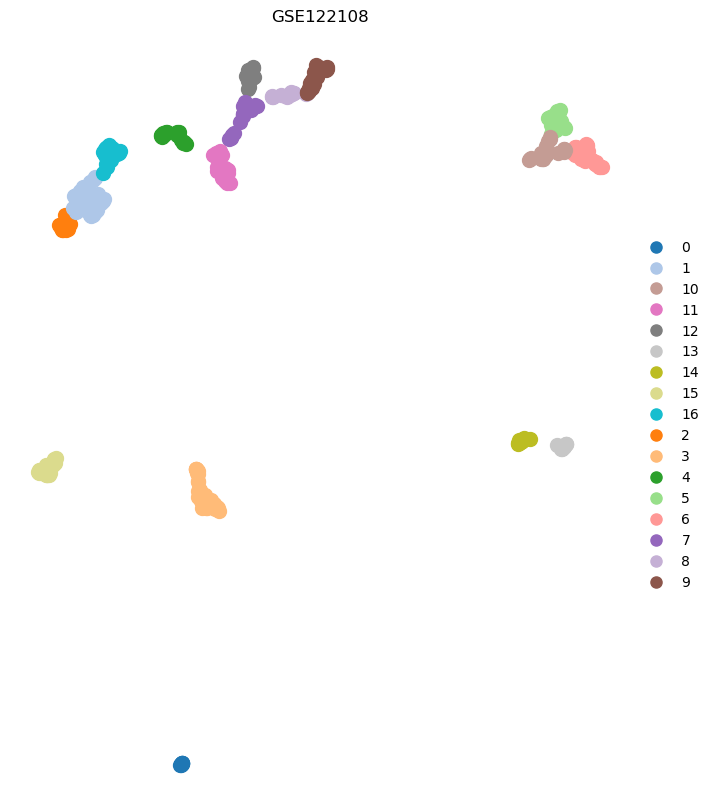

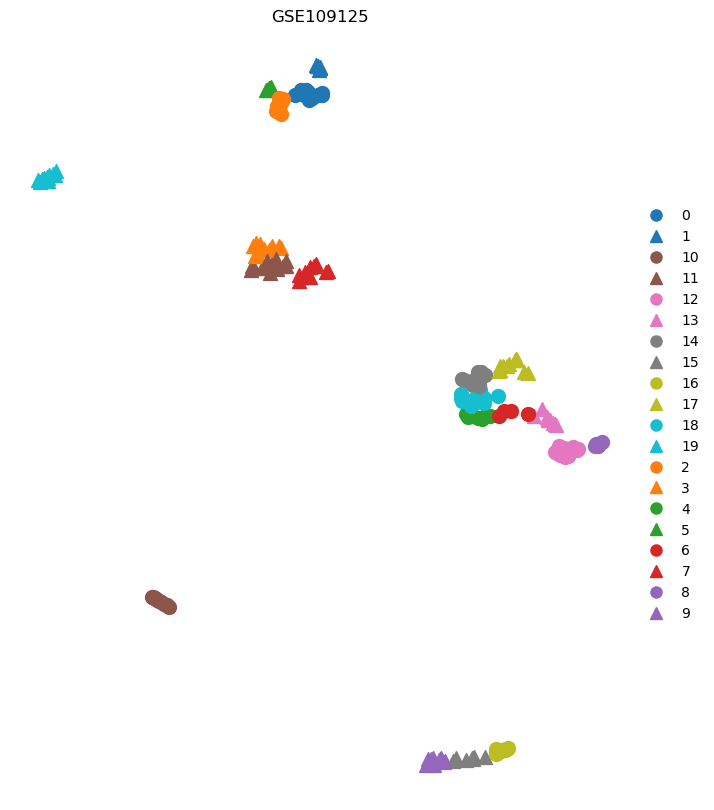

In [26]:
def print_kmean_loop_clusters(dataset, lpm_classes, factor = 2, rank_genes = False, write_file = False, n_clusters = False, samples = None, cmap='tab20', legend = "below", figsize=(30,15), 
                       samples_with_labels = [], marker_size = 100, n_markers = 1, file_name = "", weighted = False, show_plot = True, label_separator = ", "):
    
    plt.close()
    
    fig, ax = plt.subplots(figsize = (10,10))     
    
    embedding = KMEAN_LPM_CLUSTERED_LOOP_EMBEDDINGS[dataset][lpm_classes[0]] if len(lpm_classes) == 1 else KMEAN_ALL_CLUSTERED_LOOP_EMBEDDINGS[dataset]

    kmean_clustering_results = print_umap_with_kmean_clusters(list(embedding.keys()), np.array(list(embedding.values())), dataset, factor = factor, label_separator = label_separator, min_namelength = 8,
                                                              n_clusters = n_clusters, samples_in_legend = False, cmap =cmap, legend = legend, marker_size = marker_size, ax = ax, n_markers=n_markers, legend_fontsize = 10,
                                                                title = "")    
    ax.set_title(dataset)
    plt.show()
    
    
    if write_file:
        with open("umap_results/" + dataset + "_" + ((NODES[lpm_classes[0]]["name"] if len(lpm_classes) == 1 else "all_lipid_mediators")) + ".txt", "w", encoding="utf-8") as f:
            for j,cluster in enumerate(kmean_clustering_results[0].keys()):
                f.write("Cluster " + str(j) + ": " + cluster + "\n" + "\n".join(kmean_clustering_results[1][j]) + "\n\n")
                
    return kmean_clustering_results

LPM_N_CLUSTERS = {dataset:print_kmean_loop_clusters(dataset, LPM_CLASSES, n_markers = 1 if i == 0 else 2, n_clusters = 17 if i == 0 else 20, legend = "outside", write_file = True, show_plot = True, file_name = "") for i,dataset in enumerate(GSE_DATASETS[:2])}

In [27]:
CUSTOM_LPM_CLUSTER_LABELS = {
    GSE_DATASETS[0] : {
        "Embryonic MFs & DCs": [3],
        "Monocytes": [9],
        "Stimulated Monocytes":[8],
        "Stimulated Monocytes + Macrophages": [7],
        "Adipose Tissue Macrophages": [16],
        "Aorta Macrophages": [0],
        "Heart Macrophages (CCR2-)": [13],
        "Heart Macrophages (CCR2+)\nHeart Monocytes": [14],
        "Liver Macrophages": [11],
        "Lung Tissue Macrophages": [12],
        "Peritoneal Macrophages": [1,2],
        "Microglia": [15],
        "Mixed Dendritic Cells": [5,6],
        # "Pre Dendritic Cells\nfrom Bone Marrow": [10],
        "Pre Dendritic Cells from Spleen & Liver": [10],
        "Mixed Macrophages": [4],
    },
    GSE_DATASETS[1]: {
        "Hematopoietic Stem Cells": [9],
        "Early Lymphoid Progenitors": [15],
        "Late Lymphoid Progenitors": [16],
        "Early & Follicular B-Cells": [0],
        "Late B-Cells & IAPs": [2],
        "Germinal Center B-Cells": [1],
        "Epithelia + ILC2": [5],
        "Thymic Medullary Epithelial cells": [6],
        "ILC3s": [8],
        "NKT Cells": [19],
        "NK Cells + Basophils": [12],
        "Mast Cells": [10],
        "Dendritic Cells": [4],
        "Neutrophils + Eosinophils": [7],
        "Mixed Myeloid Cells": [11, 3],
        "Mixed Lymphoid Cells\n(NKT, T4, T8)": [14, 17],
        "gd T-Cells": [18],
        "LCMV Stimulated T8 Cells": [13]
        # "Mixed Cells\n(NK, ILC3, T8, Basophils)": [3],
    }
}

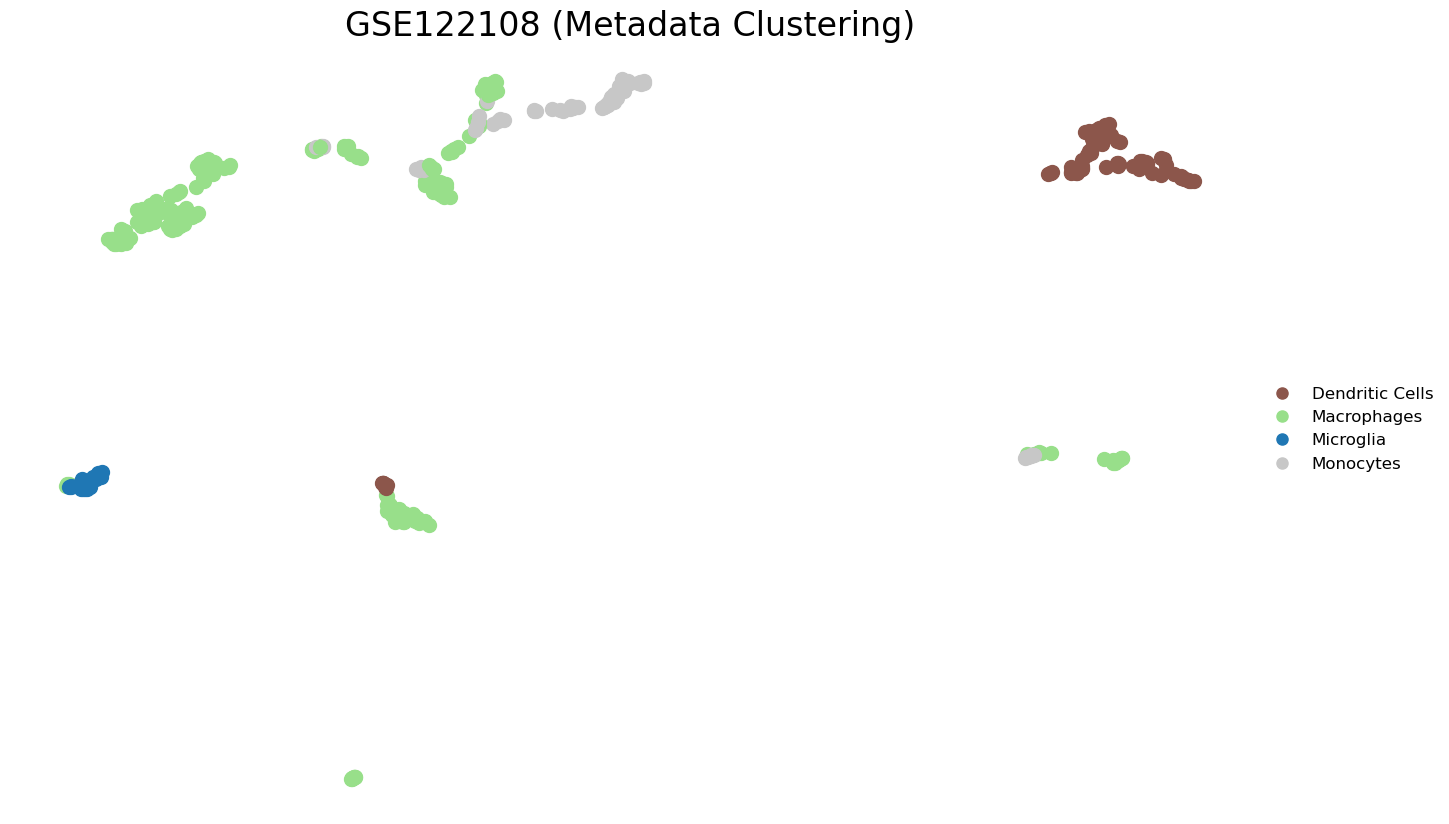

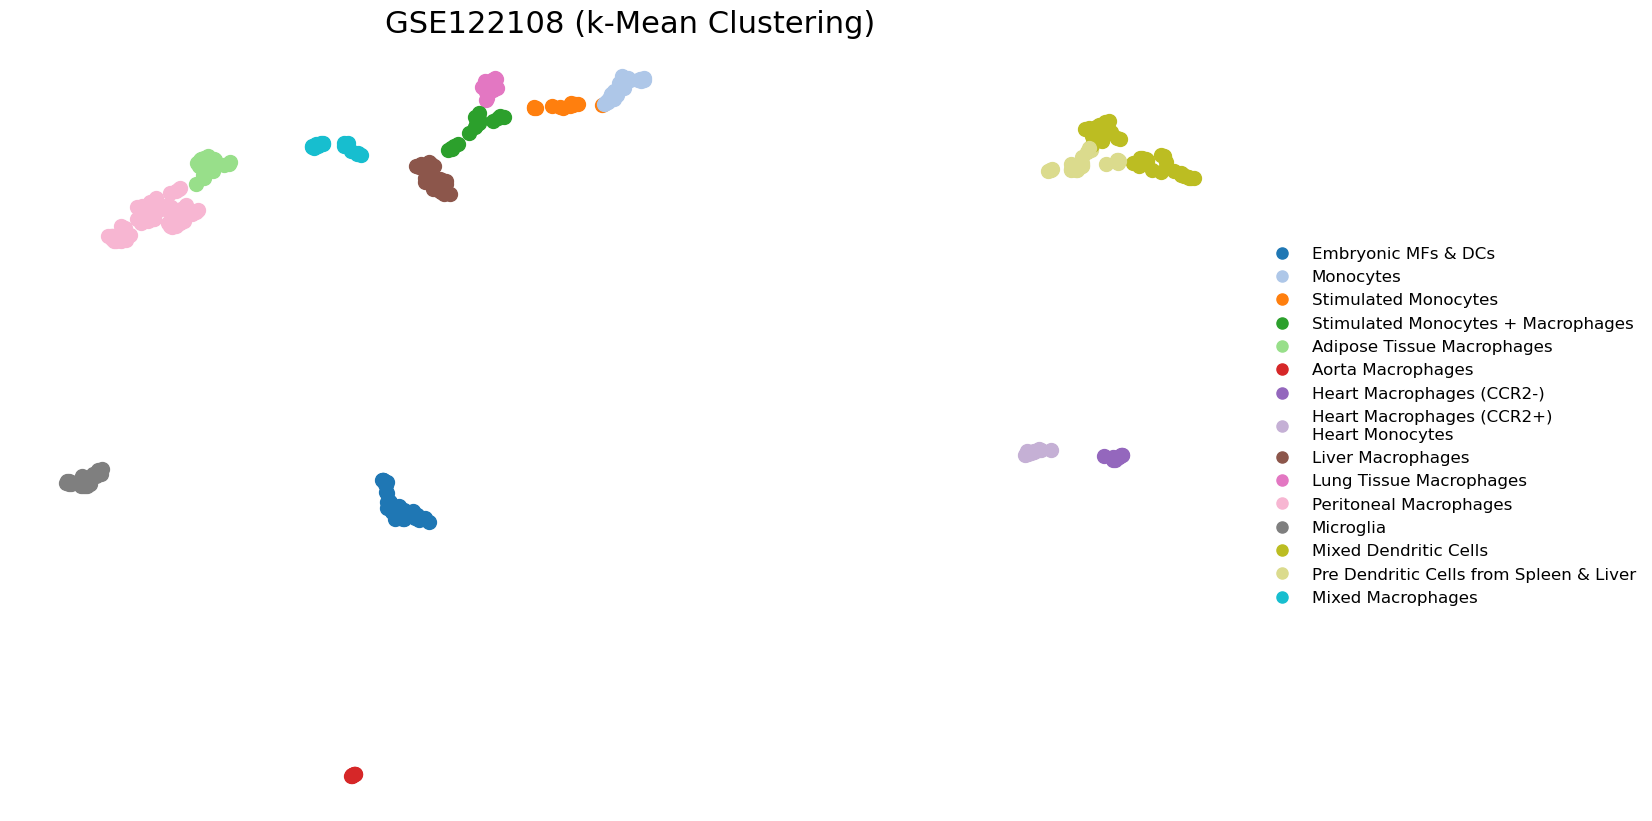

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


Embryonic MFs & DCs: MEN1, E2F8, DMAP1, TRIM28, FOXM1, HIF3A, TFDP1, WDR5, HCFC1, MYB
Monocytes: NUPR1, KLF2, POU2F2, STAT5B
Stimulated Monocytes: LIMD1, PHB2, ARNT, NFKB2, ESRRA, SMAD2, NFYA, AHR, CEBPB, HIF1A
Stimulated Monocytes + Macrophages: IRF3, CREB5, REST, TRIB3, IRF7
Adipose Tissue Macrophages: MEN1, ZBTB16, CEBPA, RUNX1, CEBPD
Aorta Macrophages: ZBTB7A, TRRAP, MEF2C, SMAD4, NCOR1, FOXO1, DRAP1, ATF1, ESR1, MAML1
Heart Macrophages (CCR2-): MAML1, FOXO1, FLI1, CLOCK, GTF2A1, JDP2, FOXO3, NFATC2, TOP2B, HDAC7
Heart Macrophages (CCR2+)
Heart Monocytes: HDAC5, ATF6, XBP1, HIPK2, TFPT, HSF2, JUND, PIAS4, BACH2, NFKB2
Liver Macrophages: SP100, GATA3
Lung Tissue Macrophages: n.s.
Peritoneal Macrophages: n.s.
Microglia: XRCC5, MEF2A, SMAD3, HDAC11, MEF2C, ZNF24, PRDM1, ZFHX3, ARID1A, ETS1
Mixed Dendritic Cells: ZEB1, PIAS3, CREB1, CIITA, ETV3, IRF2, NCOA3, RFX5
Pre Dendritic Cells from Spleen & Liver: SPIB, EHMT2, HIC1, PIR
Mixed Macrophages: n.s.


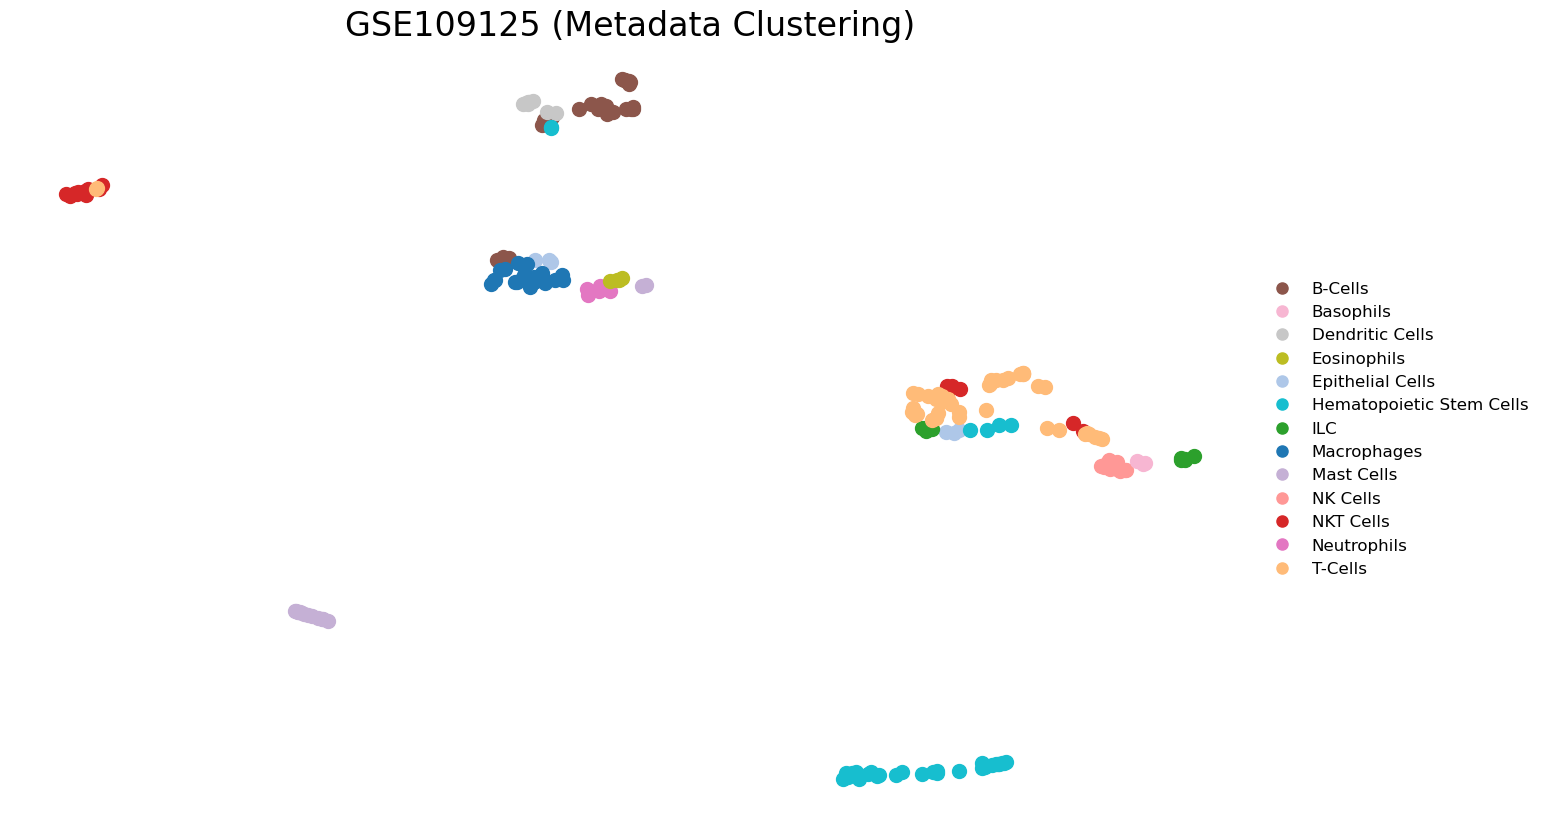

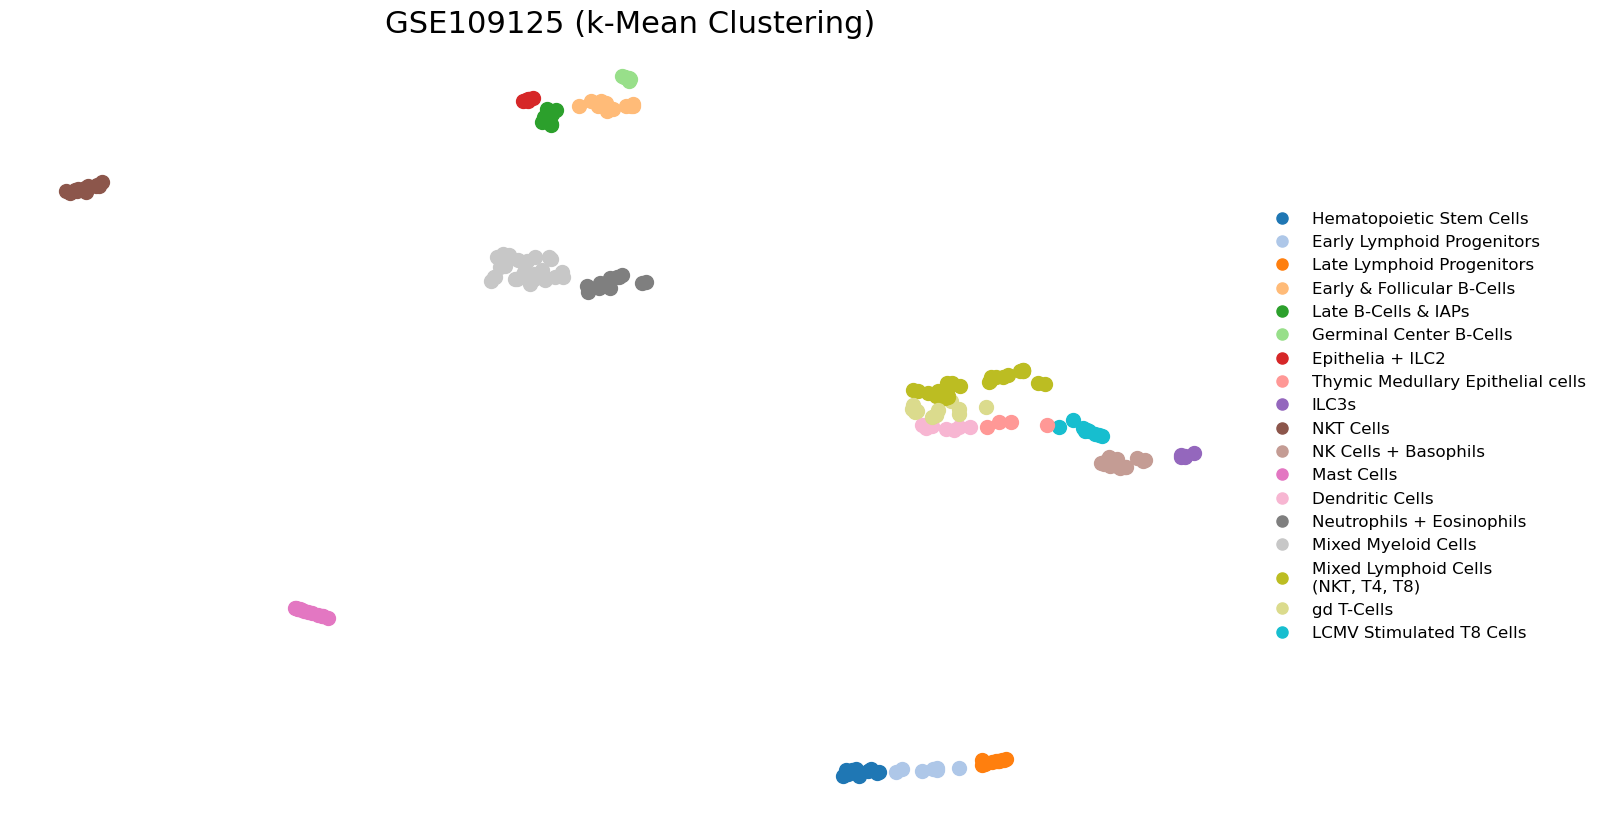

Hematopoietic Stem Cells: SUZ12, HHEX, RXRA, GFI1B, NCOR2, POU2F1, BCL11A, SPEN, NFYB, KAT6A
Early Lymphoid Progenitors: BARD1, RUNX2, TRPS1, HMGB2, BIN1, MYCN, FOXM1, BRIP1, MEF2C, MECP2
Late Lymphoid Progenitors: HMG20B, BRCA2, HCFC1, TFDP1, UHRF1, DMAP1, POLR1A, MEN1, EAF1, ELK1
Early & Follicular B-Cells: POU2AF1, LMO2, IRF4, HDAC9, PML
Late B-Cells & IAPs: BACH2, PAX5, MBD1
Germinal Center B-Cells: TP53BP1, CTCF, E2F6, CTBP1, BRCA1, FOXK2, NCOA3, DMAP1, SIN3A, CEBPZ
Epithelia + ILC2: IRF2, IRF8, IRF1, CREB1, IRF4, USF1, ABL1
Thymic Medullary Epithelial cells: ZNF423, PIAS4, PER2, GTF2I, ING1, HOPX, SPIB, SNAI2, PIR
ILC3s: EHMT2, PARP1, ZBTB14, TOP2B, SRF, NFIC, MEF2A, NFRKB, KLF4, JUN
NKT Cells: RFX1, HSF4, ETS1, RARA, RELA
NK Cells + Basophils: SKI, GATA1
Mast Cells: n.s.
Dendritic Cells: NCOA4, FOXO3, SMAD2, PA2G4, HNRNPD, RBPJ, IRF3, AHR, KHDRBS1, CLOCK
Neutrophils + Eosinophils: SP3, RB1CC1, RB1, NFATC1, SIRT3, MEN1, HDAC5, FOXO3, NF1, TRRAP
Mixed Myeloid Cells: POU2F2, CEBPD,

In [28]:
def rankpvalues(dataset, samples, lpm_classes = LPM_CLASSES):
    gene_ranking = {node: [0 for lpm_class in lpm_classes] for node in NODE_IDS}
    for i,lpm_class in enumerate(lpm_classes):
        for feature, (adj_pvalue, distance) in pvalue_of_features(dataset, lpm_class, samples, adjusted = True).items():
            gene_ranking[feature][i] = distance if (distance > 0 and adj_pvalue < 0.05) else 0

    return sorted(gene_ranking.items(), key = lambda x: sum(x[1]), reverse = True)


def custom_kmean_lpm_clusters(dataset, lpm_classes, factor = 2, rank_genes = False, write_file = False, samples = None, cmap='tab20', legend = "below", figsize=(30,15), 
                       samples_with_labels = [], marker_size = 100, n_markers = 1, highlight = [], file_name = "", weighted = False, show_plot = True, label_separator = ", "):

    plt.close()
    
    embedding = KMEAN_ALL_CLUSTERED_LOOP_EMBEDDINGS[dataset]
          
    fig, ax = plt.subplots(figsize = figsize)
    
    # ax_title = (NODES[lpm_classes[0]]["name"] if len(lpm_classes) == 1 else "All Lipid Mediators") + " (" + dataset + ")"
    print_umap(list(embedding.keys()), np.array(list(embedding.values())), UMAP_DATA_CELL_CLUSTERS[dataset][0], 
                                          title = dataset + " (Metadata Clustering)", highlight = highlight, ax = ax, n_markers = n_markers, legend=legend, 
                                          marker_size = marker_size, cmap = "tab20", sorted_legend = True)
    
    if fig and file_name:
        fig.savefig(file_name + "_metaclusters" ".png", dpi=300, bbox_inches='tight', transparent=True) 
       
    if show_plot:
        plt.show(fig)

    plt.close()
    
    fig, ax = plt.subplots(figsize = figsize)
    
    cluster_labels = {label: sum([LPM_N_CLUSTERS[dataset][1][i] for i in cluster_samples], []) for label,cluster_samples in CUSTOM_LPM_CLUSTER_LABELS[dataset].items()}

    
    cluster_list, cluster_colors = print_umap(list(embedding.keys()), np.array(list(embedding.values())), cluster_labels, 
                                              title = dataset, highlight = highlight, ax = ax, n_markers = n_markers, legend=legend, 
                                              marker_size = marker_size, cmap = "tab20", sorted_legend = False)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
          
    ax.set_title(dataset + " (k-Mean Clustering)", fontsize = 22)
      
    if fig and file_name:
        fig.savefig(file_name + ".png", dpi=300, bbox_inches='tight', transparent=True) 
       
    if show_plot:
        plt.show(fig)
        
        
    final_ranks = {}
    if rank_genes:
        for j,(label,cluster) in enumerate(cluster_labels.items()):

            ranked_genes = rankpvalues(dataset, cluster, lpm_classes = lpm_classes)
            ranked_genes = [(node[0],LPM_CLASSES[max(enumerate(node[1]), key = lambda x: x[1])[0]]) for node in ranked_genes if any([x != 0 for x in node[1]])]
            
            genename_list = [NODES[node[0]]["name"] for node in ranked_genes[:10]]
            
            final_ranks[label] = ranked_genes
            
            print(label + ": " + (", ".join(genename_list) if len(genename_list) > 0 else "n.s."))

    return (cluster_labels, cluster_list, cluster_colors, final_ranks)

CUSTOM_LPM_CLUSTERS = {dataset:custom_kmean_lpm_clusters(dataset, LPM_CLASSES, 
                            legend = "outside",figsize = (20,10), rank_genes = True, write_file = True, show_plot = True, file_name = dataset + "_custom_clustering") 
                       for i,dataset in enumerate(GSE_DATASETS[:2])}

In [58]:
import pyperclip
pyperclip.copy("\n".join([", ".join(cluster) for cluster in CUSTOM_LPM_CLUSTERS[GSE_DATASETS[1]][1]]))

<Figure size 5000x2000 with 0 Axes>

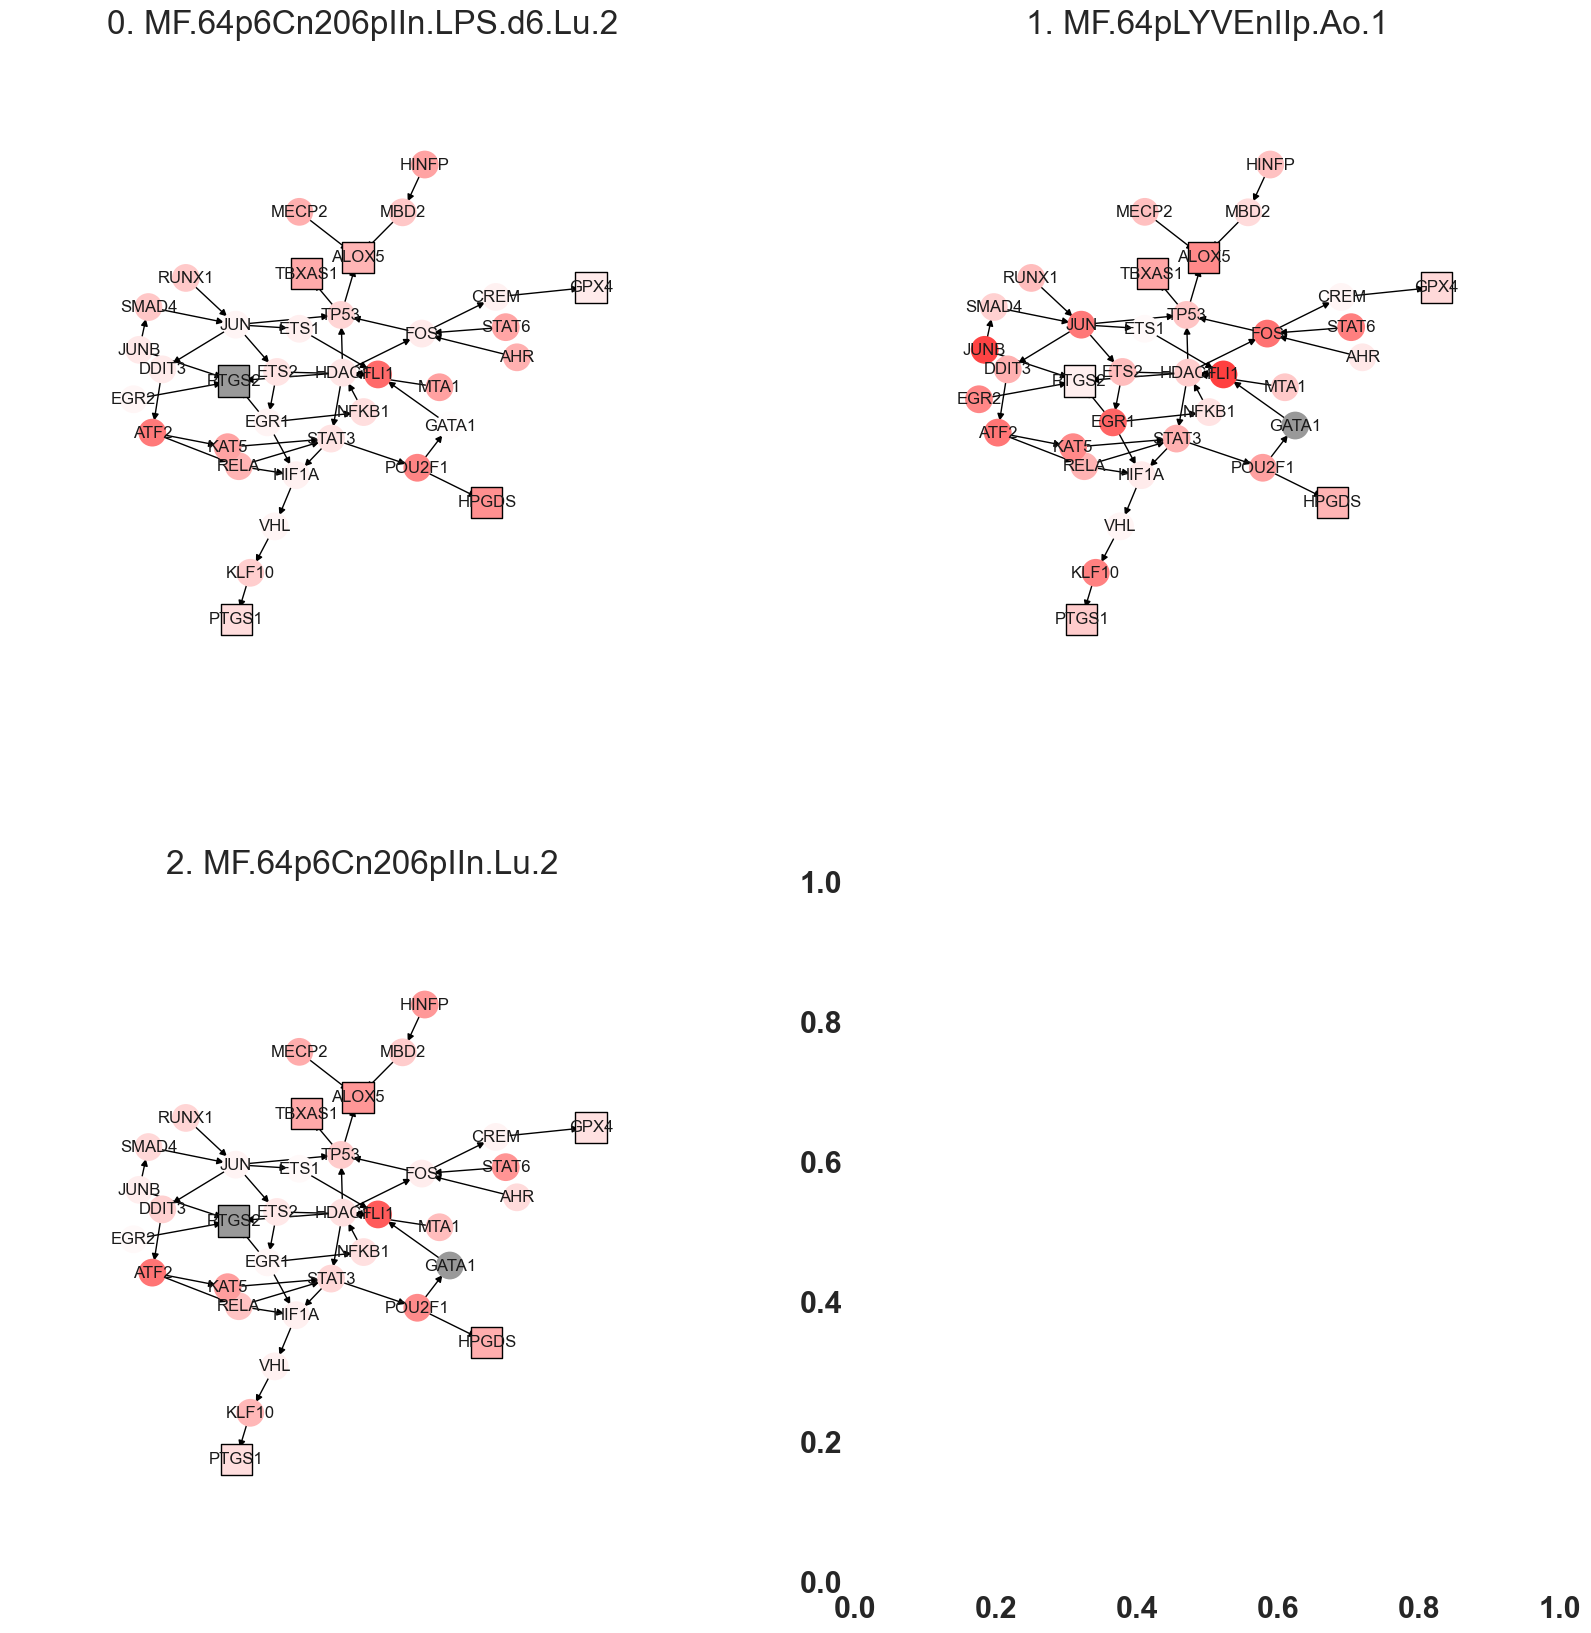

In [160]:
generate_crn_edges(GSE_DATASETS[0], 
                  ["MF.64p6Cn206pIIn.LPS.d6.Lu.2"],
                   ["MF.64pLYVEnIIp.Ao.1"], 
                   additional_samples = [["MF.64p6Cn206pIIn.Lu.2"]],
                   directed = True, coloring = "expression", lpm_classes = LPM_CLASSES,
                  fig_size = (20,20), file_name = GSE_DATASETS[0] + "_LPS_CRNs", show_ax_titles = True) 

## Rank p-Values

### Violin Plot

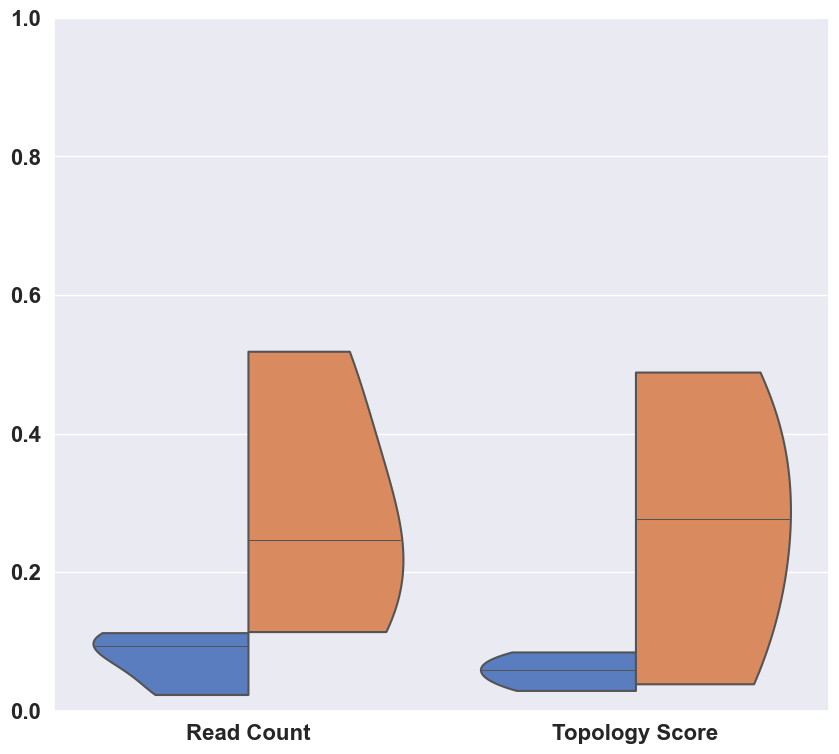

In [85]:
def show_violin(dataset, lpm_class, gene, samples1, samples2, file_name=""):
    
    plt.close()
    
    fig,ax = plt.subplots(1,1, figsize = (10,9))
    
    node = get_node_from_name(gene)
    
    samples_labels = []
    value_type = []
    values = []
    for i, samples in enumerate([samples1, samples2]):
        for j, data in enumerate([NORM_EXPRESSION_DATA[dataset], NORMALIZED_LPM_FEATURES[dataset][lpm_class]]):
            for sample in samples:
                samples_labels.append("Stim" if i == 1 else "Control")
                value_type.append("Read Count" if j == 0 else "Topology Score")
                values.append(data.loc[node,sample])

    _df = pd.DataFrame(list(zip(samples_labels, value_type, values)),
                   columns =['Sample', 'Type', 'Score'])

    ax = seaborn.violinplot(x="Type", y="Score", hue="Sample",
                        data=_df, palette="muted", split=True, scale="count", inner="stick", cut=0)
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")  
    ax.set_ylim(0,1)
    
    if file_name:
        plt.savefig(file_name + ".png", dpi=300, bbox_inches='tight')
    plt.show()
    
show_violin(GSE_DATASETS[0], get_node_from_name("thromboxan synthesis"),"hes1", 
    samples1 = ['MF.KC.Clec4FpTim4p64p.Lv.2',
   'MF.KC.Clec4FpTim4p64p.Lv.3',
   'MF.KC.Clec4FpTim4p64p.Lv.4'],

    samples2 = 
  ['MF.KC.Clec4FpTim4p64p.APAP.12h.Lv.1',
   'MF.KC.Clec4FpTim4p64p.APAP.12h.Lv.2',
   'MF.KC.Clec4FpTim4p64p.APAP.12h.Lv.4'],
            
    file_name = "hes1_thrombo_violin")

### Scatter Plot

In [ ]:
def show_feature_distribution(dataset, lpm_class, gene, custom_data = None, samples = [], samples_vs = []):
    
    plt.close()
    
    fig,ax = plt.subplots(1,1, figsize = (20,10))
    
    node = get_node_from_name(gene)
    
    data = custom_data if isinstance(custom_data, pd.DataFrame) else NORMALIZED_LPM_FEATURES[dataset][lpm_class]
    
    
    x = np.array([NORM_EXPRESSION_DATA[dataset].loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample not in samples])
    y = np.array([data.loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample not in samples])
    # x = x[y != 0]
    # y = y[y != 0]
    
    ax.scatter(x,y, color = "black")

    for i,_samples in enumerate([samples_vs, samples]):

        if len(_samples) == 0:
            continue
            
        sample_x = np.array([NORM_EXPRESSION_DATA[dataset].loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample in _samples])
        sample_y = np.array([data.loc[node,sample] for sample in DATA_SAMPLES[dataset] if sample in _samples])
        ax.scatter(sample_x,sample_y, color = "red" if i == 1 else "green")
        ax.scatter(statistics.mean(sample_x),statistics.mean(sample_y), color = "red" if i == 1 else "green", marker = "*", s = 200)
        

    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)      
    # ax.axis('off')
    
    m, b = np.polyfit(x, y, 1)
    print(statistics.mean(sample_y)-(statistics.mean(sample_x)*m+b))
    print(statistics.mean([y-(x*m+b) for x,y in zip(sample_x, sample_y)]))
    
    ax.plot(x, m*x+b, color = "black")
    
    plt.savefig("feature_distr_example.png", dpi=300, bbox_inches='tight', transparent=True) 
    plt.show()
    
    plt.close()
    
    distances = [distance_from_slope(point, (m, b)) for point in zip(x, y)]

    distance =  statistics.mean([distance_from_slope(point, (m, b)) for point in zip(sample_x, sample_y)]) 
 
    mu, std = scipy.stats.halfnorm.fit(distances) 
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = scipy.stats.halfnorm.pdf(x, mu, std)
    print(1- scipy.stats.halfnorm.cdf(distance, mu, std))
    
    plt.hist(list(map(abs, distances)), bins = 30, density = True)
    plt.axvline(abs(distance))
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()
    
show_feature_distribution(GSE_DATASETS[0], get_node_from_name("leukotriene synthesis"),"ZNF383", 
    samples = CUSTOM_LPM_CLUSTERS[GSE_DATASETS[0]][0]["Microglia"],
    samples_vs = [])

## Validation of Approach

In [ ]:
def random_walks_from_genes(dataset, genes, samples = False, n = 100, stim_duration = 20):

    random_walk_scores = {lpm_class:{} for lpm_class in LPM_CLASSES}
    samples = samples if samples else DATA_SAMPLES[dataset]
    genes = [get_node_from_name(gene) for gene in genes]
    outdegree = {node: len([edge for edge in EDGES if edge["source"] == node]) for node in NODE_IDS}
    indegree = {node: len([edge for edge in EDGES if edge["target"] == node]) for node in NODE_IDS}
    
    data = {node:[] for node in NODE_IDS}
    
    for i,sample in enumerate(samples):

        print_progress_bar(i, len(samples))
        
        nodes = set([node for node in NODE_IDS if (is_expressed(node, sample, dataset, only_genes = True))])
        extended_nodes = nodes.union(genes)

        # dictionary of edges
        edges = {node: {} for node in extended_nodes}  
        for target, source, from_submap in [(edge["target"], edge["source"], edge["submap"]) for edge in EDGES]:
            if not from_submap:
                if set([target, source]) < nodes or (target in genes and source in nodes):
                    edges[target][source] = NODES[source]["norm_read_counts"][dataset][sample]

        enzymes = {gene:1 for gene in genes}
        current_activity = enzymes     

        node_activities =  {node:[current_activity[node] if node in current_activity else 0] for node in nodes}

        for t in range(n):
            new_activity = {}

            for node,node_activity in current_activity.items():
                for source,read_count in edges[node].items():
                    if source not in new_activity:
                        new_activity[source] = 0
                    new_activity[source] += current_activity[node] * read_count / (math.sqrt(outdegree[source])*math.sqrt(indegree[node]))                       

            current_activity = new_activity   

            for enzyme, score in enzymes.items():
                current_activity[enzyme] = score if stim_duration > t else 0

            for node in nodes:
                node_activities[node].append(current_activity[node] if node in current_activity else 0)                

        for node in NODE_IDS:
            if node in node_activities and node not in genes:
                data[node].append(metrics.auc(range(n+1),node_activities[node]))
            else:
                data[node].append(0)

    return pd.DataFrame.from_dict(data, orient='index', columns=samples)

TEST_RESULTS = {dataset:random_walks_from_genes(dataset, ["TNF"]).apply(lambda row : normalize(row), axis = 1) for dataset in GSE_DATASETS}

In [ ]:
sorted([ [NODES[gene]["name"], score] for gene,(pvalue,score) in 
        pvalue_of_features(GSE_DATASETS[1], "", TEST_CLUSTERS[1][0], custom_data = TEST_RESULTS[GSE_DATASETS[1]]).items()
        if pvalue < 0.05 and score > 0], key = lambda x: x[1], reverse = True)

In [ ]:
TEST_EMBEDDING = run_umap(TEST_RESULTS[GSE_DATASETS[1]], method = "umap", n_neighbors=15, min_dist=0.1, n_components=2, metric="canberra")
TEST_CLUSTERS = print_umap_with_kmean_clusters(list(TEST_RESULTS[GSE_DATASETS[1]].columns), TEST_EMBEDDING, GSE_DATASETS[1],
                                      title = "", n_markers = 1, legend="outside", n_clusters = 6, samples_in_legend = False,
                                      marker_size = 100, cmap = "tab20", sorted_legend = True)


In [ ]:
TEST_CLUSTERS[1][0]

In [ ]:
show_feature_distribution(GSE_DATASETS[1], "","PHB2", custom_data = TEST_RESULTS[GSE_DATASETS[1]],
    samples = TEST_CLUSTERS[1][9],
    samples_vs = [])

## Cell Distance Heatmap

In [103]:
def show_cell_distances(dataset):
    
    plt.close()
    
    lpm_embedding = KMEAN_ALL_CLUSTERED_LOOP_EMBEDDINGS[dataset]
    expr_embedding = UMAP_EMBEDDING[dataset]
    
    samples = DATA_SAMPLES[dataset]
    
    lpm_distances = np.zeros(shape=(len(samples), len(samples)))
    expr_distances = np.zeros(shape=(len(samples), len(samples)))

    for (i,sample1),(j,sample2) in combinations(enumerate(samples), 2):
        lpm_distances[j,i] = np.linalg.norm(np.array(lpm_embedding[sample1]) - np.array(lpm_embedding[sample2]))
        expr_distances[j,i] = np.linalg.norm(np.array(expr_embedding[i]) - np.array(expr_embedding[j]))
        
    lpm_distances /= lpm_distances.max()
    expr_distances /= expr_distances.max()
    
    distance_difference = lpm_distances-expr_distances
    
    # sorted_pairs = list(reversed(np.dstack(np.unravel_index(np.argsort(distance_difference.ravel()), distance_difference.shape))[0]))
    # print([samples[pair[0]] + " - " + samples[pair[1]] for pair in sorted_pairs[:5]])

    
    
    print(" - ".join([str(samples[sample_id]) for sample_id in np.unravel_index(distance_difference.argmax(), distance_difference.shape)]))
    print(" - ".join([str(samples[sample_id]) for sample_id in np.unravel_index(distance_difference.argmin(), distance_difference.shape)]))

#     seaborn.set_theme(style='white')
#     g = seaborn.heatmap(distance_difference, center = 0, vmin = -1, vmax = 1, cmap = "bwr")
    
#     g.set(xticklabels=[])
#     g.set(yticklabels=[])
    
#     plt.show()
    
[show_cell_distances(dataset) for dataset in GSE_DATASETS[:2]]

['MF.64p6Cn206pIIn.LPS.d6.Lu.2 - MF.64pLYVEnIIp.Ao.1', 'MF.64p6Cn206pIIn.Lu.2 - MF.64pLYVEnIIp.Ao.1', 'MF.64p6Cn206pIIn.LPS.d6.Lu.1 - MF.64pLYVEnIIp.Ao.1', 'MF.64p6Cn206pIIp.LPS.d6.Lu.2 - MF.64pLYVEnIIp.Ao.1', 'MF.64p6Cn206pIIn.Lu.1 - MF.64pLYVEnIIp.Ao.1']
MF.64p6Cn206pIIn.LPS.d6.Lu.2 - MF.64pLYVEnIIp.Ao.1
MF.B220n6Cn64pTim4n.PC.3 - MF.45lo.Calb.48h.CNS.2
['proB.FrBC.BM.2 - B.PC.BM.1', 'proB.FrBC.BM.1 - B.PC.BM.1', 'proB.FrA.BM.2 - B.PC.BM.1', 'T.ISP.Th.2 - B.PC.BM.1', 'proB.CLP.BM.2 - B.PC.BM.1']
proB.FrBC.BM.2 - B.PC.BM.1
ILC2.ST2-.SI.1 - BEC.SLN.1


[None, None]

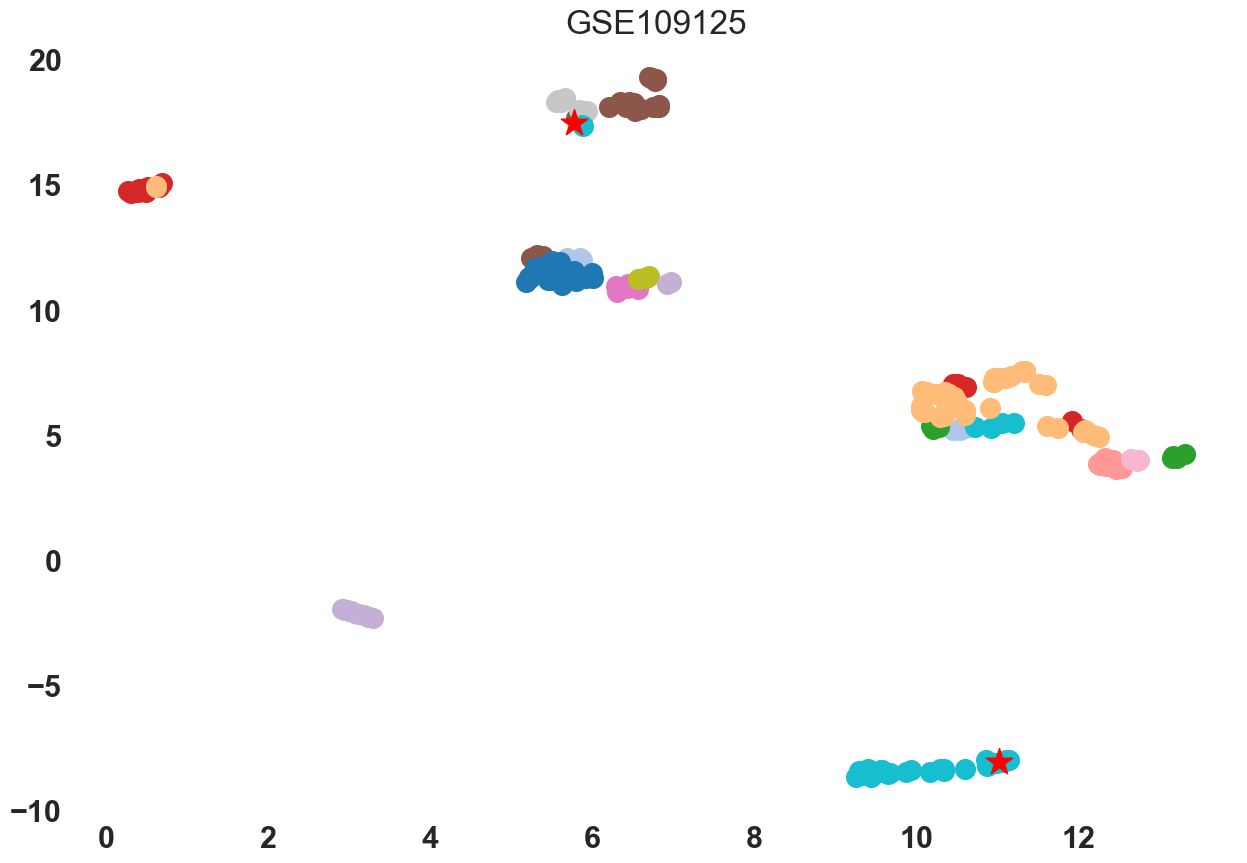

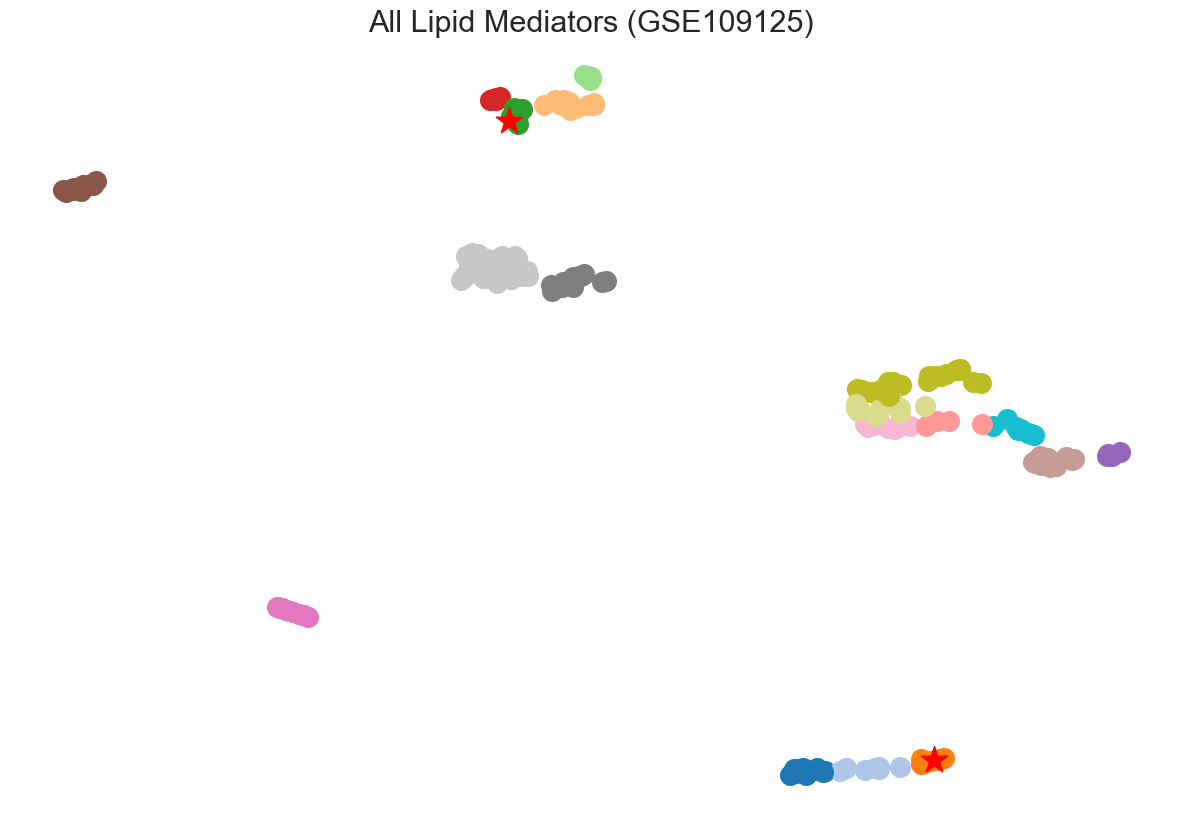

<Figure size 5000x2000 with 0 Axes>

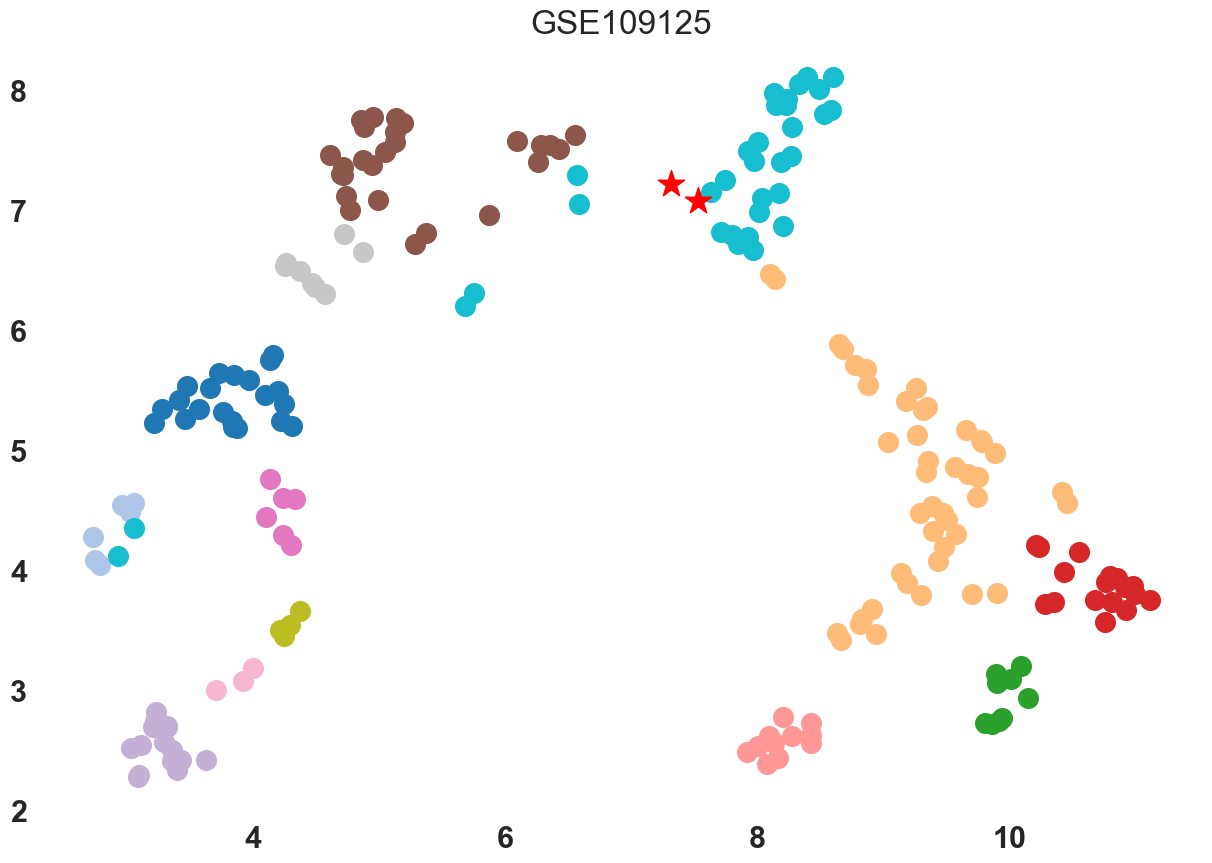

In [133]:
highlight = ["proB.FrBC.BM.2", "B.PC.BM.1"]
_ = custom_kmean_lpm_clusters(GSE_DATASETS[1], LPM_CLASSES, highlight = highlight, legend = False, figsize = (15,10), rank_genes = False, write_file = False, show_plot = True, marker_size = 200, file_name = "sample_distance_lpm_" + GSE_DATASETS[1])
_ = print_umap_with_cell_clusters(EXPRESSION_DATA[GSE_DATASETS[1]].columns, UMAP_EMBEDDING[GSE_DATASETS[1]], GSE_DATASETS[1], fig_size = (15,10), highlight = highlight, file_name = "sample_distance_all_" + GSE_DATASETS[1], n_markers=1, marker_size = 200, cmap = "tab20", legend = False)

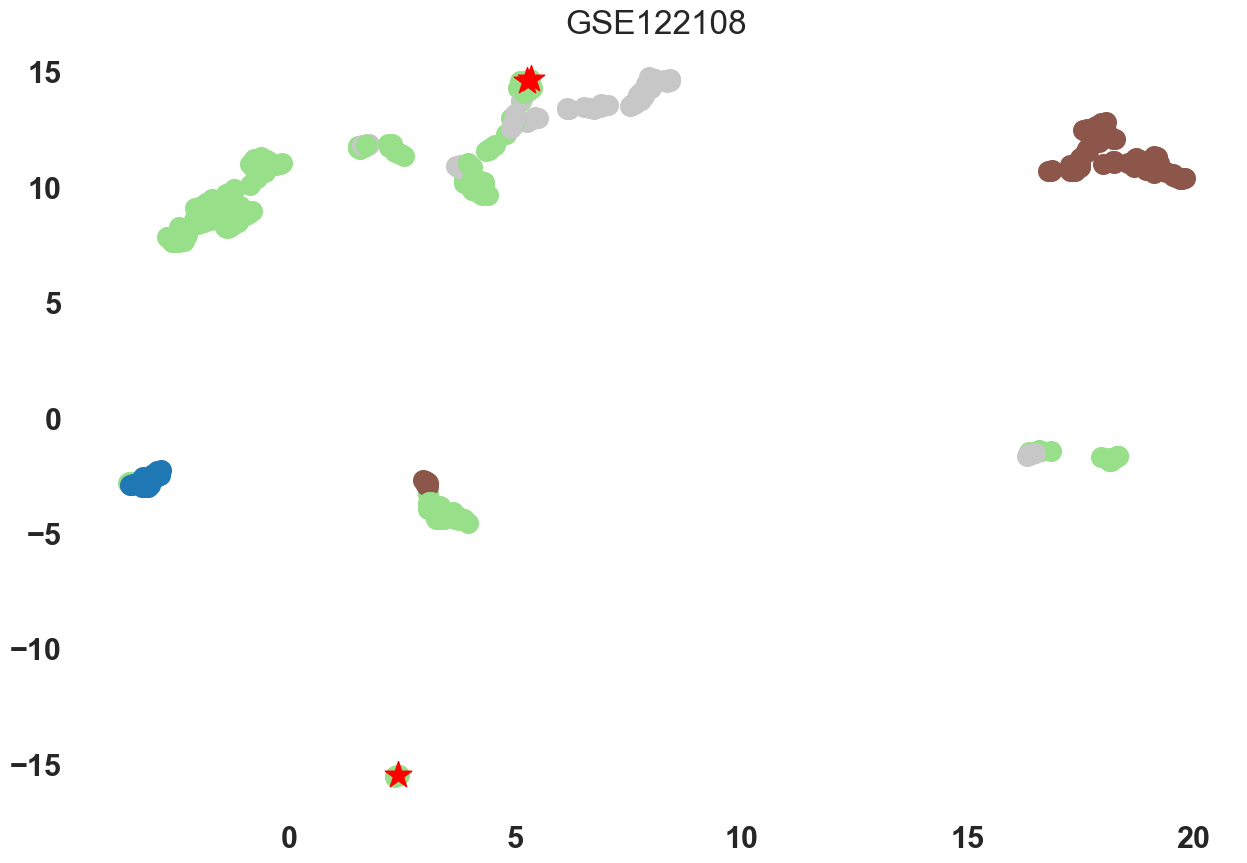

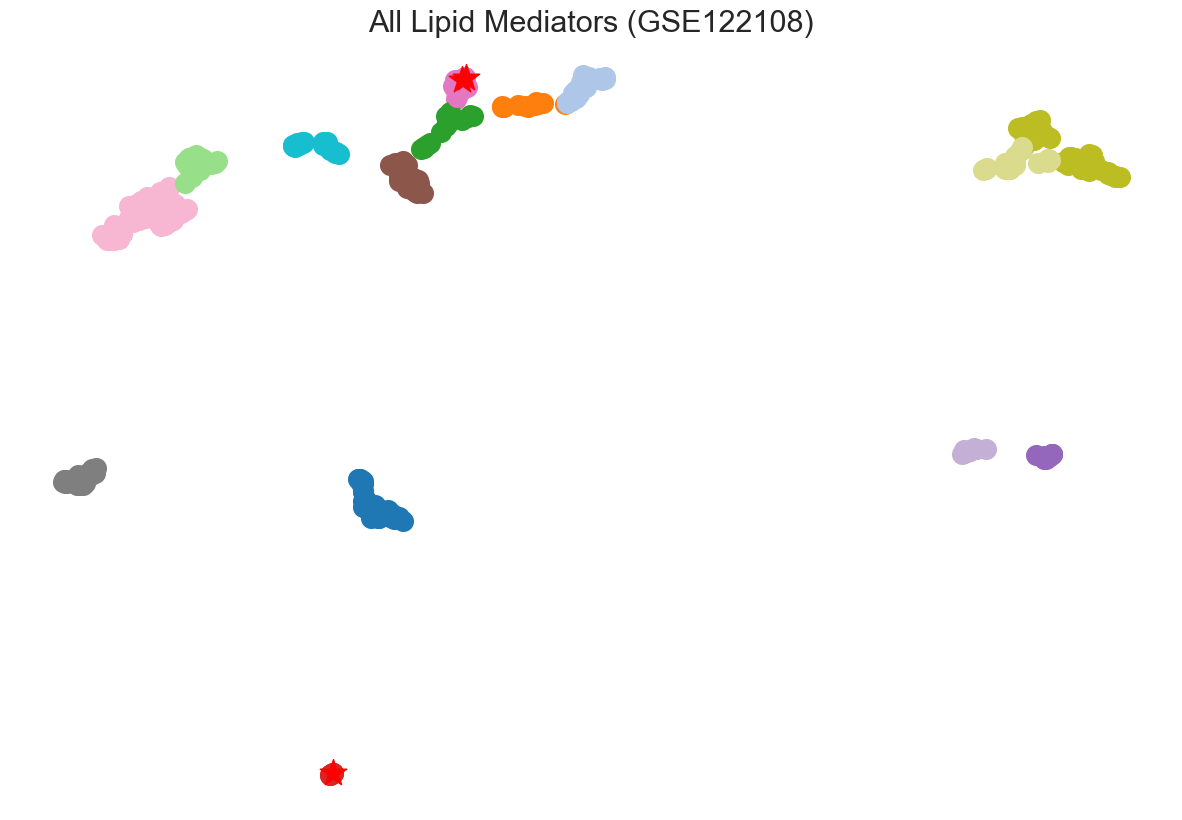

<Figure size 5000x2000 with 0 Axes>

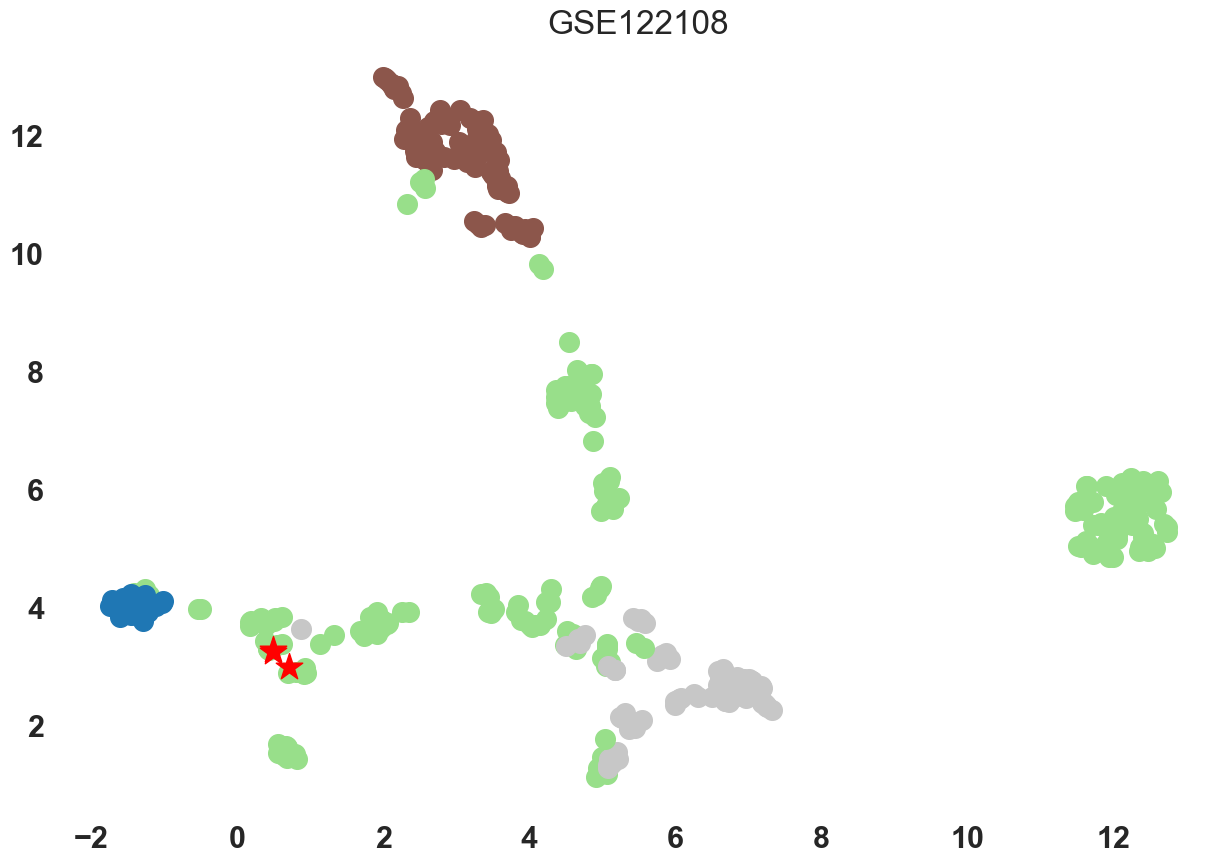

In [158]:
highlight = ["MF.64p6Cn206pIIn.LPS.d6.Lu.2", "MF.64pLYVEnIIp.Ao.1", "MF.64p6Cn206pIIn.Lu.2"]
_ = custom_kmean_lpm_clusters(GSE_DATASETS[0], LPM_CLASSES, highlight = highlight, legend = False, figsize = (15,10), rank_genes = False, write_file = False, show_plot = True, marker_size = 200, file_name = "sample_distance_lpm_" + GSE_DATASETS[0])
_ = print_umap_with_cell_clusters(EXPRESSION_DATA[GSE_DATASETS[0]].columns, UMAP_EMBEDDING[GSE_DATASETS[0]], GSE_DATASETS[0], fig_size = (15,10), highlight = highlight, file_name = "sample_distance_all_" + GSE_DATASETS[0], n_markers=1, marker_size = 200, cmap = "tab20", legend = False)

# Others

## Check if Gene is direct TF

In [61]:
genes = ["XRCC5", "MEF2A", "SMAD3", "HDAC11", "MEF2C", "ZNF24", "PRDM1", "ZFHX3", "ARID1A", "ETS1", "Nfrkb", "Usf2", "Zfp191"]
for gene in genes:
    print(gene + ": " + ", ".join([NODES[edge["target"]]["name"] for edge in EDGES if edge["source"] == get_node_from_name(gene) and edge["target"] in LPM_GENES]))

XRCC5: 
MEF2A: 
SMAD3: 
HDAC11: 
MEF2C: 
ZNF24: 
PRDM1: 
ZFHX3: 
ARID1A: 
ETS1: TBXAS1
Nfrkb: 
Usf2: PTGS2
Zfp191: 
